In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 準備

In [555]:
import pandas as pd
import numpy as np
# import matplotlib.pyplot as plt
import pprint
from sklearn.linear_model import LinearRegression,Ridge
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error,r2_score,make_scorer,mean_absolute_error
from sklearn.model_selection import train_test_split,cross_validate,KFold,GridSearchCV
from sklearn.pipeline import make_pipeline
import os
import datetime
import pytz
import xgboost as xgb
import lightgbm as lgb #LightGBM
# from sklearn.model_selection import cross_validate,KFold

In [556]:
#各versionごとのscoreと絶対値誤差を一覧で出すDataFrameの雛形作成
def create_EachModel_Score():
  cols = ['version','モデル','モデル粒度','データ区分','サンプルサイズ','説明変数ver','欠損値加工ver',\
          '各パラメーター設定','R2','adj_R2','RMSE','MAE','使用データ']
  df = pd.DataFrame(index=[], columns=cols)
  return df
create_EachModel_Score()

,version,モデル,モデル粒度,データ区分,サンプルサイズ,説明変数ver,欠損値加工ver,各パラメーター設定,R2,adj_R2,RMSE,MAE,使用データ


In [557]:
#線形モデルを作成し実際に予測
def create_Model(Model,X,y,version):
  #関数内関数の定義____________
  #自由度調整済決定係数の算出関数
  def adj_r2_score(r2_score,X):
    n = X.shape[0]
    p = X.shape[1]
    #データ数nと説明変数pは下記の式を満たさないと計算不可
    if n-p-1>0:
      adj_rs_score = 1-(1-r2_score) * ((n-1) / (n - p - 1))
    else:
      adj_rs_score = 0
      #n-p-1<=0の例外処理：この場合はadj_R2を算出できない
      # print("n-p-1<=0になったのでadj_R2を算出できません")
    return adj_rs_score

  #重要度(線形モデルの重み係数の絶対値)作成関数
  def coef_list(model,X,version):
    col_s = []
    coef_s = []
    #zipで複数のリストの要素を同時に取得
    for i, (col, coef) in enumerate(zip(X, model.coef_[0])):
        col_s.append(col)
        coef_s.append(coef)
    coef = pd.DataFrame({'version':version,'col':col_s, 'coef':coef_s})
    coef['importance'] = coef['coef'].abs()
    coef = coef.sort_values('importance',ascending=False)
    imp = coef[['version','col','importance']]
    # Importance = pd.concat([Importance, coef])
    # Importance.reset_index(inplace= True,drop=True)
    return imp

  #モデル構築_______________________
  X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.1,random_state=0)
  #正規化部分
  scaler = MinMaxScaler().fit(X_train)  
  X_train_sc = scaler.transform(X_train)
  X_test_sc = scaler.transform(X_test)
  #モデル作成
  model = Model.fit(X_train_sc, y_train)
  #学習済みモデルで予測結果を加えたX_trainとX_testを返す
  y_train_pred = model.predict(X_train_sc)
  y_test_pred = model.predict(X_test_sc)

  #score作成_______________________
  R2_train = r2_score(y_train, y_train_pred)
  R2_test = r2_score(y_test, y_test_pred)
  adj_R2_train  = adj_r2_score(R2_train,X_train)
  adj_R2_test = adj_r2_score(R2_test,X_test)
  RMSE_train = mean_squared_error(y_train, y_train_pred)
  RMSE_test =  mean_squared_error(y_test, y_test_pred)
  MAE_train = mean_absolute_error(y_train, y_train_pred)
  MAE_test =  mean_absolute_error(y_test, y_test_pred)

  train_score = [version,str(model),amountRange,"train",X_train.shape[0],expVer,missVer,\
                 param,R2_train,adj_R2_train,RMSE_train,MAE_train,useData]
  test_score = [version,str(model),amountRange,"test",X_test.shape[0],expVer,missVer,\
                param,R2_test,adj_R2_test,RMSE_test,MAE_test,useData]
  score = [train_score,test_score]

  #pred作成________________________
  X_train["合計金額"] = y_train
  X_train["pred"] = y_train_pred
  X_train["誤差"] = X_train['合計金額'] - X_train['pred']
  #train_test_splitでindexの順番変わっているので、昇順に並び替え
  X_train.sort_index(ascending=True,inplace=True)
  X_train =X_train[['合計金額','pred','誤差']]
  #tableauでの可視化のため連番を振っていく
  serial_num = pd.RangeIndex(start=1, stop=len(X_train.index) + 1, step=1)
  X_train['No'] = serial_num
  #trainとtestを判別するフラグ列を作成
  X_train['データ区分'] = 'train'

  X_test["合計金額"] = y_test
  X_test["pred"] = y_test_pred
  X_test["誤差"] = X_test['合計金額'] - X_test['pred']
  #train_test_splitでindexの順番変わっているので、昇順に並び替え
  X_test.sort_index(ascending=True,inplace=True)
  X_test =X_test[['合計金額','pred','誤差']]
  #tableauでの可視化のため連番を振っていく
  serial_num = pd.RangeIndex(start=1, stop=len(X_test.index) + 1, step=1)
  X_test['No'] = serial_num
  #trainとtestを判別するフラグ列を作成
  X_test['データ区分'] = 'test'

  pred = pd.concat([X_train, X_test])
  pred['version'] = version
  #indexに使用している見積もりIDをデータ列に戻す
  pred.reset_index(inplace=True)
  pred = pred.rename(columns={'index': '見積もりID'})
  pred = pred.reindex(columns=['version', 'データ区分','No','見積もりID','合計金額', 'pred', '誤差'])

  #imp(作成したモデルの重み係数の絶対値の降順)作成___________________
  imp = coef_list(model,X,version)

  return model,score,pred,imp

In [558]:
#RandomeforestRegressor()モデル作成を作成し実際に予測
def create_RFR(X,y,data,version):
  X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.1,random_state=0)

  #実際のパラメーター_____________
  parameters = {  
      'n_estimators': [300,500],     # 用意する決定木モデルの数
  }
  model = RFR(n_jobs=-1, random_state=2525)
  #ここまで_________________________

  #テスト用パラメーター_____________
  # parameters = {  
  #     'n_estimators': [2,3],     # 用意する決定木モデルの数
  # }
  # model = RFR(n_jobs=-1, max_features='auto', max_depth=10, random_state=2525)
  #ここまで_________________________

  # ハイパーパラメータチューニング(グリッドサーチのコンストラクタにモデルと辞書パラメータを指定)
  gridsearch = GridSearchCV(estimator = model,        # モデル
                            param_grid = parameters,  # チューニングするハイパーパラメータ
                            verbose=1,
                            cv=10,
                            return_train_score=True
                          )

  # 演算実行
  gridsearch.fit(X_train, y_train)

  # グリッドサーチの結果から得られた最適なパラメータ候補を確認
  print('Best params: {}'.format(gridsearch.best_params_)) 
  param = gridsearch.best_params_
  print('Best Score: {}'.format(gridsearch.best_score_))
  print("Best_train_Scores_",gridsearch.cv_results_)
  #テストデータで評価
  model = gridsearch.best_estimator_
  # 学習データに対する目的変数を予測
  y_train_pred = model.predict(X_train) 
  y_test_pred = model.predict(X_test)
  
  #自由度調整済決定係数の算出関数
  def adj_r2_score(r2_score,X):
    n = X.shape[0]
    p = X.shape[1]
    #データ数nと説明変数pは下記の式を満たさないと計算不可
    if n-p-1>0:
      adj_rs_score = 1-(1-r2_score) * ((n-1) / (n - p - 1))
    else:
      adj_rs_score = 0
      #n-p-1<=0の例外処理：この場合はadj_R2を算出できない
      # print("n-p-1<=0になったのでadj_R2を算出できません")
    return adj_rs_score

  R2_train = r2_score(y_train, y_train_pred)
  R2_test = r2_score(y_test, y_test_pred)
  adj_R2_train  = adj_r2_score(R2_train,X_train)
  adj_R2_test = adj_r2_score(R2_test,X_test)
  RMSE_train = mean_squared_error(y_train, y_train_pred)
  RMSE_test =  mean_squared_error(y_test, y_test_pred)
  MAE_train = mean_absolute_error(y_train, y_train_pred)
  MAE_test =  mean_absolute_error(y_test, y_test_pred)

  train_score = [version,str(model),amountRange,"train",X_train.shape[0],expVer,missVer,\
                 param,R2_train,adj_R2_train,RMSE_train,MAE_train,useData]
  test_score = [version,str(model),amountRange,"test",X_test.shape[0],expVer,missVer,\
                param,R2_test,adj_R2_test,RMSE_test,MAE_test,useData]
  score = [train_score,test_score]


  X_train["合計金額"] = y_train
  X_train["pred"] = y_train_pred
  X_train["誤差"] = X_train['合計金額'] - X_train['pred']
  #train_test_splitでindexの順番変わっているので、昇順に並び替え
  X_train.sort_index(ascending=True,inplace=True)
  X_train =X_train[['合計金額','pred','誤差']]
  #tableauでの可視化のため連番を振っていく
  serial_num = pd.RangeIndex(start=1, stop=len(X_train.index) + 1, step=1)
  X_train['No'] = serial_num
  #trainとtestを判別するフラグ列を作成
  X_train['データ区分'] = 'train'

  X_test["合計金額"] = y_test
  X_test["pred"] = y_test_pred
  X_test["誤差"] = X_test['合計金額'] - X_test['pred']
  #train_test_splitでindexの順番変わっているので、昇順に並び替え
  X_test.sort_index(ascending=True,inplace=True)
  X_test =X_test[['合計金額','pred','誤差']]
  #tableauでの可視化のため連番を振っていく
  serial_num = pd.RangeIndex(start=1, stop=len(X_test.index) + 1, step=1)
  X_test['No'] = serial_num
  #trainとtestを判別するフラグ列を作成
  X_test['データ区分'] = 'test'

  pred = pd.concat([X_train, X_test])
  pred['version'] = version
  #indexに使用している見積もりIDをデータ列に戻す
  pred.reset_index(inplace=True)
  pred = pred.rename(columns={'index': '見積もりID'})
  pred = pred.reindex(columns=['version', 'データ区分','No','見積もりID','合計金額', 'pred', '誤差'])

  #imp作成
  feature = model.feature_importances_
  label = X.columns
  imp = pd.DataFrame({'version':version,'col':label, 'importance':feature})
  imp = imp.sort_values('importance',ascending=False)
  return model,score,pred,imp

In [559]:
#XGBoostRegressor()モデル作成を作成し実際に予測
def create_XGB(X,y,data,version):
  X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.1,random_state=0)

  model = xgb.XGBRegressor(n_jobs=-1, random_state=2525)

  parameters={
          'n_estimators':[100,300,500],
          }

  scorer=make_scorer(mean_squared_error)

  gridsearch=GridSearchCV(estimator = model,
                            param_grid=parameters,
                            n_jobs=-1,
                            scoring=scorer,
                            cv=10,
                            return_train_score=True
                          )

  gridsearch.fit(X_train, y_train)
  print(gridsearch.best_params_)
  param=gridsearch.best_params_
  model = gridsearch.best_estimator_
  # 学習データに対する目的変数を予測
  y_train_pred = model.predict(X_train) 
  y_test_pred = model.predict(X_test)

  #自由度調整済決定係数の算出関数
  def adj_r2_score(r2_score,X):
    n = X.shape[0]
    p = X.shape[1]
    #データ数nと説明変数pは下記の式を満たさないと計算不可
    if n-p-1>0:
      adj_rs_score = 1-(1-r2_score) * ((n-1) / (n - p - 1))
    else:
      adj_rs_score = 0
      #n-p-1<=0の例外処理：この場合はadj_R2を算出できない
      # print("n-p-1<=0になったのでadj_R2を算出できません")
    return adj_rs_score

  R2_train = r2_score(y_train, y_train_pred)
  R2_test = r2_score(y_test, y_test_pred)
  adj_R2_train  = adj_r2_score(R2_train,X_train)
  adj_R2_test = adj_r2_score(R2_test,X_test)
  RMSE_train = mean_squared_error(y_train, y_train_pred)
  RMSE_test =  mean_squared_error(y_test, y_test_pred)
  MAE_train = mean_absolute_error(y_train, y_train_pred)
  MAE_test =  mean_absolute_error(y_test, y_test_pred)

  train_score = [version,str(model),amountRange,"train",X_train.shape[0],expVer,missVer,\
                 param,R2_train,adj_R2_train,RMSE_train,MAE_train,useData]
  test_score = [version,str(model),amountRange,"test",X_test.shape[0],expVer,missVer,\
                param,R2_test,adj_R2_test,RMSE_test,MAE_test,useData]
  score = [train_score,test_score]


  X_train["合計金額"] = y_train
  X_train["pred"] = y_train_pred
  X_train["誤差"] = X_train['合計金額'] - X_train['pred']
  #train_test_splitでindexの順番変わっているので、昇順に並び替え
  X_train.sort_index(ascending=True,inplace=True)
  X_train =X_train[['合計金額','pred','誤差']]
  #tableauでの可視化のため連番を振っていく
  serial_num = pd.RangeIndex(start=1, stop=len(X_train.index) + 1, step=1)
  X_train['No'] = serial_num
  #trainとtestを判別するフラグ列を作成
  X_train['データ区分'] = 'train'

  X_test["合計金額"] = y_test
  X_test["pred"] = y_test_pred
  X_test["誤差"] = X_test['合計金額'] - X_test['pred']
  #train_test_splitでindexの順番変わっているので、昇順に並び替え
  X_test.sort_index(ascending=True,inplace=True)
  X_test =X_test[['合計金額','pred','誤差']]
  #tableauでの可視化のため連番を振っていく
  serial_num = pd.RangeIndex(start=1, stop=len(X_test.index) + 1, step=1)
  X_test['No'] = serial_num
  #trainとtestを判別するフラグ列を作成
  X_test['データ区分'] = 'test'

  pred = pd.concat([X_train, X_test])
  pred['version'] = version
  #indexに使用している見積もりIDをデータ列に戻す
  pred.reset_index(inplace=True)
  pred = pred.rename(columns={'index': '見積もりID'})
  pred = pred.reindex(columns=['version', 'データ区分','No','見積もりID','合計金額', 'pred', '誤差'])

  #imp作成
  feature = model.feature_importances_
  label = X.columns
  imp = pd.DataFrame({'version':version,'col':label, 'importance':feature})
  imp = imp.sort_values('importance',ascending=False)
  return model,score,pred,imp

In [560]:
#DataFrameを任意のディレクトリ下のcsvファイルに書き出す関数
def output_func(output_dir, output_file_name,df):
    # ディレクトリがないとエラーになるため、なければ親ディレクトリを作成
    if not os.path.exists(output_dir):
      os.mkdir(output_dir)
    fullname = os.path.join(output_dir, output_file_name)    
    df.to_csv(fullname,index = False)

In [561]:
#モデル構築ごとにcsvファイルに書き出すDataframeを更新していく関数
def to_df(Predict,EachModel_Score,Importance,pred,score,imp):
  cols = ['version','モデル','モデル粒度','データ区分','サンプルサイズ','説明変数ver','欠損値加工ver',\
          '各パラメーター設定','R2','adj_R2','RMSE','MAE','使用データ']
  if version == 1:
    #EachModel_Score作成
    EachModel_Score = create_EachModel_Score()
    for sco in score:
      sc =pd.Series(sco,index=cols)
      EachModel_Score = EachModel_Score.append(sc,ignore_index=True)
    #Predict作成  
    Predict = pred
    #Importance作成
    Importance = imp
    Importance.reset_index(inplace= True,drop=True)
  else:
    #EachModel_Scoreに追記
    for sco in score:
      sc =pd.Series(sco,index=cols)
      EachModel_Score = EachModel_Score.append(sc,ignore_index=True)
    #Predictに追記
    Predict = pd.concat([Predict,pred]).reset_index(drop=True)
    #Importanceに追記
    Importance = pd.concat([Importance,imp]).reset_index(drop=True)
  return Predict,EachModel_Score,Importance

# 線形モデル


# 説明変数ver1

# 工事金額別で分けずに(全体（金額規模に限定しない）)3種類のモデル作成

目的： 工事金額別で分けずに(全体（金額規模に限定しない）)3種類のモデル作成.  
ver1 : ０で埋める(0fill).  
ver2：必要エネルギー量（外気量）欠損してるものは無視する（行削除）(Delete missing)  
ver3：必要エネルギー量（外気量）欠損してるものは線形補完する(Linear interpolation)

In [562]:
EachModel_Score = create_EachModel_Score()
EachModel_Score

,version,モデル,モデル粒度,データ区分,サンプルサイズ,説明変数ver,欠損値加工ver,各パラメーター設定,R2,adj_R2,RMSE,MAE,使用データ


## version1:欠損値0埋め

In [563]:
version = 1
#説明変数version、欠損値加工version、使用データ
expVer,missVer,useData= 1,1,"0830"
#モデル粒度、パラメーター設定
amountRange ="全件"
param = "NULL"

data = pd.read_excel('/content/drive/MyDrive/iroribi_dev_local/20220830_予算化用データ.xlsx'\
                     ,sheet_name='マスターデータ')
data[['合計金額']] = data[['合計金額']].fillna(method='ffill')

#説明変数ver1
X = data.loc[:,'内装仕上げ（天井）':'必要エネルギー量（外気量）（㎥/h）'] #X:説明変数
drop_colmuns = ['用途（整理用）\n※追加','工事金額','工事金額（整理用）','工事面積（整理用）']
X = X.drop(drop_colmuns, axis=1)
#y:目的変数
y = data[['合計金額']]

#工事面積以外の列はobject型なのでカラムのデータ型変更(じゃないと欠損値操作できない)
#説明変数のカラムを取得し、データ変換したいカラム(入居人数以降)をdum_listに格納
col_list = X.columns.tolist()
dum_list = col_list[col_list.index('入居人数（人）'):]
#dum_list内にある要素名のカラムをfloatに変換
for i in dum_list:
  X[i]=pd.to_numeric(X[i],errors="coerce")

#欠損値操作
X = X.fillna(0)
X = pd.get_dummies(X,drop_first=True)

model,score,pred,imp = create_Model(LinearRegression(),X,y,version)

#各Dataframeへ追記(version=1の時のみ0を引数としておく)
Predict,EachModel_Score,Importance = to_df(0,0,0,pred,score,imp)

### versionごとの出力確認セル 

In [564]:
EachModel_Score[EachModel_Score['version'] == version]

,version,モデル,モデル粒度,データ区分,サンプルサイズ,説明変数ver,欠損値加工ver,各パラメーター設定,R2,adj_R2,RMSE,MAE,使用データ
0,1,LinearRegression(),全件,train,142,1,1,NULL,0.865251,0.815538,4.769472e+13,3.925857e+06,0830
1,1,LinearRegression(),全件,test,16,1,1,NULL,-0.875940,0.000000,4.642468e+12,1.417023e+06,0830


In [565]:
Predict[Predict['version'] == version]

,version,データ区分,No,見積もりID,合計金額,pred,誤差
0,1,train,1,0,1.678600e+05,1.678600e+05,7.264316e-08
1,1,train,2,1,2.111880e+05,8.515177e+05,-6.403297e+05
2,1,train,3,2,2.250000e+05,8.277449e+05,-6.027449e+05
3,1,train,4,3,2.380000e+05,4.875549e+06,-4.637549e+06
4,1,train,5,4,2.500000e+05,-5.165223e+06,5.415223e+06
...,...,...,...,...,...,...,...
153,1,test,12,120,3.000000e+06,3.026940e+06,-2.693981e+04
154,1,test,13,121,3.004905e+06,2.483267e+06,5.216377e+05
155,1,test,14,122,3.005051e+06,2.483267e+06,5.217844e+05
156,1,test,15,139,5.012200e+06,-1.220742e+06,6.232942e+06


In [566]:
Importance[Importance['version'] == version]

,version,col,importance
0,1,必要エネルギー量（外気量）（㎥/h）,1.306319e+08
1,1,工事面積（㎡）,1.188197e+08
2,1,室内負荷（kw）,2.766160e+07
3,1,工事条件_平日/休日,2.162348e+07
4,1,工事計画_整備,1.985188e+07
5,1,内装仕上げ（壁）_ボード壁,1.924270e+07
6,1,内装仕上げ（壁）_LGS,1.354519e+07
7,1,入居人数（人）,1.126222e+07
8,1,用途_機械室,9.830791e+06
9,1,工事条件_平日,7.637896e+06


## version2:必要エネルギー量（外気量）の欠損：削除、残りの欠損値0埋め

欠損には、空白と「-」の二種類があるので、先にobject型からfloat型に変えて二種類の欠損を同時に削除

In [567]:
version = 2
#説明変数version、欠損値加工version、使用データ
expVer,missVer,useData= 1,0,"0830"
#モデル粒度、パラメーター設定
amountRange ="全件"
param = "NULL"
data = pd.read_excel('/content/drive/MyDrive/iroribi_dev_local/20220830_予算化用データ.xlsx'\
                     ,sheet_name='マスターデータ')
data[['合計金額']] = data[['合計金額']].fillna(method='ffill')
#必要エネルギー量（外気量）（㎥/h）に欠損がある行を削除
data['必要エネルギー量（外気量）（㎥/h）']=pd.to_numeric(data['必要エネルギー量（外気量）（㎥/h）'],errors="coerce")
print("必要エネルギー量（外気量）（㎥/h）の欠損数")
print("Before:",data['必要エネルギー量（外気量）（㎥/h）'].isnull().sum())
data = data.dropna(subset=['必要エネルギー量（外気量）（㎥/h）'])
print("After:",data['必要エネルギー量（外気量）（㎥/h）'].isnull().sum())

必要エネルギー量（外気量）（㎥/h）の欠損数
Before: 105
After: 0


In [568]:
#X:説明変数
X = data.loc[:,'内装仕上げ（天井）':'必要エネルギー量（外気量）（㎥/h）'] 
drop_colmuns = ['用途（整理用）\n※追加','工事金額','工事金額（整理用）','工事面積（整理用）']
X = X.drop(drop_colmuns, axis=1)

#y:目的変数
y = data[['合計金額']]

#工事面積以外の列はobject型なのでカラムのデータ型変更(じゃないと欠損値操作できない)
#説明変数のカラムを取得し、データ変換したいカラム(入居人数以降)をdum_listに格納
col_list = X.columns.tolist()
dum_list = col_list[col_list.index('入居人数（人）'):]
#dum_list内にある要素名のカラムをfloatに変換
for i in dum_list:
  X[i]=pd.to_numeric(X[i],errors="coerce")

#欠損値操作
X = X.fillna(0)

X = pd.get_dummies(X,drop_first=True)
model,score,pred,imp = create_Model(LinearRegression(),X,y,version)

#各Dataframeへ追記
Predict,EachModel_Score,Importance =to_df(Predict,EachModel_Score,Importance,\
                                          pred,score,imp)

### versionごとの出力確認セル 

In [569]:
EachModel_Score[EachModel_Score['version'] == version]

,version,モデル,モデル粒度,データ区分,サンプルサイズ,説明変数ver,欠損値加工ver,各パラメーター設定,R2,adj_R2,RMSE,MAE,使用データ
2,2,LinearRegression(),全件,train,47,1,0,NULL,0.994211,0.985206,5.356607e+12,1.396443e+06,0830
3,2,LinearRegression(),全件,test,6,1,0,NULL,-896.601715,0.000000,5.725049e+15,4.506621e+07,0830


In [570]:
Predict[Predict['version'] == version]

,version,データ区分,No,見積もりID,合計金額,pred,誤差
158,2,train,1,5,2.500780e+05,9.573739e+04,1.543406e+05
159,2,train,2,6,2.540000e+05,2.540000e+05,9.685755e-08
160,2,train,3,14,2.960000e+05,2.960000e+05,5.215406e-08
161,2,train,4,28,3.459980e+05,5.003386e+05,-1.543406e+05
162,2,train,5,34,3.990000e+05,2.001907e+06,-1.602907e+06
163,2,train,6,43,4.700000e+05,4.700000e+05,1.043081e-07
164,2,train,7,45,5.200000e+05,4.211077e+06,-3.691077e+06
165,2,train,8,57,6.000000e+05,6.529265e+05,-5.292651e+04
166,2,train,9,63,6.570000e+05,3.190103e+05,3.379897e+05
167,2,train,10,71,7.900000e+05,7.900000e+05,-5.960464e-08


In [571]:
Importance[Importance['version'] == version]

,version,col,importance
38,2,工事面積（㎡）,1.327475e+08
39,2,内装仕上げ（壁）_ALC,9.405706e+07
40,2,内装仕上げ（天井）_直天井,8.799316e+07
41,2,入居人数（人）,7.671184e+07
42,2,内装仕上げ（天井）_システム天井,4.175778e+07
43,2,工事条件_平日/休日,4.035651e+07
44,2,内装仕上げ（天井）_在来天井,3.929078e+07
45,2,工事計画_新設,3.585081e+07
46,2,内装仕上げ（壁）_スチールパーティション,3.552637e+07
47,2,工事計画_改修(撤去・新設),3.442754e+07


## version3:必要エネルギー量（外気量）の欠損：線形補完、残りの欠損値：0埋め

In [572]:
version = 3
#説明変数version、欠損値加工version、使用データ
expVer,missVer,useData= 1,2,"0830"
#モデル粒度、パラメーター設定
amountRange ="全件"
param = "NULL"

data = pd.read_excel('/content/drive/MyDrive/iroribi_dev_local/20220830_予算化用データ.xlsx'\
                     ,sheet_name='マスターデータ')
data[['合計金額']] = data[['合計金額']].fillna(method='ffill')

X = data.loc[:,'内装仕上げ（天井）':'必要エネルギー量（外気量）（㎥/h）'] #X:説明変数
drop_colmuns = ['用途（整理用）\n※追加','工事金額','工事金額（整理用）','工事面積（整理用）']
X = X.drop(drop_colmuns, axis=1)
y = data[['合計金額']] #y:目的変数

#工事面積以外の列はobject型なのでカラムのデータ型変更(じゃないと欠損値操作できない)
#説明変数のカラムを取得し、データ変換したいカラム(入居人数以降)をdum_listに格納
col_list = X.columns.tolist()
dum_list = col_list[col_list.index('入居人数（人）'):]
#dum_list内にある要素名のカラムをfloatに変換
for i in dum_list:
  X[i]=pd.to_numeric(X[i],errors="coerce")

#欠損値操作
#必要エネルギー量（外気量）のみ線形補完
X["必要エネルギー量（外気量）（㎥/h）"] = X["必要エネルギー量（外気量）（㎥/h）"].interpolate()
X = X.fillna(0)

X = pd.get_dummies(X,drop_first=True)

model,score,pred,imp = create_Model(LinearRegression(),X,y,version)

#各Dataframeへ追記
Predict,EachModel_Score,Importance =to_df(Predict,EachModel_Score,Importance,\
                                          pred,score,imp)

### versionごとの出力確認セル 

In [573]:
EachModel_Score[EachModel_Score['version'] == version]

,version,モデル,モデル粒度,データ区分,サンプルサイズ,説明変数ver,欠損値加工ver,各パラメーター設定,R2,adj_R2,RMSE,MAE,使用データ
4,3,LinearRegression(),全件,train,142,1,2,NULL,0.804511,0.732388,6.919379e+13,4.919428e+06,0830
5,3,LinearRegression(),全件,test,16,1,2,NULL,-21.922443,0.000000,5.672714e+13,5.331059e+06,0830


In [574]:
Predict[Predict['version'] == version]

,version,データ区分,No,見積もりID,合計金額,pred,誤差
211,3,train,1,0,1.678600e+05,1.678600e+05,6.798655e-08
212,3,train,2,1,2.111880e+05,-9.119482e+05,1.123136e+06
213,3,train,3,2,2.250000e+05,-4.264022e+06,4.489022e+06
214,3,train,4,3,2.380000e+05,1.860470e+06,-1.622470e+06
215,3,train,5,4,2.500000e+05,-7.056023e+06,7.306023e+06
...,...,...,...,...,...,...,...
364,3,test,12,120,3.000000e+06,-1.072738e+06,4.072738e+06
365,3,test,13,121,3.004905e+06,1.655089e+06,1.349815e+06
366,3,test,14,122,3.005051e+06,1.655089e+06,1.349962e+06
367,3,test,15,139,5.012200e+06,-4.841055e+06,9.853255e+06


In [575]:
Importance[Importance['version'] == version]

,version,col,importance
66,3,工事面積（㎡）,1.020597e+08
67,3,室内負荷（kw）,6.830344e+07
68,3,必要エネルギー量（外気量）（㎥/h）,6.766515e+07
69,3,内装仕上げ（壁）_LGS,2.850601e+07
70,3,内装仕上げ（壁）_ボード壁,2.035076e+07
71,3,工事条件_平日/休日,1.790025e+07
72,3,工事計画_整備,1.667524e+07
73,3,用途_機械室,1.347926e+07
74,3,工事条件_平日,9.502008e+06
75,3,内装仕上げ（壁）_スチールパーテーション,6.815164e+06


# 工事金額20万以上500万未満のもののみにおいてモデルを作成.

## 説明変数ver1

### version04:必要エネルギー量（外気量）の欠損：削除、残りの欠損値0埋め

欠損には、空白と「-」の二種類があるので、先にobject型からfloat型に変えて二種類の欠損を同時に削除

In [576]:
version = 4
#説明変数version、欠損値加工version、使用データ
expVer,missVer,useData= 1,0,"0830"
#モデル粒度、パラメーター設定
amountRange ="工事金額別（２０以上500万未満）"
param = "NULL"
data = pd.read_excel('/content/drive/MyDrive/iroribi_dev_local/20220830_予算化用データ.xlsx'\
                     ,sheet_name='マスターデータ')
data = data[data["工事金額"] == "20万以上500万未満"] 
data[['合計金額']] = data[['合計金額']].fillna(method='ffill')
#必要エネルギー量（外気量）（㎥/h）に欠損がある行を削除
data['必要エネルギー量（外気量）（㎥/h）']=pd.to_numeric(data['必要エネルギー量（外気量）（㎥/h）'],errors="coerce")
print("必要エネルギー量（外気量）（㎥/h）の欠損数")
print("Before:",data['必要エネルギー量（外気量）（㎥/h）'].isnull().sum())
data = data.dropna(subset=['必要エネルギー量（外気量）（㎥/h）'])
print("After:",data['必要エネルギー量（外気量）（㎥/h）'].isnull().sum())

必要エネルギー量（外気量）（㎥/h）の欠損数
Before: 99
After: 0


In [577]:
#X:説明変数
X = data.loc[:,'内装仕上げ（天井）':'必要エネルギー量（外気量）（㎥/h）']
drop_colmuns = ['用途（整理用）\n※追加','工事金額','工事金額（整理用）','工事面積（整理用）']
X = X.drop(drop_colmuns, axis=1)
#y:目的変数
y = data[['合計金額']]

#工事面積以外の列はobject型なのでカラムのデータ型変更(じゃないと欠損値操作できない)
#説明変数のカラムを取得し、データ変換したいカラム(入居人数以降)をdum_listに格納
col_list = X.columns.tolist()
dum_list = col_list[col_list.index('入居人数（人）'):]
#dum_list内にある要素名のカラムをfloatに変換
for i in dum_list:
  X[i]=pd.to_numeric(X[i],errors="coerce")
X = X.fillna(0)

X = pd.get_dummies(X,drop_first=True)

model,score,pred,imp = create_Model(LinearRegression(),X,y,version)

#各Dataframeへ追記
Predict,EachModel_Score,Importance =to_df(Predict,EachModel_Score,Importance,\
                                          pred,score,imp)

#### versionごとの出力確認セル 

In [578]:
EachModel_Score[EachModel_Score['version'] == version]

,version,モデル,モデル粒度,データ区分,サンプルサイズ,説明変数ver,欠損値加工ver,各パラメーター設定,R2,adj_R2,RMSE,MAE,使用データ
6,4,LinearRegression(),工事金額別（２０以上500万未満）,train,34,1,0,NULL,0.687643,-0.145307,7.921758e+11,5.143877e+05,0830
7,4,LinearRegression(),工事金額別（２０以上500万未満）,test,4,1,0,NULL,-46.809015,0.000000,4.698522e+13,5.195226e+06,0830


In [579]:
Predict[Predict['version'] == version]

,version,データ区分,No,見積もりID,合計金額,pred,誤差
369,4,train,1,5,2.500780e+05,2.784082e+05,-2.833016e+04
370,4,train,2,6,2.540000e+05,2.540000e+05,8.009374e-08
371,4,train,3,9,2.660640e+05,2.841443e+05,-1.808026e+04
372,4,train,4,14,2.960000e+05,2.960000e+05,3.119931e-08
373,4,train,5,28,3.459980e+05,2.995876e+05,4.641042e+04
374,4,train,6,34,3.990000e+05,2.484585e+05,1.505415e+05
375,4,train,7,43,4.700000e+05,4.700000e+05,3.818423e-08
376,4,train,8,45,5.200000e+05,2.968791e+06,-2.448791e+06
377,4,train,9,57,6.000000e+05,6.000000e+05,3.771856e-08
378,4,train,10,63,6.570000e+05,1.846190e+06,-1.189190e+06


In [580]:
Importance[Importance['version'] == version]

,version,col,importance
104,4,室内負荷（kw）,1.361120e+08
105,4,工事条件_平日,1.281249e+08
106,4,入居人数（人）,3.479430e+07
107,4,工事条件_平日/休日,1.209141e+07
108,4,工事面積（㎡）,8.975182e+06
109,4,工事計画_改修(新設),4.359699e+06
110,4,内装仕上げ（壁）_LGS+石膏ボード,3.365104e+06
111,4,用途_機械室,2.996415e+06
112,4,工事計画_改修(撤去・新設),2.842175e+06
113,4,内装仕上げ（天井）_直天井,2.174090e+06


### version05:欠損値0埋め 

In [581]:
version = 5
#説明変数version、欠損値加工version、使用データ
expVer,missVer,useData= 1,1,"0830"
#モデル粒度、パラメーター設定
amountRange ="工事金額別（２０以上500万未満）"
param = "NULL"
data = pd.read_excel('/content/drive/MyDrive/iroribi_dev_local/20220830_予算化用データ.xlsx'\
                     ,sheet_name='マスターデータ')
data = data[data["工事金額"] == "20万以上500万未満"]
data[['合計金額']] = data[['合計金額']].fillna(method='ffill')

#X:説明変数
X = data.loc[:,'内装仕上げ（天井）':'必要エネルギー量（外気量）（㎥/h）']
drop_colmuns = ['用途（整理用）\n※追加','工事金額','工事金額（整理用）','工事面積（整理用）']
X = X.drop(drop_colmuns, axis=1)
#y:目的変数
y = data[['合計金額']]

#工事面積以外の列はobject型なのでカラムのデータ型変更(じゃないと欠損値操作できない)
#説明変数のカラムを取得し、データ変換したいカラム(入居人数以降)をdum_listに格納
col_list = X.columns.tolist()
dum_list = col_list[col_list.index('入居人数（人）'):]
#dum_list内にある要素名のカラムをfloatに変換
for i in dum_list:
  X[i]=pd.to_numeric(X[i],errors="coerce")
#欠損値操作
X = X.fillna(0)

X = pd.get_dummies(X,drop_first=True)

model,score,pred,imp = create_Model(LinearRegression(),X,y,version)

#各Dataframeへ追記
Predict,EachModel_Score,Importance =to_df(Predict,EachModel_Score,Importance,\
                                          pred,score,imp)

#### versionごとの出力確認セル 

In [582]:
EachModel_Score[EachModel_Score['version'] == version]

,version,モデル,モデル粒度,データ区分,サンプルサイズ,説明変数ver,欠損値加工ver,各パラメーター設定,R2,adj_R2,RMSE,MAE,使用データ
8,5,LinearRegression(),工事金額別（２０以上500万未満）,train,123,1,1,NULL,0.453780,0.216013,9.080995e+11,712422.112568,0830
9,5,LinearRegression(),工事金額別（２０以上500万未満）,test,14,1,1,NULL,-2.537413,0.000000,8.974315e+11,765122.285648,0830


In [583]:
Predict[Predict['version'] == version]

,version,データ区分,No,見積もりID,合計金額,pred,誤差
407,5,train,1,1,2.111880e+05,8.396033e+05,-6.284153e+05
408,5,train,2,2,2.250000e+05,2.291506e+05,-4.150639e+03
409,5,train,3,3,2.380000e+05,7.429139e+05,-5.049139e+05
410,5,train,4,4,2.500000e+05,7.938162e+05,-5.438162e+05
411,5,train,5,5,2.500780e+05,1.118115e+06,-8.680368e+05
...,...,...,...,...,...,...,...
539,5,test,10,60,6.326150e+05,2.817242e+05,3.508908e+05
540,5,test,11,79,8.800000e+05,2.562541e+06,-1.682541e+06
541,5,test,12,86,1.060000e+06,1.183835e+06,-1.238348e+05
542,5,test,13,87,1.074298e+06,1.914473e+06,-8.401746e+05


In [584]:
Importance[Importance['version'] == version]

,version,col,importance
128,5,室内負荷（kw）,2.957303e+06
129,5,入居人数（人）,2.488628e+06
130,5,内装仕上げ（壁）_スチールパーティング,2.126310e+06
131,5,内装仕上げ（壁）_LGS+石膏ボード,2.080217e+06
132,5,必要エネルギー量（外気量）（㎥/h）,1.820240e+06
133,5,工事面積（㎡）,1.767461e+06
134,5,工事計画_改修(新設),1.267396e+06
135,5,用途_機械室,1.119300e+06
136,5,内装仕上げ（床）_直天井,1.092205e+06
137,5,工事計画_整備,1.029396e+06


### version06:必要エネルギー量（外気量）を線形補完

In [585]:
version = 6
#説明変数version、欠損値加工version、使用データ
expVer,missVer,useData= 1,2,"0830"
#モデル粒度、パラメーター設定
amountRange ="工事金額別（２０以上500万未満）"
param = "NULL"
data = pd.read_excel('/content/drive/MyDrive/iroribi_dev_local/20220830_予算化用データ.xlsx'\
                     ,sheet_name='マスターデータ')
data = data[data["工事金額"] == "20万以上500万未満"]
data[['合計金額']] = data[['合計金額']].fillna(method='ffill')

#X:説明変数
X = data.loc[:,'内装仕上げ（天井）':'必要エネルギー量（外気量）（㎥/h）']
drop_colmuns = ['用途（整理用）\n※追加','工事金額','工事金額（整理用）','工事面積（整理用）']
X = X.drop(drop_colmuns, axis=1)
#y:目的変数
y = data[['合計金額']]

#工事面積以外の列はobject型なのでカラムのデータ型変更(じゃないと欠損値操作できない)
#説明変数のカラムを取得し、データ変換したいカラム(入居人数以降)をdum_listに格納
col_list = X.columns.tolist()
dum_list = col_list[col_list.index('入居人数（人）'):]
#dum_list内にある要素名のカラムをfloatに変換
for i in dum_list:
  X[i]=pd.to_numeric(X[i],errors="coerce")

#必要エネルギー量（外気量）のみ線形補完
X["必要エネルギー量（外気量）（㎥/h）"] = X["必要エネルギー量（外気量）（㎥/h）"].interpolate()

X = X.fillna(0)
X = pd.get_dummies(X,drop_first=True)

model,score,pred,imp = create_Model(LinearRegression(),X,y,version)

#各Dataframeへ追記
Predict,EachModel_Score,Importance =to_df(Predict,EachModel_Score,Importance,\
                                          pred,score,imp)

#### versionごとの出力確認セル 

In [586]:
EachModel_Score[EachModel_Score['version'] == version]

,version,モデル,モデル粒度,データ区分,サンプルサイズ,説明変数ver,欠損値加工ver,各パラメーター設定,R2,adj_R2,RMSE,MAE,使用データ
10,6,LinearRegression(),工事金額別（２０以上500万未満）,train,123,1,2,NULL,0.448374,0.208255,9.170860e+11,716092.501655,0830
11,6,LinearRegression(),工事金額別（２０以上500万未満）,test,14,1,2,NULL,-0.889878,0.000000,4.794567e+11,536983.076372,0830


In [587]:
Predict[Predict['version'] == version]

,version,データ区分,No,見積もりID,合計金額,pred,誤差
544,6,train,1,1,2.111880e+05,8.838473e+05,-6.726593e+05
545,6,train,2,2,2.250000e+05,3.241792e+05,-9.917921e+04
546,6,train,3,3,2.380000e+05,1.010221e+06,-7.722211e+05
547,6,train,4,4,2.500000e+05,1.208739e+06,-9.587394e+05
548,6,train,5,5,2.500780e+05,9.713520e+05,-7.212740e+05
...,...,...,...,...,...,...,...
676,6,test,10,60,6.326150e+05,5.796617e+05,5.295329e+04
677,6,test,11,79,8.800000e+05,2.582949e+06,-1.702949e+06
678,6,test,12,86,1.060000e+06,1.393217e+06,-3.332171e+05
679,6,test,13,87,1.074298e+06,1.930248e+06,-8.559491e+05


In [588]:
Importance[Importance['version'] == version]

,version,col,importance
165,6,入居人数（人）,2.922721e+06
166,6,内装仕上げ（壁）_LGS+石膏ボード,2.246218e+06
167,6,内装仕上げ（壁）_スチールパーティング,2.183129e+06
168,6,室内負荷（kw）,2.173501e+06
169,6,用途_機械室,1.595639e+06
170,6,工事計画_整備,1.401938e+06
171,6,工事計画_改修(新設),1.371740e+06
172,6,工事条件_平日,1.188397e+06
173,6,工事面積（㎡）,1.068821e+06
174,6,工事計画_改修(撤去・新設),1.024435e+06


### version07:室内負荷を線形補完

In [589]:
version = 7
#説明変数version、欠損値加工version、使用データ
expVer,missVer,useData= 1,3,"0830"
#モデル粒度、パラメーター設定
amountRange ="工事金額別（２０以上500万未満）"
param = "NULL"
data = pd.read_excel('/content/drive/MyDrive/iroribi_dev_local/20220830_予算化用データ.xlsx'\
                     ,sheet_name='マスターデータ')
data = data[data["工事金額"] == "20万以上500万未満"]
data[['合計金額']] = data[['合計金額']].fillna(method='ffill')

#X:説明変数
X = data.loc[:,'内装仕上げ（天井）':'必要エネルギー量（外気量）（㎥/h）']
drop_colmuns = ['用途（整理用）\n※追加','工事金額','工事金額（整理用）','工事面積（整理用）']
X = X.drop(drop_colmuns, axis=1)
#y:目的変数
y = data[['合計金額']]

#工事面積以外の列はobject型なのでカラムのデータ型変更(じゃないと欠損値操作できない)
#説明変数のカラムを取得し、データ変換したいカラム(入居人数以降)をdum_listに格納
col_list = X.columns.tolist()
dum_list = col_list[col_list.index('入居人数（人）'):]
#dum_list内にある要素名のカラムをfloatに変換
for i in dum_list:
  X[i]=pd.to_numeric(X[i],errors="coerce")

#欠損値操作
X['室内負荷（kw）'] = X['室内負荷（kw）'].interpolate()
X = X.fillna(0)

X = pd.get_dummies(X,drop_first=True)
model,score,pred,imp = create_Model(LinearRegression(),X,y,version)

#各Dataframeへ追記
Predict,EachModel_Score,Importance = to_df(Predict,EachModel_Score,Importance,\
                                          pred,score,imp)

#### versionごとの出力確認セル 

In [590]:
EachModel_Score[EachModel_Score['version'] == version]

,version,モデル,モデル粒度,データ区分,サンプルサイズ,説明変数ver,欠損値加工ver,各パラメーター設定,R2,adj_R2,RMSE,MAE,使用データ
12,7,LinearRegression(),工事金額別（２０以上500万未満）,train,123,1,3,NULL,0.469509,0.238589,8.819498e+11,710310.999872,0830
13,7,LinearRegression(),工事金額別（２０以上500万未満）,test,14,1,3,NULL,-2.357301,0.000000,8.517376e+11,744703.339271,0830


In [591]:
Predict[Predict['version'] == version]

,version,データ区分,No,見積もりID,合計金額,pred,誤差
681,7,train,1,1,2.111880e+05,9.930949e+05,-7.819069e+05
682,7,train,2,2,2.250000e+05,5.021375e+05,-2.771375e+05
683,7,train,3,3,2.380000e+05,7.800190e+05,-5.420190e+05
684,7,train,4,4,2.500000e+05,1.035815e+06,-7.858149e+05
685,7,train,5,5,2.500780e+05,1.458666e+06,-1.208588e+06
...,...,...,...,...,...,...,...
813,7,test,10,60,6.326150e+05,1.224520e+06,-5.919051e+05
814,7,test,11,79,8.800000e+05,2.494408e+06,-1.614408e+06
815,7,test,12,86,1.060000e+06,1.182786e+06,-1.227859e+05
816,7,test,13,87,1.074298e+06,1.878377e+06,-8.040784e+05


In [592]:
Importance[Importance['version'] == version]

,version,col,importance
202,7,入居人数（人）,2.725589e+06
203,7,内装仕上げ（壁）_スチールパーティング,2.521756e+06
204,7,内装仕上げ（壁）_LGS+石膏ボード,2.112713e+06
205,7,工事計画_整備,1.576804e+06
206,7,必要エネルギー量（外気量）（㎥/h）,1.528774e+06
207,7,用途_機械室,1.456326e+06
208,7,工事条件_平日,1.434156e+06
209,7,工事計画_改修(新設),1.406999e+06
210,7,室内負荷（kw）,1.365668e+06
211,7,用途_屋外,1.323147e+06


### version08:必要エネルギー量(外気量)、室内負荷を線形補完


In [593]:
version = 8
#説明変数version、欠損値加工version、使用データ
expVer,missVer,useData= 1,4,"0830"
#モデル粒度、パラメーター設定
amountRange ="工事金額別（２０以上500万未満）"
param = "NULL"
data = pd.read_excel('/content/drive/MyDrive/iroribi_dev_local/20220830_予算化用データ.xlsx'\
                     ,sheet_name='マスターデータ')
data = data[data["工事金額"] == "20万以上500万未満"]
data[['合計金額']] = data[['合計金額']].fillna(method='ffill')

#X:説明変数
X = data.loc[:,'内装仕上げ（天井）':'必要エネルギー量（外気量）（㎥/h）']
drop_colmuns = ['用途（整理用）\n※追加','工事金額','工事金額（整理用）','工事面積（整理用）']
X = X.drop(drop_colmuns, axis=1)
#y:目的変数
y = data[['合計金額']]

#工事面積以外の列はobject型なのでカラムのデータ型変更(じゃないと欠損値操作できない)
#説明変数のカラムを取得し、データ変換したいカラム(入居人数以降)をdum_listに格納
col_list = X.columns.tolist()
dum_list = col_list[col_list.index('入居人数（人）'):]
#dum_list内にある要素名のカラムをfloatに変換
for i in dum_list:
  X[i]=pd.to_numeric(X[i],errors="coerce")

#欠損値操作
#線形補完
X['室内負荷（kw）'] = X['室内負荷（kw）'].interpolate()
X['必要エネルギー量（外気量）（㎥/h）'] = X['必要エネルギー量（外気量）（㎥/h）'].interpolate()
#0埋め
X = X.fillna(0)

X = pd.get_dummies(X,drop_first=True)
model,score,pred,imp = create_Model(LinearRegression(),X,y,version)

#各Dataframeへ追記
Predict,EachModel_Score,Importance =to_df(Predict,EachModel_Score,Importance,\
                                          pred,score,imp)

#### versionごとの出力確認セル 

In [594]:
EachModel_Score[EachModel_Score['version'] == version]

,version,モデル,モデル粒度,データ区分,サンプルサイズ,説明変数ver,欠損値加工ver,各パラメーター設定,R2,adj_R2,RMSE,MAE,使用データ
14,8,LinearRegression(),工事金額別（２０以上500万未満）,train,123,1,4,NULL,0.460001,0.224942,8.977568e+11,712980.005048,0830
15,8,LinearRegression(),工事金額別（２０以上500万未満）,test,14,1,4,NULL,-1.529552,0.000000,6.417400e+11,676863.550571,0830


In [595]:
Predict[Predict['version'] == version]

,version,データ区分,No,見積もりID,合計金額,pred,誤差
818,8,train,1,1,2.111880e+05,9.924606e+05,-7.812726e+05
819,8,train,2,2,2.250000e+05,5.276072e+05,-3.026072e+05
820,8,train,3,3,2.380000e+05,9.375478e+05,-6.995478e+05
821,8,train,4,4,2.500000e+05,1.293268e+06,-1.043268e+06
822,8,train,5,5,2.500780e+05,1.233273e+06,-9.831946e+05
...,...,...,...,...,...,...,...
950,8,test,10,60,6.326150e+05,1.290499e+06,-6.578841e+05
951,8,test,11,79,8.800000e+05,2.518618e+06,-1.638618e+06
952,8,test,12,86,1.060000e+06,1.312254e+06,-2.522539e+05
953,8,test,13,87,1.074298e+06,1.885202e+06,-8.109035e+05


In [596]:
Importance[Importance['version'] == version]

,version,col,importance
239,8,入居人数（人）,3.050456e+06
240,8,内装仕上げ（壁）_スチールパーティング,2.519373e+06
241,8,内装仕上げ（壁）_LGS+石膏ボード,2.198831e+06
242,8,工事計画_整備,1.738382e+06
243,8,用途_機械室,1.693069e+06
244,8,工事条件_平日,1.562500e+06
245,8,工事計画_改修(新設),1.467542e+06
246,8,用途_屋外,1.283634e+06
247,8,室内負荷（kw）,1.238653e+06
248,8,工事計画_改修(撤去・新設),1.005755e+06


## 説明変数version2 台数(新設)特徴量に追加


### version09：欠損値0埋め

In [597]:
version = 9
#説明変数version、欠損値加工version、使用データ
expVer,missVer,useData= 2,1,"0830"
#モデル粒度、パラメーター設定
amountRange ="工事金額別（２０以上500万未満）"
param = "NULL"
data = pd.read_excel('/content/drive/MyDrive/iroribi_dev_local/20220830_予算化用データ.xlsx'\
                     ,sheet_name='マスターデータ')
data = data[data["工事金額"] == "20万以上500万未満"]
data[['合計金額']] = data[['合計金額']].fillna(method='ffill')

#X:説明変数
X = data.loc[:,'内装仕上げ（天井）':'必要エネルギー量（外気量）（㎥/h）']
drop_colmuns = ['用途（整理用）\n※追加','工事金額','工事金額（整理用）','工事面積（整理用）']
X = X.drop(drop_colmuns, axis=1)
X = pd.concat([X, data[['台数\n（新設）']]], axis=1)
#y:目的変数
y = data[['合計金額']]

#工事面積以外の列はobject型なのでカラムのデータ型変更(じゃないと欠損値操作できない)
#説明変数のカラムを取得し、データ変換したいカラム(入居人数以降)をdum_listに格納
col_list = X.columns.tolist()
dum_list = col_list[col_list.index('入居人数（人）'):]
#dum_list内にある要素名のカラムをfloatに変換
for i in dum_list:
  X[i]=pd.to_numeric(X[i],errors="coerce")

#欠損値操作
X = X.fillna(0)

X = pd.get_dummies(X,drop_first=True)
model,score,pred,imp = create_Model(LinearRegression(),X,y,version)

#各Dataframeへ追記
Predict,EachModel_Score,Importance =to_df(Predict,EachModel_Score,Importance,\
                                          pred,score,imp)

#### versionごとの出力確認セル 

In [598]:
EachModel_Score[EachModel_Score['version'] == version]

,version,モデル,モデル粒度,データ区分,サンプルサイズ,説明変数ver,欠損値加工ver,各パラメーター設定,R2,adj_R2,RMSE,MAE,使用データ
16,9,LinearRegression(),工事金額別（２０以上500万未満）,train,123,2,1,NULL,0.521707,0.305336,7.951697e+11,644236.050085,0830
17,9,LinearRegression(),工事金額別（２０以上500万未満）,test,14,2,1,NULL,-2.589018,0.000000,9.105234e+11,795628.903538,0830


In [599]:
Predict[Predict['version'] == version]

,version,データ区分,No,見積もりID,合計金額,pred,誤差
955,9,train,1,1,2.111880e+05,6.029303e+05,-3.917423e+05
956,9,train,2,2,2.250000e+05,3.160822e+05,-9.108217e+04
957,9,train,3,3,2.380000e+05,7.414474e+05,-5.034474e+05
958,9,train,4,4,2.500000e+05,8.982916e+05,-6.482916e+05
959,9,train,5,5,2.500780e+05,1.001988e+06,-7.519096e+05
...,...,...,...,...,...,...,...
1087,9,test,10,60,6.326150e+05,2.436218e+05,3.889932e+05
1088,9,test,11,79,8.800000e+05,2.427647e+06,-1.547647e+06
1089,9,test,12,86,1.060000e+06,1.040326e+06,1.967354e+04
1090,9,test,13,87,1.074298e+06,2.010485e+06,-9.361862e+05


In [600]:
Importance[Importance['version'] == version]

,version,col,importance
276,9,台数\n（新設）,3.686857e+06
277,9,室内負荷（kw）,2.958182e+06
278,9,入居人数（人）,2.948280e+06
279,9,内装仕上げ（壁）_スチールパーティング,2.543295e+06
280,9,内装仕上げ（壁）_LGS+石膏ボード,2.217210e+06
281,9,必要エネルギー量（外気量）（㎥/h）,2.045180e+06
282,9,内装仕上げ（床）_直天井,1.053125e+06
283,9,工事条件_平日/休日,9.014667e+05
284,9,工事面積（㎡）,8.353489e+05
285,9,工事計画_改修(新設),7.899587e+05


### version10:必要エネルギー量（外気量）を線形補完

欠損には、空白と「-」の二種類があるので、先にobject型からfloat型に変えて二種類の欠損を同時に削除

In [601]:
version = 10
#説明変数version、欠損値加工version、使用データ
expVer,missVer,useData= 2,2,"0830"
#モデル粒度、パラメーター設定
amountRange ="工事金額別（２０以上500万未満）"
param = "NULL"
data = pd.read_excel('/content/drive/MyDrive/iroribi_dev_local/20220830_予算化用データ.xlsx'\
                     ,sheet_name='マスターデータ')
data = data[data["工事金額"] == "20万以上500万未満"]
data[['合計金額']] = data[['合計金額']].fillna(method='ffill')


#X:説明変数
X = data.loc[:,'内装仕上げ（天井）':'必要エネルギー量（外気量）（㎥/h）']
drop_colmuns = ['用途（整理用）\n※追加','工事金額','工事金額（整理用）','工事面積（整理用）']
X = X.drop(drop_colmuns, axis=1)
X = pd.concat([X, data[['台数\n（新設）']]], axis=1)
#y:目的変数
y = data[['合計金額']]

#工事面積以外の列はobject型なのでカラムのデータ型変更(じゃないと欠損値操作できない)
#説明変数のカラムを取得し、データ変換したいカラム(入居人数以降)をdum_listに格納
col_list = X.columns.tolist()
dum_list = col_list[col_list.index('入居人数（人）'):]
#dum_list内にある要素名のカラムをfloatに変換
for i in dum_list:
  X[i]=pd.to_numeric(X[i],errors="coerce")

#欠損値加工
X["必要エネルギー量（外気量）（㎥/h）"] = X["必要エネルギー量（外気量）（㎥/h）"].interpolate()
X = X.fillna(0)
X = pd.get_dummies(X,drop_first=True)
model,score,pred,imp = create_Model(LinearRegression(),X,y,version)

#各Dataframeへ追記
Predict,EachModel_Score,Importance = to_df(Predict,EachModel_Score,Importance,\
                                          pred,score,imp)

#### versionごとの出力確認セル 

In [602]:
EachModel_Score[EachModel_Score['version'] == version]

,version,モデル,モデル粒度,データ区分,サンプルサイズ,説明変数ver,欠損値加工ver,各パラメーター設定,R2,adj_R2,RMSE,MAE,使用データ
18,10,LinearRegression(),工事金額別（２０以上500万未満）,train,123,2,2,NULL,0.506059,0.28261,8.211840e+11,654702.024230,0830
19,10,LinearRegression(),工事金額別（２０以上500万未満）,test,14,2,2,NULL,-0.592734,0.00000,4.040721e+11,500529.432695,0830


In [603]:
Predict[Predict['version'] == version]

,version,データ区分,No,見積もりID,合計金額,pred,誤差
1092,10,train,1,1,2.111880e+05,6.430662e+05,-4.318782e+05
1093,10,train,2,2,2.250000e+05,3.743869e+05,-1.493869e+05
1094,10,train,3,3,2.380000e+05,9.588474e+05,-7.208474e+05
1095,10,train,4,4,2.500000e+05,1.250658e+06,-1.000658e+06
1096,10,train,5,5,2.500780e+05,7.705526e+05,-5.204746e+05
...,...,...,...,...,...,...,...
1224,10,test,10,60,6.326150e+05,4.593409e+05,1.732741e+05
1225,10,test,11,79,8.800000e+05,2.453636e+06,-1.573636e+06
1226,10,test,12,86,1.060000e+06,1.221667e+06,-1.616665e+05
1227,10,test,13,87,1.074298e+06,2.014687e+06,-9.403882e+05


In [604]:
Importance[Importance['version'] == version]

,version,col,importance
314,10,台数\n（新設）,3.418860e+06
315,10,入居人数（人）,3.348609e+06
316,10,内装仕上げ（壁）_スチールパーティング,2.574595e+06
317,10,内装仕上げ（壁）_LGS+石膏ボード,2.333826e+06
318,10,室内負荷（kw）,2.242194e+06
319,10,工事計画_改修(新設),9.538916e+05
320,10,用途_機械室,8.351354e+05
321,10,工事計画_改修(撤去・新設),6.711481e+05
322,10,工事計画_整備,6.710578e+05
323,10,内装仕上げ（床）_直天井,5.982562e+05


### version11:室内負荷を線形補完

欠損には、空白と「-」の二種類があるので、先にobject型からfloat型に変えて二種類の欠損を同時に削除

In [605]:
version = 11
#説明変数version、欠損値加工version、使用データ
expVer,missVer,useData= 2,3,"0830"
#モデル粒度、パラメーター設定
amountRange ="工事金額別（２０以上500万未満）"
param = "NULL"
data = pd.read_excel('/content/drive/MyDrive/iroribi_dev_local/20220830_予算化用データ.xlsx'\
                     ,sheet_name='マスターデータ')
data = data[data["工事金額"] == "20万以上500万未満"]
data[['合計金額']] = data[['合計金額']].fillna(method='ffill')

#X:説明変数
X = data.loc[:,'内装仕上げ（天井）':'必要エネルギー量（外気量）（㎥/h）']
drop_colmuns = ['用途（整理用）\n※追加','工事金額','工事金額（整理用）','工事面積（整理用）']
X = X.drop(drop_colmuns, axis=1)
X = pd.concat([X, data[['台数\n（新設）']]], axis=1)
#y:目的変数
y = data[['合計金額']]

#工事面積以外の列はobject型なのでカラムのデータ型変更(じゃないと欠損値操作できない)
#説明変数のカラムを取得し、データ変換したいカラム(入居人数以降)をdum_listに格納
col_list = X.columns.tolist()
dum_list = col_list[col_list.index('入居人数（人）'):]
#dum_list内にある要素名のカラムをfloatに変換
for i in dum_list:
  X[i]=pd.to_numeric(X[i],errors="coerce")

#欠損値加工
X['室内負荷（kw）'] = X['室内負荷（kw）'].interpolate()
X = X.fillna(0)

X = pd.get_dummies(X,drop_first=True)

model,score,pred,imp = create_Model(LinearRegression(),X,y,version)

#各Dataframeへ追記
Predict,EachModel_Score,Importance = to_df(Predict,EachModel_Score,Importance,\
                                          pred,score,imp)

#### versionごとの出力確認セル 

In [606]:
EachModel_Score[EachModel_Score['version'] == version]

,version,モデル,モデル粒度,データ区分,サンプルサイズ,説明変数ver,欠損値加工ver,各パラメーター設定,R2,adj_R2,RMSE,MAE,使用データ
20,11,LinearRegression(),工事金額別（２０以上500万未満）,train,123,2,3,NULL,0.528331,0.314957,7.841565e+11,649493.335030,0830
21,11,LinearRegression(),工事金額別（２０以上500万未満）,test,14,2,3,NULL,-2.047103,0.000000,7.730413e+11,663637.060983,0830


In [607]:
Predict[Predict['version'] == version]

,version,データ区分,No,見積もりID,合計金額,pred,誤差
1229,11,train,1,1,2.111880e+05,7.416791e+05,-5.304911e+05
1230,11,train,2,2,2.250000e+05,5.131069e+05,-2.881069e+05
1231,11,train,3,3,2.380000e+05,7.689445e+05,-5.309445e+05
1232,11,train,4,4,2.500000e+05,1.053259e+06,-8.032591e+05
1233,11,train,5,5,2.500780e+05,1.280313e+06,-1.030235e+06
...,...,...,...,...,...,...,...
1361,11,test,10,60,6.326150e+05,9.842275e+05,-3.516125e+05
1362,11,test,11,79,8.800000e+05,2.367893e+06,-1.487893e+06
1363,11,test,12,86,1.060000e+06,1.040441e+06,1.955906e+04
1364,11,test,13,87,1.074298e+06,1.987501e+06,-9.132028e+05


In [608]:
Importance[Importance['version'] == version]

,version,col,importance
352,11,台数\n（新設）,3.462053e+06
353,11,入居人数（人）,3.064736e+06
354,11,内装仕上げ（壁）_スチールパーティング,2.859354e+06
355,11,内装仕上げ（壁）_LGS+石膏ボード,2.242106e+06
356,11,必要エネルギー量（外気量）（㎥/h）,1.781300e+06
357,11,室内負荷（kw）,1.070141e+06
358,11,工事計画_改修(新設),9.950486e+05
359,11,用途_屋外,9.411716e+05
360,11,工事条件_平日,9.023215e+05
361,11,工事計画_整備,8.414620e+05


### version12:必要エネルギー量(外気量)、室内負荷を線形補完

欠損には、空白と「-」の二種類があるので、先にobject型からfloat型に変えて二種類の欠損を同時に削除

In [609]:
version = 12
#説明変数version、欠損値加工version、使用データ
expVer,missVer,useData= 2,4,"0830"
#モデル粒度、パラメーター設定
amountRange ="工事金額別（２０以上500万未満）"
param = "NULL"
data = pd.read_excel('/content/drive/MyDrive/iroribi_dev_local/20220830_予算化用データ.xlsx'\
                     ,sheet_name='マスターデータ')
data = data[data["工事金額"] == "20万以上500万未満"]
data[['合計金額']] = data[['合計金額']].fillna(method='ffill')

#X:説明変数
X = data.loc[:,'内装仕上げ（天井）':'必要エネルギー量（外気量）（㎥/h）']
drop_colmuns = ['用途（整理用）\n※追加','工事金額','工事金額（整理用）','工事面積（整理用）']
X = X.drop(drop_colmuns, axis=1)
X = pd.concat([X, data[['台数\n（新設）']]], axis=1)
#y:目的変数
y = data[['合計金額']]

#工事面積以外の列はobject型なのでカラムのデータ型変更(じゃないと欠損値操作できない)
#説明変数のカラムを取得し、データ変換したいカラム(入居人数以降)をdum_listに格納
col_list = X.columns.tolist()
dum_list = col_list[col_list.index('入居人数（人）'):]
#dum_list内にある要素名のカラムをfloatに変換
for i in dum_list:
  X[i]=pd.to_numeric(X[i],errors="coerce")

#欠損値加工
X['室内負荷（kw）'] = X['室内負荷（kw）'].interpolate()
X['必要エネルギー量（外気量）（㎥/h）'] = X['必要エネルギー量（外気量）（㎥/h）'].interpolate()
X = X.fillna(0)

X = pd.get_dummies(X,drop_first=True)

model,score,pred,imp = create_Model(LinearRegression(),X,y,version)

#各Dataframeへ追記
Predict,EachModel_Score,Importance = to_df(Predict,EachModel_Score,Importance,\
                                          pred,score,imp)

#### versionごとの出力確認セル 

In [610]:
EachModel_Score[EachModel_Score['version'] == version]

,version,モデル,モデル粒度,データ区分,サンプルサイズ,説明変数ver,欠損値加工ver,各パラメーター設定,R2,adj_R2,RMSE,MAE,使用データ
22,12,LinearRegression(),工事金額別（２０以上500万未満）,train,123,2,4,NULL,0.513043,0.292752,8.095737e+11,658304.302872,0830
23,12,LinearRegression(),工事金額別（２０以上500万未満）,test,14,2,4,NULL,-0.992824,0.000000,5.055737e+11,612032.581126,0830


In [611]:
Predict[Predict['version'] == version]

,version,データ区分,No,見積もりID,合計金額,pred,誤差
1366,12,train,1,1,2.111880e+05,7.477932e+05,-5.366052e+05
1367,12,train,2,2,2.250000e+05,5.393329e+05,-3.143329e+05
1368,12,train,3,3,2.380000e+05,8.997739e+05,-6.617739e+05
1369,12,train,4,4,2.500000e+05,1.305162e+06,-1.055162e+06
1370,12,train,5,5,2.500780e+05,1.007842e+06,-7.577642e+05
...,...,...,...,...,...,...,...
1498,12,test,10,60,6.326150e+05,1.070523e+06,-4.379083e+05
1499,12,test,11,79,8.800000e+05,2.395126e+06,-1.515126e+06
1500,12,test,12,86,1.060000e+06,1.155946e+06,-9.594582e+04
1501,12,test,13,87,1.074298e+06,1.980234e+06,-9.059357e+05


In [612]:
Importance[Importance['version'] == version]

,version,col,importance
390,12,入居人数（人）,3.414808e+06
391,12,台数\n（新設）,3.289144e+06
392,12,内装仕上げ（壁）_スチールパーティング,2.864312e+06
393,12,内装仕上げ（壁）_LGS+石膏ボード,2.296471e+06
394,12,工事計画_改修(新設),1.090518e+06
395,12,用途_屋外,1.058165e+06
396,12,室内負荷（kw）,1.051921e+06
397,12,工事計画_整備,1.032886e+06
398,12,工事条件_平日,1.021757e+06
399,12,用途_機械室,9.815836e+05


## 説明変数ver3:必要エネルギー量（真空）、機器能力、冷却水、ドレン、蒸気量、機器、台数（撤去）、台数（新設）を特徴量に追加

### version13：欠損値0埋め

In [613]:
version = 13
#説明変数version、欠損値加工version、使用データ
expVer,missVer,useData= 3,1,"0830"
#モデル粒度、パラメーター設定
amountRange ="工事金額別（２０以上500万未満）"
param = "NULL"
data = pd.read_excel('/content/drive/MyDrive/iroribi_dev_local/20220830_予算化用データ.xlsx'\
                     ,sheet_name='マスターデータ')
data = data[data["工事金額"] == "20万以上500万未満"]
data[['合計金額']] = data[['合計金額']].fillna(method='ffill')


#X:説明変数
X = data.loc[:,'内装仕上げ（天井）':'台数\n（新設）']
drop_colmuns = ['用途（整理用）\n※追加','工事金額',\
                '工事金額（整理用）','工事面積（整理用）','機器（整理用）\n※追加']
X = X.drop(drop_colmuns, axis=1)
#y:目的変数
y = data[['合計金額']]

#工事面積以外の列はobject型なのでカラムのデータ型変更(じゃないと欠損値操作できない)
#説明変数のカラムを取得し、データ変換したいカラム(入居人数以降)をdum_listに格納
col_list = X.columns.tolist()
dum_list = col_list[col_list.index('入居人数（人）'):]
dum_list.remove('機器')

#dum_list内にある要素名のカラムをfloatに変換
for i in dum_list:
  X[i]=pd.to_numeric(X[i],errors="coerce")

#欠損値操作
X = X.fillna(0)
X = pd.get_dummies(X,drop_first=True)
model,score,pred,imp = create_Model(LinearRegression(),X,y,version)

#各Dataframeへ追記
Predict,EachModel_Score,Importance = to_df(Predict,EachModel_Score,Importance,\
                                          pred,score,imp)

#### versionごとの出力確認セル 

In [614]:
EachModel_Score[EachModel_Score['version'] == version]

,version,モデル,モデル粒度,データ区分,サンプルサイズ,説明変数ver,欠損値加工ver,各パラメーター設定,R2,adj_R2,RMSE,MAE,使用データ
24,13,LinearRegression(),工事金額別（２０以上500万未満）,train,123,3,1,NULL,7.944174e-01,0.454759,3.417841e+11,4.394034e+05,0830
25,13,LinearRegression(),工事金額別（２０以上500万未満）,test,14,3,1,NULL,-3.059659e+34,0.000000,7.762267e+45,2.385099e+22,0830


In [615]:
Predict[Predict['version'] == version]

,version,データ区分,No,見積もりID,合計金額,pred,誤差
1503,13,train,1,1,2.111880e+05,354304.0,-1.431160e+05
1504,13,train,2,2,2.250000e+05,1826816.0,-1.601816e+06
1505,13,train,3,3,2.380000e+05,-100352.0,3.383520e+05
1506,13,train,4,4,2.500000e+05,92160.0,1.578400e+05
1507,13,train,5,5,2.500780e+05,507904.0,-2.578260e+05
...,...,...,...,...,...,...,...
1635,13,test,10,60,6.326150e+05,-182272.0,8.148870e+05
1636,13,test,11,79,8.800000e+05,1079296.0,-1.992960e+05
1637,13,test,12,86,1.060000e+06,659456.0,4.005440e+05
1638,13,test,13,87,1.074298e+06,1323008.0,-2.487095e+05


In [616]:
Importance[Importance['version'] == version]

,version,col,importance
428,13,高圧エアー,1.648131e+20
429,13,蒸気量\n(L/h),2.382096e+19
430,13,内装仕上げ（壁）_LGS＋石膏ボード,1.904556e+19
431,13,内装仕上げ（天井）_在来天井＋クリーンクロス,1.833038e+19
432,13,機器_緊急シャワー,1.617413e+19
...,...,...,...
499,13,工事計画_改修(新設),1.802240e+05
500,13,工事計画_新設・移設,1.515520e+05
501,13,冷却水\n(L/min),1.208385e+05
502,13,用途_オフィス,8.760476e+03


### version14：必要エネルギー量（外気量)、室内負荷を線形補完

In [617]:
version = 14
#説明変数version、欠損値加工version、使用データ
expVer,missVer,useData= 3,4,"0830"
#モデル粒度、パラメーター設定
amountRange ="工事金額別（２０以上500万未満）"
param = "NULL"
data = pd.read_excel('/content/drive/MyDrive/iroribi_dev_local/20220830_予算化用データ.xlsx'\
                     ,sheet_name='マスターデータ')
data = data[data["工事金額"] == "20万以上500万未満"]
data[['合計金額']] = data[['合計金額']].fillna(method='ffill')


#X:説明変数
X = data.loc[:,'内装仕上げ（天井）':'台数\n（新設）']
drop_colmuns = ['用途（整理用）\n※追加','工事金額',\
                '工事金額（整理用）','工事面積（整理用）','機器（整理用）\n※追加']
X = X.drop(drop_colmuns, axis=1)
#y:目的変数
y = data[['合計金額']]

#工事面積以外の列はobject型なのでカラムのデータ型変更(じゃないと欠損値操作できない)
#説明変数のカラムを取得し、データ変換したいカラム(入居人数以降)をdum_listに格納
col_list = X.columns.tolist()
dum_list = col_list[col_list.index('入居人数（人）'):]
dum_list.remove('機器')

#dum_list内にある要素名のカラムをfloatに変換
for i in dum_list:
  X[i]=pd.to_numeric(X[i],errors="coerce")

#欠損値操作
X['室内負荷（kw）'] = X['室内負荷（kw）'].interpolate()
X['必要エネルギー量（外気量）（㎥/h）'] = X['必要エネルギー量（外気量）（㎥/h）'].interpolate()
X = X.fillna(0)

X = pd.get_dummies(X,drop_first=True)
model,score,pred,imp = create_Model(LinearRegression(),X,y,version)

#各Dataframeへ追記
Predict,EachModel_Score,Importance = to_df(Predict,EachModel_Score,Importance,\
                                          pred,score,imp)

#### versionごとの出力確認セル 

In [618]:
EachModel_Score[EachModel_Score['version'] == version]

,version,モデル,モデル粒度,データ区分,サンプルサイズ,説明変数ver,欠損値加工ver,各パラメーター設定,R2,adj_R2,RMSE,MAE,使用データ
26,14,LinearRegression(),工事金額別（２０以上500万未満）,train,123,3,4,NULL,7.950253e-01,0.456371,3.407735e+11,3.807455e+05,0830
27,14,LinearRegression(),工事金額別（２０以上500万未満）,test,14,3,4,NULL,-1.662678e+32,0.000000,4.218166e+43,1.781273e+21,0830


In [619]:
Predict[Predict['version'] == version]

,version,データ区分,No,見積もりID,合計金額,pred,誤差
1640,14,train,1,1,2.111880e+05,450560.0,-2.393720e+05
1641,14,train,2,2,2.250000e+05,1568768.0,-1.343768e+06
1642,14,train,3,3,2.380000e+05,257024.0,-1.902400e+04
1643,14,train,4,4,2.500000e+05,279552.0,-2.955200e+04
1644,14,train,5,5,2.500780e+05,270336.0,-2.025800e+04
...,...,...,...,...,...,...,...
1772,14,test,10,60,6.326150e+05,-2871296.0,3.503911e+06
1773,14,test,11,79,8.800000e+05,1463296.0,-5.832960e+05
1774,14,test,12,86,1.060000e+06,1093632.0,-3.363200e+04
1775,14,test,13,87,1.074298e+06,1324032.0,-2.497335e+05


In [620]:
Importance[Importance['version'] == version]

,version,col,importance
504,14,高圧エアー,1.214627e+19
505,14,内装仕上げ（天井）_システム天井,1.205716e+19
506,14,内装仕上げ（天井）_直天井,1.205716e+19
507,14,内装仕上げ（天井）_在来天井,1.205716e+19
508,14,用途_屋外,9.459410e+18
...,...,...,...
575,14,用途_オフィス,1.272734e+05
576,14,必要エネルギー量（真空）（L/min）,1.213575e+05
577,14,工事計画_新設,1.187840e+05
578,14,工事計画_修繕、整備,5.913600e+04


## 説明変数ver4:冷却水、機器、台数（新設）を特徴量に追加

### version15：欠損値0埋め

In [621]:
version = 15
#説明変数version、欠損値加工version、使用データ
expVer,missVer,useData= 4,1,"0830"
#モデル粒度、パラメーター設定
amountRange ="工事金額別（２０以上500万未満）"
param = "NULL"
data = pd.read_excel('/content/drive/MyDrive/iroribi_dev_local/20220830_予算化用データ.xlsx'\
                     ,sheet_name='マスターデータ')
data = data[data["工事金額"] == "20万以上500万未満"]
data[['合計金額']] = data[['合計金額']].fillna(method='ffill')

#X:説明変数
X = data.loc[:,'内装仕上げ（天井）':'必要エネルギー量（外気量）（㎥/h）']
drop_colmuns = ['用途（整理用）\n※追加','工事金額','工事金額（整理用）','工事面積（整理用）']
X = X.drop(drop_colmuns, axis=1)
X = pd.concat([X, data[['冷却水\n(L/min)']]], axis=1)
X = pd.concat([X, data[['機器']]], axis=1)
X = pd.concat([X, data[['台数\n（新設）']]], axis=1)
#y:目的変数
y = data[['合計金額']]

#工事面積以外の列はobject型なのでカラムのデータ型変更(じゃないと欠損値操作できない)
#説明変数のカラムを取得し、データ変換したいカラム(入居人数以降)をdum_listに格納
col_list = X.columns.tolist()
dum_list = col_list[col_list.index('入居人数（人）'):]
dum_list.remove('機器')
#dum_list内にある要素名のカラムをfloatに変換
for i in dum_list:
  X[i]=pd.to_numeric(X[i],errors="coerce")

#欠損値操作
X = X.fillna(0)

X = pd.get_dummies(X,drop_first=True)
model,score,pred,imp = create_Model(LinearRegression(),X,y,version)

#各Dataframeへ追記
Predict,EachModel_Score,Importance =to_df(Predict,EachModel_Score,Importance,\
                                          pred,score,imp)

#### versionごとの出力確認セル 

In [622]:
EachModel_Score[EachModel_Score['version'] == version]

,version,モデル,モデル粒度,データ区分,サンプルサイズ,説明変数ver,欠損値加工ver,各パラメーター設定,R2,adj_R2,RMSE,MAE,使用データ
28,15,LinearRegression(),工事金額別（２０以上500万未満）,train,123,4,1,NULL,8.136458e-01,0.578978,3.098166e+11,3.640185e+05,0830
29,15,LinearRegression(),工事金額別（２０以上500万未満）,test,14,4,1,NULL,-6.166309e+22,0.000000,1.564375e+34,4.264911e+16,0830


In [623]:
Predict[Predict['version'] == version]

,version,データ区分,No,見積もりID,合計金額,pred,誤差
1777,15,train,1,1,2.111880e+05,376192.0,-1.650040e+05
1778,15,train,2,2,2.250000e+05,1785344.0,-1.560344e+06
1779,15,train,3,3,2.380000e+05,260352.0,-2.235200e+04
1780,15,train,4,4,2.500000e+05,236928.0,1.307200e+04
1781,15,train,5,5,2.500780e+05,256512.0,-6.434000e+03
...,...,...,...,...,...,...,...
1909,15,test,10,60,6.326150e+05,254720.0,3.778950e+05
1910,15,test,11,79,8.800000e+05,1700224.0,-8.202240e+05
1911,15,test,12,86,1.060000e+06,1125632.0,-6.563200e+04
1912,15,test,13,87,1.074298e+06,1180672.0,-1.063735e+05


In [624]:
Importance[Importance['version'] == version]

,version,col,importance
580,15,内装仕上げ（床）_直天井,1.490637e+18
581,15,内装仕上げ（床）_OAフロア,1.490637e+18
582,15,内装仕上げ（床）_フリーアクセスフロア,1.490637e+18
583,15,内装仕上げ（床）_直スラブ,1.490637e+18
584,15,内装仕上げ（壁）_LGS+石膏ボード,6.471499e+17
...,...,...,...
643,15,工事計画_改修(撤去),2.909549e+05
644,15,冷却水\n(L/min),1.977852e+05
645,15,用途_機械室,8.274768e+04
646,15,工事計画_撤去,4.800512e+04


### version16：必要エネルギー量（外気量)、室内負荷を線形補完

In [625]:
version = 16
#説明変数version、欠損値加工version、使用データ
expVer,missVer,useData= 4,4,"0830"
#モデル粒度、パラメーター設定
amountRange ="工事金額別（２０以上500万未満）"
param = "NULL"
data = pd.read_excel('/content/drive/MyDrive/iroribi_dev_local/20220830_予算化用データ.xlsx'\
                     ,sheet_name='マスターデータ')
data = data[data["工事金額"] == "20万以上500万未満"]
data[['合計金額']] = data[['合計金額']].fillna(method='ffill')

#X:説明変数
X = data.loc[:,'内装仕上げ（天井）':'必要エネルギー量（外気量）（㎥/h）']
drop_colmuns = ['用途（整理用）\n※追加','工事金額','工事金額（整理用）','工事面積（整理用）']
X = X.drop(drop_colmuns, axis=1)
X = pd.concat([X, data[['冷却水\n(L/min)']]], axis=1)
X = pd.concat([X, data[['機器']]], axis=1)
X = pd.concat([X, data[['台数\n（新設）']]], axis=1)
#y:目的変数
y = data[['合計金額']]

#工事面積以外の列はobject型なのでカラムのデータ型変更(じゃないと欠損値操作できない)
#説明変数のカラムを取得し、データ変換したいカラム(入居人数以降)をdum_listに格納
col_list = X.columns.tolist()
dum_list = col_list[col_list.index('入居人数（人）'):]
dum_list.remove('機器')
#dum_list内にある要素名のカラムをfloatに変換
for i in dum_list:
  X[i]=pd.to_numeric(X[i],errors="coerce")

#欠損値操作
X['室内負荷（kw）'] = X['室内負荷（kw）'].interpolate()
X['必要エネルギー量（外気量）（㎥/h）'] = X['必要エネルギー量（外気量）（㎥/h）'].interpolate()
X = X.fillna(0)

X = pd.get_dummies(X,drop_first=True)
model,score,pred,imp = create_Model(LinearRegression(),X,y,version)

#各Dataframeへ追記
Predict,EachModel_Score,Importance =to_df(Predict,EachModel_Score,Importance,\
                                          pred,score,imp)

#### versionごとの出力確認セル 

In [626]:
EachModel_Score[EachModel_Score['version'] == version]

,version,モデル,モデル粒度,データ区分,サンプルサイズ,説明変数ver,欠損値加工ver,各パラメーター設定,R2,adj_R2,RMSE,MAE,使用データ
30,16,LinearRegression(),工事金額別（２０以上500万未満）,train,123,4,4,NULL,7.458414e-01,0.42579,4.225424e+11,4.721022e+05,0830
31,16,LinearRegression(),工事金額別（２０以上500万未満）,test,14,4,4,NULL,-5.174825e+26,0.00000,1.312838e+38,4.330677e+18,0830


In [627]:
Predict[Predict['version'] == version]

,version,データ区分,No,見積もりID,合計金額,pred,誤差
1914,16,train,1,1,2.111880e+05,368640.0,-1.574520e+05
1915,16,train,2,2,2.250000e+05,1597440.0,-1.372440e+06
1916,16,train,3,3,2.380000e+05,942080.0,-7.040800e+05
1917,16,train,4,4,2.500000e+05,221184.0,2.881600e+04
1918,16,train,5,5,2.500780e+05,532480.0,-2.824020e+05
...,...,...,...,...,...,...,...
2046,16,test,10,60,6.326150e+05,-565248.0,1.197863e+06
2047,16,test,11,79,8.800000e+05,1409024.0,-5.290240e+05
2048,16,test,12,86,1.060000e+06,884736.0,1.752640e+05
2049,16,test,13,87,1.074298e+06,1245184.0,-1.708855e+05


In [628]:
Importance[Importance['version'] == version]

,version,col,importance
648,16,用途_厨房,1.139037e+20
649,16,内装仕上げ（壁）_LGS＋石膏ボード,8.235622e+19
650,16,機器_緊急シャワー,7.280482e+19
651,16,内装仕上げ（天井）_在来天井,7.263127e+19
652,16,内装仕上げ（天井）_直天井,7.263127e+19
...,...,...,...
711,16,工事計画_修繕、整備,1.087604e+05
712,16,冷却水\n(L/min),3.209680e+04
713,16,工事計画_改修(撤去),2.943146e+04
714,16,用途_機械室,1.369734e+04


## リッジ回帰

### 以降は欠損値0埋め

### version17：説明変数version2

In [629]:
version = 17
#説明変数version、欠損値加工version、使用データ
expVer,missVer,useData= 2,1,"0830"
#モデル粒度、パラメーター設定
amountRange ="工事金額別（２０以上500万未満）"
param = "alpha=1.0"
data = pd.read_excel('/content/drive/MyDrive/iroribi_dev_local/20220830_予算化用データ.xlsx'\
                     ,sheet_name='マスターデータ')
data = data[data["工事金額"] == "20万以上500万未満"]
data[['合計金額']] = data[['合計金額']].fillna(method='ffill')


#X:説明変数
X = data.loc[:,'内装仕上げ（天井）':'必要エネルギー量（外気量）（㎥/h）']
drop_colmuns = ['用途（整理用）\n※追加','工事金額','工事金額（整理用）','工事面積（整理用）']
X = X.drop(drop_colmuns, axis=1)
X = pd.concat([X, data[['台数\n（新設）']]], axis=1)
#y:目的変数
y = data[['合計金額']]


#工事面積以外の列はobject型なのでカラムのデータ型変更(じゃないと欠損値操作できない)
#説明変数のカラムを取得し、データ変換したいカラム(入居人数以降)をdum_listに格納
col_list = X.columns.tolist()
dum_list = col_list[col_list.index('入居人数（人）'):]

#dum_list内にある要素名のカラムをfloatに変換
for i in dum_list:
  X[i]=pd.to_numeric(X[i],errors="coerce")

#欠損値操作
X = X.fillna(0)

X = pd.get_dummies(X,drop_first=True)
model,score,pred,imp = create_Model(Ridge(),X,y,version)

#各Dataframeへ追記
Predict,EachModel_Score,Importance = to_df(Predict,EachModel_Score,Importance,\
                                          pred,score,imp)

#### versionごとの出力確認セル 

In [630]:
EachModel_Score[EachModel_Score['version'] == version]

,version,モデル,モデル粒度,データ区分,サンプルサイズ,説明変数ver,欠損値加工ver,各パラメーター設定,R2,adj_R2,RMSE,MAE,使用データ
32,17,Ridge(),工事金額別（２０以上500万未満）,train,123,2,1,alpha=1.0,0.468963,0.228732,8.828565e+11,708504.493745,0830
33,17,Ridge(),工事金額別（２０以上500万未満）,test,14,2,1,alpha=1.0,-1.342723,0.000000,5.943421e+11,637292.376707,0830


In [631]:
Predict[Predict['version'] == version]

,version,データ区分,No,見積もりID,合計金額,pred,誤差
2051,17,train,1,1,2.111880e+05,7.103927e+05,-4.992047e+05
2052,17,train,2,2,2.250000e+05,2.029338e+05,2.206618e+04
2053,17,train,3,3,2.380000e+05,8.555196e+05,-6.175196e+05
2054,17,train,4,4,2.500000e+05,9.765138e+05,-7.265138e+05
2055,17,train,5,5,2.500780e+05,8.849761e+05,-6.348981e+05
...,...,...,...,...,...,...,...
2183,17,test,10,60,6.326150e+05,3.880485e+05,2.445665e+05
2184,17,test,11,79,8.800000e+05,2.217368e+06,-1.337368e+06
2185,17,test,12,86,1.060000e+06,1.194069e+06,-1.340694e+05
2186,17,test,13,87,1.074298e+06,2.136854e+06,-1.062556e+06


In [632]:
Importance[Importance['version'] == version]

,version,col,importance
716,17,台数\n（新設）,1.951428e+06
717,17,入居人数（人）,1.313239e+06
718,17,内装仕上げ（壁）_スチールパーティング,1.159375e+06
719,17,必要エネルギー量（外気量）（㎥/h）,1.095657e+06
720,17,工事計画_改修(新設),9.252364e+05
721,17,内装仕上げ（壁）_LGS+石膏ボード,8.994328e+05
722,17,工事面積（㎡）,7.758486e+05
723,17,工事条件_平日/休日,5.582761e+05
724,17,工事計画_改修(撤去・新設),4.913343e+05
725,17,工事条件_平日,4.839998e+05


###version18：説明変数version3

In [633]:
version = 18
#説明変数version、欠損値加工version、使用データ
expVer,missVer,useData= 3,1,"0830"
#モデル粒度、パラメーター設定
amountRange ="工事金額別（２０以上500万未満）"
param = "alpha=1.0"
data = pd.read_excel('/content/drive/MyDrive/iroribi_dev_local/20220830_予算化用データ.xlsx'\
                     ,sheet_name='マスターデータ')
data = data[data["工事金額"] == "20万以上500万未満"]
data[['合計金額']] = data[['合計金額']].fillna(method='ffill')


#X:説明変数
X = data.loc[:,'内装仕上げ（天井）':'台数\n（新設）']
drop_colmuns = ['用途（整理用）\n※追加','工事金額',\
                '工事金額（整理用）','工事面積（整理用）','機器（整理用）\n※追加']
X = X.drop(drop_colmuns, axis=1)
#y:目的変数
y = data[['合計金額']]

#工事面積以外の列はobject型なのでカラムのデータ型変更(じゃないと欠損値操作できない)
#説明変数のカラムを取得し、データ変換したいカラム(入居人数以降)をdum_listに格納
col_list = X.columns.tolist()
dum_list = col_list[col_list.index('入居人数（人）'):]
dum_list.remove('機器')

#dum_list内にある要素名のカラムをfloatに変換
for i in dum_list:
  X[i]=pd.to_numeric(X[i],errors="coerce")

#欠損値操作
X = X.fillna(0)
X = pd.get_dummies(X,drop_first=True)

model,score,pred,imp = create_Model(Ridge(),X,y,version)

#各Dataframeへ追記
Predict,EachModel_Score,Importance = to_df(Predict,EachModel_Score,Importance,\
                                          pred,score,imp)

#### versionごとの出力確認セル 

In [634]:
EachModel_Score[EachModel_Score['version'] == version]

,version,モデル,モデル粒度,データ区分,サンプルサイズ,説明変数ver,欠損値加工ver,各パラメーター設定,R2,adj_R2,RMSE,MAE,使用データ
34,18,Ridge(),工事金額別（２０以上500万未満）,train,123,3,1,alpha=1.0,0.689099,0.175438,5.168768e+11,543845.337036,0830
35,18,Ridge(),工事金額別（２０以上500万未満）,test,14,3,1,alpha=1.0,-0.544304,0.000000,3.917856e+11,482792.181464,0830


In [635]:
Predict[Predict['version'] == version]

,version,データ区分,No,見積もりID,合計金額,pred,誤差
2188,18,train,1,1,2.111880e+05,7.533718e+05,-5.421838e+05
2189,18,train,2,2,2.250000e+05,1.431661e+06,-1.206661e+06
2190,18,train,3,3,2.380000e+05,4.817131e+05,-2.437131e+05
2191,18,train,4,4,2.500000e+05,6.882970e+05,-4.382970e+05
2192,18,train,5,5,2.500780e+05,2.259523e+05,2.412574e+04
...,...,...,...,...,...,...,...
2320,18,test,10,60,6.326150e+05,-6.015153e+04,6.927665e+05
2321,18,test,11,79,8.800000e+05,1.449558e+06,-5.695582e+05
2322,18,test,12,86,1.060000e+06,1.058567e+06,1.433189e+03
2323,18,test,13,87,1.074298e+06,1.315416e+06,-2.411179e+05


In [636]:
Importance[Importance['version'] == version]

,version,col,importance
754,18,台数\n（新設）,1.516820e+06
755,18,機器_吊支持金物,1.190277e+06
756,18,入居人数（人）,1.135238e+06
757,18,必要エネルギー量（外気量）（㎥/h）,9.387597e+05
758,18,機器_プレート式熱交換器,9.262678e+05
...,...,...,...
825,18,内装仕上げ（床）_直スラブ,2.673898e+04
826,18,機器_蒸気遮断弁,0.000000e+00
827,18,高圧エアー,0.000000e+00
828,18,機器_チャッキ弁,0.000000e+00


###version19：説明変数version4

In [637]:
version = 19
#説明変数version、欠損値加工version、使用データ
expVer,missVer,useData= 4,1,"0830"
#モデル粒度、パラメーター設定
amountRange ="工事金額別（２０以上500万未満）"
param = "alpha=1.0"
data = pd.read_excel('/content/drive/MyDrive/iroribi_dev_local/20220830_予算化用データ.xlsx'\
                     ,sheet_name='マスターデータ')
data = data[data["工事金額"] == "20万以上500万未満"]
data[['合計金額']] = data[['合計金額']].fillna(method='ffill')

#X:説明変数
X = data.loc[:,'内装仕上げ（天井）':'必要エネルギー量（外気量）（㎥/h）']
drop_colmuns = ['用途（整理用）\n※追加','工事金額','工事金額（整理用）','工事面積（整理用）']
X = X.drop(drop_colmuns, axis=1)
X = pd.concat([X, data[['冷却水\n(L/min)']]], axis=1)
X = pd.concat([X, data[['機器']]], axis=1)
X = pd.concat([X, data[['台数\n（新設）']]], axis=1)
#y:目的変数
y = data[['合計金額']]

#工事面積以外の列はobject型なのでカラムのデータ型変更(じゃないと欠損値操作できない)
#説明変数のカラムを取得し、データ変換したいカラム(入居人数以降)をdum_listに格納
col_list = X.columns.tolist()
dum_list = col_list[col_list.index('入居人数（人）'):]
dum_list.remove('機器')

#dum_list内にある要素名のカラムをfloatに変換
for i in dum_list:
  X[i]=pd.to_numeric(X[i],errors="coerce")

#欠損値操作
X = X.fillna(0)
X = pd.get_dummies(X,drop_first=True)

model,score,pred,imp = create_Model(Ridge(),X,y,version)

#各Dataframeへ追記
Predict,EachModel_Score,Importance = to_df(Predict,EachModel_Score,Importance,\
                                          pred,score,imp)

#### versionごとの出力確認セル 

In [638]:
EachModel_Score[EachModel_Score['version'] == version]

,version,モデル,モデル粒度,データ区分,サンプルサイズ,説明変数ver,欠損値加工ver,各パラメーター設定,R2,adj_R2,RMSE,MAE,使用データ
36,19,Ridge(),工事金額別（２０以上500万未満）,train,123,4,1,alpha=1.0,0.682314,0.282266,5.281571e+11,551460.279331,0830
37,19,Ridge(),工事金額別（２０以上500万未満）,test,14,4,1,alpha=1.0,-3.186681,0.000000,1.062149e+12,624830.087050,0830


In [639]:
Predict[Predict['version'] == version]

,version,データ区分,No,見積もりID,合計金額,pred,誤差
2325,19,train,1,1,2.111880e+05,7.730226e+05,-5.618346e+05
2326,19,train,2,2,2.250000e+05,1.419626e+06,-1.194626e+06
2327,19,train,3,3,2.380000e+05,4.695196e+05,-2.315196e+05
2328,19,train,4,4,2.500000e+05,7.006274e+05,-4.506274e+05
2329,19,train,5,5,2.500780e+05,2.562854e+05,-6.207420e+03
...,...,...,...,...,...,...,...
2457,19,test,10,60,6.326150e+05,7.905833e+04,5.535567e+05
2458,19,test,11,79,8.800000e+05,1.465516e+06,-5.855164e+05
2459,19,test,12,86,1.060000e+06,1.190982e+06,-1.309822e+05
2460,19,test,13,87,1.074298e+06,1.307482e+06,-2.331835e+05


In [640]:
Importance[Importance['version'] == version]

,version,col,importance
830,19,台数\n（新設）,1.485235e+06
831,19,機器_吊支持金物,1.175623e+06
832,19,入居人数（人）,1.118434e+06
833,19,機器_計器類,1.112980e+06
834,19,機器_蒸気トラップ,9.117960e+05
...,...,...,...
893,19,内装仕上げ（床）_直スラブ,5.247079e+04
894,19,工事計画_改修(修繕),4.888138e+04
895,19,内装仕上げ（壁）_LGS,3.909203e+04
896,19,機器_蒸気遮断弁,0.000000e+00


###version20：説明変数version5:機器、台数（新設）を特徴量に追加

In [641]:
version = 20
#説明変数version、欠損値加工version、使用データ
expVer,missVer,useData= 5,1,"0830"
#モデル粒度、パラメーター設定
amountRange ="工事金額別（２０以上500万未満）"
param = "alpha=1.0"
data = pd.read_excel('/content/drive/MyDrive/iroribi_dev_local/20220830_予算化用データ.xlsx'\
                     ,sheet_name='マスターデータ')
data = data[data["工事金額"] == "20万以上500万未満"]
data[['合計金額']] = data[['合計金額']].fillna(method='ffill')

#X:説明変数
X = data.loc[:,'内装仕上げ（天井）':'必要エネルギー量（外気量）（㎥/h）']
drop_colmuns = ['用途（整理用）\n※追加','工事金額','工事金額（整理用）','工事面積（整理用）']
X = X.drop(drop_colmuns, axis=1)
X = pd.concat([X, data[['機器']]], axis=1)
X = pd.concat([X, data[['台数\n（新設）']]], axis=1)
#y:目的変数
y = data[['合計金額']]

#工事面積以外の列はobject型なのでカラムのデータ型変更(じゃないと欠損値操作できない)
#説明変数のカラムを取得し、データ変換したいカラム(入居人数以降)をdum_listに格納
col_list = X.columns.tolist()
dum_list = col_list[col_list.index('入居人数（人）'):]
dum_list.remove('機器')

#dum_list内にある要素名のカラムをfloatに変換
for i in dum_list:
  X[i]=pd.to_numeric(X[i],errors="coerce")

#欠損値操作
X = X.fillna(0)
X = pd.get_dummies(X,drop_first=True)

model,score,pred,imp = create_Model(Ridge(),X,y,version)

#各Dataframeへ追記
Predict,EachModel_Score,Importance = to_df(Predict,EachModel_Score,Importance,\
                                          pred,score,imp)

#### versionごとの出力確認セル 

In [642]:
EachModel_Score[EachModel_Score['version'] == version]

,version,モデル,モデル粒度,データ区分,サンプルサイズ,説明変数ver,欠損値加工ver,各パラメーター設定,R2,adj_R2,RMSE,MAE,使用データ
38,20,Ridge(),工事金額別（２０以上500万未満）,train,123,5,1,alpha=1.0,0.682082,0.2948,5.285434e+11,551972.119575,0830
39,20,Ridge(),工事金額別（２０以上500万未満）,test,14,5,1,alpha=1.0,0.200621,0.0000,2.028001e+11,398588.866096,0830


In [643]:
Predict[Predict['version'] == version]

,version,データ区分,No,見積もりID,合計金額,pred,誤差
2462,20,train,1,1,2.111880e+05,7.777254e+05,-5.665374e+05
2463,20,train,2,2,2.250000e+05,1.422952e+06,-1.197952e+06
2464,20,train,3,3,2.380000e+05,4.698475e+05,-2.318475e+05
2465,20,train,4,4,2.500000e+05,7.027165e+05,-4.527165e+05
2466,20,train,5,5,2.500780e+05,2.555633e+05,-5.485256e+03
...,...,...,...,...,...,...,...
2594,20,test,10,60,6.326150e+05,7.881855e+04,5.537965e+05
2595,20,test,11,79,8.800000e+05,1.467853e+06,-5.878526e+05
2596,20,test,12,86,1.060000e+06,1.194361e+06,-1.343611e+05
2597,20,test,13,87,1.074298e+06,1.309149e+06,-2.348506e+05


In [644]:
Importance[Importance['version'] == version]

,version,col,importance
898,20,台数\n（新設）,1.483083e+06
899,20,機器_吊支持金物,1.174459e+06
900,20,入居人数（人）,1.117798e+06
901,20,機器_計器類,1.111755e+06
902,20,機器_蒸気トラップ,9.113562e+05
...,...,...,...
960,20,工事計画_新設,5.243469e+04
961,20,工事計画_改修(修繕),4.846446e+04
962,20,内装仕上げ（壁）_LGS,3.859157e+04
963,20,機器_チャッキ弁,0.000000e+00


### alpha操作

###version21：説明変数version4

In [645]:
version = 21
#説明変数version、欠損値加工version、使用データ
expVer,missVer,useData= 4,1,"0830"
#モデル粒度、パラメーター設定
amountRange ="工事金額別（２０以上500万未満）"
param = "alpha=10"
data = pd.read_excel('/content/drive/MyDrive/iroribi_dev_local/20220830_予算化用データ.xlsx'\
                     ,sheet_name='マスターデータ')
data = data[data["工事金額"] == "20万以上500万未満"]
data[['合計金額']] = data[['合計金額']].fillna(method='ffill')

#X:説明変数
X = data.loc[:,'内装仕上げ（天井）':'必要エネルギー量（外気量）（㎥/h）']
drop_colmuns = ['用途（整理用）\n※追加','工事金額','工事金額（整理用）','工事面積（整理用）']
X = X.drop(drop_colmuns, axis=1)
X = pd.concat([X, data[['冷却水\n(L/min)']]], axis=1)
X = pd.concat([X, data[['機器']]], axis=1)
X = pd.concat([X, data[['台数\n（新設）']]], axis=1)
#y:目的変数
y = data[['合計金額']]

#工事面積以外の列はobject型なのでカラムのデータ型変更(じゃないと欠損値操作できない)
#説明変数のカラムを取得し、データ変換したいカラム(入居人数以降)をdum_listに格納
col_list = X.columns.tolist()
dum_list = col_list[col_list.index('入居人数（人）'):]
dum_list.remove('機器')

#dum_list内にある要素名のカラムをfloatに変換
for i in dum_list:
  X[i]=pd.to_numeric(X[i],errors="coerce")

#欠損値操作
X = X.fillna(0)
X = pd.get_dummies(X,drop_first=True)

model,score,pred,imp = create_Model(Ridge(alpha=10),X,y,version)

#各Dataframeへ追記
Predict,EachModel_Score,Importance = to_df(Predict,EachModel_Score,Importance,\
                                          pred,score,imp)

#### versionごとの出力確認セル 

In [646]:
EachModel_Score[EachModel_Score['version'] == version]

,version,モデル,モデル粒度,データ区分,サンプルサイズ,説明変数ver,欠損値加工ver,各パラメーター設定,R2,adj_R2,RMSE,MAE,使用データ
40,21,Ridge(alpha=10),工事金額別（２０以上500万未満）,train,123,4,1,alpha=10,0.467961,-0.202014,8.845230e+11,727567.386140,0830
41,21,Ridge(alpha=10),工事金額別（２０以上500万未満）,test,14,4,1,alpha=10,-0.154836,0.000000,2.929786e+11,492866.820786,0830


In [647]:
Predict[Predict['version'] == version]

,version,データ区分,No,見積もりID,合計金額,pred,誤差
2599,21,train,1,1,2.111880e+05,8.533615e+05,-642173.453811
2600,21,train,2,2,2.250000e+05,1.092614e+06,-867614.459905
2601,21,train,3,3,2.380000e+05,9.157276e+05,-677727.579798
2602,21,train,4,4,2.500000e+05,1.115709e+06,-865708.824616
2603,21,train,5,5,2.500780e+05,8.459557e+05,-595877.658688
...,...,...,...,...,...,...,...
2731,21,test,10,60,6.326150e+05,7.320049e+05,-99389.905905
2732,21,test,11,79,8.800000e+05,1.729040e+06,-849039.664043
2733,21,test,12,86,1.060000e+06,1.191731e+06,-131731.231190
2734,21,test,13,87,1.074298e+06,1.591456e+06,-517157.647020


In [648]:
Importance[Importance['version'] == version]

,version,col,importance
965,21,工事計画_改修(新設),588848.836665
966,21,機器_ファンコイル,528782.363912
967,21,機器_SP,467647.891990
968,21,機器_吊支持金物,440918.830783
969,21,台数\n（新設）,389635.163409
...,...,...,...
1028,21,内装仕上げ（床）_直スラブ,10238.619673
1029,21,室内負荷（kw）,4627.820427
1030,21,用途_機械室,2498.497803
1031,21,機器_蒸気遮断弁,0.000000


###version22：説明変数version5:機器、台数（新設）を特徴量に追加

In [649]:
version = 22
#説明変数version、欠損値加工version、使用データ
expVer,missVer,useData= 5,1,"0830"
amountRange ="工事金額別（２０以上500万未満）"
param = "alpha=10"
data = pd.read_excel('/content/drive/MyDrive/iroribi_dev_local/20220830_予算化用データ.xlsx'\
                     ,sheet_name='マスターデータ')
data = data[data["工事金額"] == "20万以上500万未満"]
data[['合計金額']] = data[['合計金額']].fillna(method='ffill')

#X:説明変数
X = data.loc[:,'内装仕上げ（天井）':'必要エネルギー量（外気量）（㎥/h）']
drop_colmuns = ['用途（整理用）\n※追加','工事金額','工事金額（整理用）','工事面積（整理用）']
X = X.drop(drop_colmuns, axis=1)
X = pd.concat([X, data[['機器']]], axis=1)
X = pd.concat([X, data[['台数\n（新設）']]], axis=1)
#y:目的変数
y = data[['合計金額']]

#工事面積以外の列はobject型なのでカラムのデータ型変更(じゃないと欠損値操作できない)
#説明変数のカラムを取得し、データ変換したいカラム(入居人数以降)をdum_listに格納
col_list = X.columns.tolist()
dum_list = col_list[col_list.index('入居人数（人）'):]
dum_list.remove('機器')

#dum_list内にある要素名のカラムをfloatに変換
for i in dum_list:
  X[i]=pd.to_numeric(X[i],errors="coerce")

#欠損値操作
X = X.fillna(0)
X = pd.get_dummies(X,drop_first=True)

model,score,pred,imp = create_Model(Ridge(alpha=10),X,y,version)

#各Dataframeへ追記
Predict,EachModel_Score,Importance = to_df(Predict,EachModel_Score,Importance,\
                                          pred,score,imp)

#### versionごとの出力確認セル 

In [650]:
EachModel_Score[EachModel_Score['version'] == version]

,version,モデル,モデル粒度,データ区分,サンプルサイズ,説明変数ver,欠損値加工ver,各パラメーター設定,R2,adj_R2,RMSE,MAE,使用データ
42,22,Ridge(alpha=10),工事金額別（２０以上500万未満）,train,123,5,1,alpha=10,0.467942,-0.180201,8.845541e+11,727420.481275,0830
43,22,Ridge(alpha=10),工事金額別（２０以上500万未満）,test,14,5,1,alpha=10,-0.167336,0.000000,2.961499e+11,496357.386012,0830


In [651]:
Predict[Predict['version'] == version]

,version,データ区分,No,見積もりID,合計金額,pred,誤差
2736,22,train,1,1,2.111880e+05,8.514317e+05,-640243.729225
2737,22,train,2,2,2.250000e+05,1.091363e+06,-866362.574102
2738,22,train,3,3,2.380000e+05,9.151201e+05,-677120.069324
2739,22,train,4,4,2.500000e+05,1.114937e+06,-864936.561384
2740,22,train,5,5,2.500780e+05,8.458478e+05,-595769.776464
...,...,...,...,...,...,...,...
2868,22,test,10,60,6.326150e+05,7.318936e+05,-99278.558386
2869,22,test,11,79,8.800000e+05,1.727934e+06,-847934.390940
2870,22,test,12,86,1.060000e+06,1.191945e+06,-131945.329715
2871,22,test,13,87,1.074298e+06,1.590976e+06,-516677.615041


In [652]:
Importance[Importance['version'] == version]

,version,col,importance
1033,22,工事計画_改修(新設),587939.620725
1034,22,機器_ファンコイル,529418.694492
1035,22,機器_SP,467163.905018
1036,22,機器_吊支持金物,441066.875877
1037,22,台数\n（新設）,389780.013739
...,...,...,...
1095,22,内装仕上げ（床）_直スラブ,10410.058211
1096,22,室内負荷（kw）,4680.910020
1097,22,用途_機械室,2595.347283
1098,22,機器_蒸気遮断弁,0.000000


In [653]:
EachModel_Score

,version,モデル,モデル粒度,データ区分,サンプルサイズ,説明変数ver,欠損値加工ver,各パラメーター設定,R2,adj_R2,RMSE,MAE,使用データ
0,1,LinearRegression(),全件,train,142,1,1,NULL,8.652508e-01,0.815538,4.769472e+13,3.925857e+06,0830
1,1,LinearRegression(),全件,test,16,1,1,NULL,-8.759400e-01,0.000000,4.642468e+12,1.417023e+06,0830
2,2,LinearRegression(),全件,train,47,1,0,NULL,9.942109e-01,0.985206,5.356607e+12,1.396443e+06,0830
3,2,LinearRegression(),全件,test,6,1,0,NULL,-8.966017e+02,0.000000,5.725049e+15,4.506621e+07,0830
4,3,LinearRegression(),全件,train,142,1,2,NULL,8.045107e-01,0.732388,6.919379e+13,4.919428e+06,0830
5,3,LinearRegression(),全件,test,16,1,2,NULL,-2.192244e+01,0.000000,5.672714e+13,5.331059e+06,0830
6,4,LinearRegression(),工事金額別（２０以上500万未満）,train,34,1,0,NULL,6.876435e-01,-0.145307,7.921758e+11,5.143877e+05,0830
7,4,LinearRegression(),工事金額別（２０以上500万未満）,test,4,1,0,NULL,-4.680902e+01,0.000000,4.698522e+13,5.195226e+06,0830
8,5,LinearRegression(),工事金額別（２０以上500万未満）,train,123,1,1,NULL,4.537796e-01,0.216013,9.080995e+11,7.124221e+05,0830
9,5,LinearRegression(),工事金額別（２０以上500万未満）,test,14,1,1,NULL,-2.537413e+00,0.000000,8.974315e+11,7.651223e+05,0830


# 木系モデル

## ランダムフォレスト


### version23:説明変数ver3

In [654]:
version = 23
#説明変数version、欠損値加工version、使用データ
expVer,missVer,useData= 3,1,"0830"
amountRange ="工事金額別（２０以上500万未満）"
param = ""

data = pd.read_excel('/content/drive/MyDrive/iroribi_dev_local/20220830_予算化用データ.xlsx'\
                     ,sheet_name='マスターデータ')
data = data[data["工事金額"] == "20万以上500万未満"]
data[['合計金額']] = data[['合計金額']].fillna(method='ffill')


#X:説明変数
X = data.loc[:,'内装仕上げ（天井）':'台数\n（新設）']
drop_colmuns = ['用途（整理用）\n※追加','工事金額',\
                '工事金額（整理用）','工事面積（整理用）','機器（整理用）\n※追加']
X = X.drop(drop_colmuns, axis=1)
#y:目的変数
y = data[['合計金額']]

#工事面積以外の列はobject型なのでカラムのデータ型変更(じゃないと欠損値操作できない)
#説明変数のカラムを取得し、データ変換したいカラム(入居人数以降)をdum_listに格納
col_list = X.columns.tolist()
dum_list = col_list[col_list.index('入居人数（人）'):]
dum_list.remove('機器')

#dum_list内にある要素名のカラムをfloatに変換
for i in dum_list:
  X[i]=pd.to_numeric(X[i],errors="coerce")

#欠損値操作
X = X.fillna(0)
X = pd.get_dummies(X,drop_first=True)

model,score,pred,imp = create_RFR(X,y,data,version)

#各Dataframeへ追記
Predict,EachModel_Score,Importance =to_df(Predict,EachModel_Score,Importance,\
                                          pred,score,imp)

Fitting 10 folds for each of 2 candidates, totalling 20 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

Best params: {'n_estimators': 300}
Best Score: 0.37854728876040344
Best_train_Scores_ {'mean_fit_time': array([0.8659373 , 1.00936069]), 'std_fit_time': array([0.16935359, 0.04129261]), 'mean_score_time': array([0.10763259, 0.10629919]), 'std_score_time': array([0.00130533, 0.00086337]), 'param_n_estimators': masked_array(data=[300, 500],
             mask=[False, False],
       fill_value='?',
            dtype=object), 'params': [{'n_estimators': 300}, {'n_estimators': 500}], 'split0_test_score': array([0.04952018, 0.02879936]), 'split1_test_score': array([0.22331685, 0.20073167]), 'split2_test_score': array([0.78256314, 0.78282569]), 'split3_test_score': array([0.22346841, 0.23478715]), 'split4_test_score': array([0.52191716, 0.51026144]), 'split5_test_score': array([0.42925451, 0.45415341]), 'split6_test_score': array([0.88860264, 0.89245843]), 'split7_test_score': array([0.03710802, 0.03525113]), 'split8_test_score': array([0.19328375, 0.19165886]), 'split9_test_score': array([0.4

#### versionごとの出力確認セル 

In [655]:
EachModel_Score[EachModel_Score['version'] == version]

,version,モデル,モデル粒度,データ区分,サンプルサイズ,説明変数ver,欠損値加工ver,各パラメーター設定,R2,adj_R2,RMSE,MAE,使用データ
44,23,"RandomForestRegressor(n_estimators=300, n_jobs...",工事金額別（２０以上500万未満）,train,123,3,1,{'n_estimators': 300},0.920842,0.790058,1.316020e+11,238400.878464,0830
45,23,"RandomForestRegressor(n_estimators=300, n_jobs...",工事金額別（２０以上500万未満）,test,14,3,1,{'n_estimators': 300},0.597731,0.000000,1.020544e+11,262782.941509,0830


In [656]:
Predict[Predict['version'] == version]

,version,データ区分,No,見積もりID,合計金額,pred,誤差
2873,23,train,1,1,2.111880e+05,3.083578e+05,-97169.840000
2874,23,train,2,2,2.250000e+05,3.221387e+05,-97138.749186
2875,23,train,3,3,2.380000e+05,3.967202e+05,-158720.216667
2876,23,train,4,4,2.500000e+05,2.907993e+05,-40799.311521
2877,23,train,5,5,2.500780e+05,4.676852e+05,-217607.218533
...,...,...,...,...,...,...,...
3005,23,test,10,60,6.326150e+05,1.117793e+06,-485178.429145
3006,23,test,11,79,8.800000e+05,1.427357e+06,-547357.105879
3007,23,test,12,86,1.060000e+06,1.088822e+06,-28821.838533
3008,23,test,13,87,1.074298e+06,8.129513e+05,261347.173716


In [657]:
Importance[Importance['version'] == version]

,version,col,importance
1100,23,機器能力\n(kw),2.079932e-01
1101,23,工事面積（㎡）,1.741711e-01
1102,23,入居人数（人）,9.051903e-02
1103,23,台数\n（新設）,8.594542e-02
1104,23,機器_ファンコイル,5.114905e-02
...,...,...,...
1171,23,内装仕上げ（床）_直天井,2.069336e-07
1172,23,蒸気量\n(L/h),0.000000e+00
1173,23,機器_蒸気遮断弁,0.000000e+00
1174,23,高圧エアー,0.000000e+00


### version24:説明変数ver4

In [658]:
version = 24
#説明変数version、欠損値加工version、使用データ
expVer,missVer,useData= 4,1,"0830"
amountRange ="工事金額別（２０以上500万未満）"
param = ""

data = pd.read_excel('/content/drive/MyDrive/iroribi_dev_local/20220830_予算化用データ.xlsx'\
                     ,sheet_name='マスターデータ')
data = data[data["工事金額"] == "20万以上500万未満"]
data[['合計金額']] = data[['合計金額']].fillna(method='ffill')


#X:説明変数
X = data.loc[:,'内装仕上げ（天井）':'必要エネルギー量（外気量）（㎥/h）']
drop_colmuns = ['用途（整理用）\n※追加','工事金額','工事金額（整理用）','工事面積（整理用）']
X = X.drop(drop_colmuns, axis=1)
X = pd.concat([X, data[['冷却水\n(L/min)']]], axis=1)
X = pd.concat([X, data[['機器']]], axis=1)
X = pd.concat([X, data[['台数\n（新設）']]], axis=1)
#y:目的変数
y = data[['合計金額']]

#工事面積以外の列はobject型なのでカラムのデータ型変更(じゃないと欠損値操作できない)
#説明変数のカラムを取得し、データ変換したいカラム(入居人数以降)をdum_listに格納
col_list = X.columns.tolist()
dum_list = col_list[col_list.index('入居人数（人）'):]
dum_list.remove('機器')

#dum_list内にある要素名のカラムをfloatに変換
for i in dum_list:
  X[i]=pd.to_numeric(X[i],errors="coerce")

#欠損値操作
X = X.fillna(0)
X = pd.get_dummies(X,drop_first=True)

model,score,pred,imp = create_RFR(X,y,data,version)

#各Dataframeへ追記
Predict,EachModel_Score,Importance =to_df(Predict,EachModel_Score,Importance,\
                                          pred,score,imp)

Fitting 10 folds for each of 2 candidates, totalling 20 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

Best params: {'n_estimators': 500}
Best Score: 0.35527267166293364
Best_train_Scores_ {'mean_fit_time': array([0.83516581, 0.98272488]), 'std_fit_time': array([0.27848525, 0.01857681]), 'mean_score_time': array([0.11009138, 0.12620957]), 'std_score_time': array([0.00803813, 0.04017429]), 'param_n_estimators': masked_array(data=[300, 500],
             mask=[False, False],
       fill_value='?',
            dtype=object), 'params': [{'n_estimators': 300}, {'n_estimators': 500}], 'split0_test_score': array([0.41495959, 0.41263374]), 'split1_test_score': array([0.28740515, 0.2910953 ]), 'split2_test_score': array([0.77118403, 0.76811485]), 'split3_test_score': array([0.11113748, 0.11347872]), 'split4_test_score': array([0.58317146, 0.56116653]), 'split5_test_score': array([0.25872609, 0.27729804]), 'split6_test_score': array([0.91491781, 0.92096756]), 'split7_test_score': array([0.02975332, 0.03034253]), 'split8_test_score': array([-0.14944782, -0.13326782]), 'split9_test_score': array([0

#### versionごとの出力確認セル 

In [659]:
EachModel_Score[EachModel_Score['version'] == version]

,version,モデル,モデル粒度,データ区分,サンプルサイズ,説明変数ver,欠損値加工ver,各パラメーター設定,R2,adj_R2,RMSE,MAE,使用データ
46,24,"RandomForestRegressor(n_estimators=500, n_jobs...",工事金額別（２０以上500万未満）,train,123,4,1,{'n_estimators': 500},0.924522,0.829476,1.254828e+11,230892.135361,0830
47,24,"RandomForestRegressor(n_estimators=500, n_jobs...",工事金額別（２０以上500万未満）,test,14,4,1,{'n_estimators': 500},-0.011259,0.000000,2.565535e+11,349295.915402,0830


In [660]:
Predict[Predict['version'] == version]

,version,データ区分,No,見積もりID,合計金額,pred,誤差
3010,24,train,1,1,2.111880e+05,3.413704e+05,-1.301824e+05
3011,24,train,2,2,2.250000e+05,3.253613e+05,-1.003613e+05
3012,24,train,3,3,2.380000e+05,3.449486e+05,-1.069486e+05
3013,24,train,4,4,2.500000e+05,3.049998e+05,-5.499980e+04
3014,24,train,5,5,2.500780e+05,4.811567e+05,-2.310787e+05
...,...,...,...,...,...,...,...
3142,24,test,10,60,6.326150e+05,3.088221e+05,3.237929e+05
3143,24,test,11,79,8.800000e+05,2.106014e+06,-1.226014e+06
3144,24,test,12,86,1.060000e+06,1.100317e+06,-4.031669e+04
3145,24,test,13,87,1.074298e+06,8.248387e+05,2.494598e+05


In [661]:
Importance[Importance['version'] == version]

,version,col,importance
1176,24,工事面積（㎡）,2.195326e-01
1177,24,入居人数（人）,1.440850e-01
1178,24,台数\n（新設）,9.639672e-02
1179,24,室内負荷（kw）,8.057744e-02
1180,24,工事計画_改修(新設),6.547398e-02
...,...,...,...
1239,24,機器_ベアリング,2.587252e-06
1240,24,機器_緊急シャワー,1.220441e-06
1241,24,機器_ユニットヒーター,9.077570e-07
1242,24,機器_チャッキ弁,0.000000e+00


### version25:説明変数ver5

In [662]:
version = 25
#説明変数version、欠損値加工version、使用データ
expVer,missVer,useData= 5,1,"0830"
amountRange ="工事金額別（２０以上500万未満）"
param = ""

data = pd.read_excel('/content/drive/MyDrive/iroribi_dev_local/20220830_予算化用データ.xlsx'\
                     ,sheet_name='マスターデータ')
data = data[data["工事金額"] == "20万以上500万未満"]
data[['合計金額']] = data[['合計金額']].fillna(method='ffill')


#X:説明変数
X = data.loc[:,'内装仕上げ（天井）':'必要エネルギー量（外気量）（㎥/h）']
drop_colmuns = ['用途（整理用）\n※追加','工事金額','工事金額（整理用）','工事面積（整理用）']
X = X.drop(drop_colmuns, axis=1)
X = pd.concat([X, data[['機器']]], axis=1)
X = pd.concat([X, data[['台数\n（新設）']]], axis=1)
#y:目的変数
y = data[['合計金額']]

#工事面積以外の列はobject型なのでカラムのデータ型変更(じゃないと欠損値操作できない)
#説明変数のカラムを取得し、データ変換したいカラム(入居人数以降)をdum_listに格納
col_list = X.columns.tolist()
dum_list = col_list[col_list.index('入居人数（人）'):]
dum_list.remove('機器')

#dum_list内にある要素名のカラムをfloatに変換
for i in dum_list:
  X[i]=pd.to_numeric(X[i],errors="coerce")

#欠損値操作
X = X.fillna(0)
X = pd.get_dummies(X,drop_first=True)

model,score,pred,imp = create_RFR(X,y,data,version)

#各Dataframeへ追記
Predict,EachModel_Score,Importance =to_df(Predict,EachModel_Score,Importance,\
                                          pred,score,imp)

Fitting 10 folds for each of 2 candidates, totalling 20 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

Best params: {'n_estimators': 300}
Best Score: 0.36051803060154963
Best_train_Scores_ {'mean_fit_time': array([0.63379695, 0.99496212]), 'std_fit_time': array([0.01109872, 0.02060221]), 'mean_score_time': array([0.10664637, 0.10611413]), 'std_score_time': array([0.00152671, 0.00049148]), 'param_n_estimators': masked_array(data=[300, 500],
             mask=[False, False],
       fill_value='?',
            dtype=object), 'params': [{'n_estimators': 300}, {'n_estimators': 500}], 'split0_test_score': array([0.37814943, 0.39019036]), 'split1_test_score': array([0.30218943, 0.30260872]), 'split2_test_score': array([0.77451561, 0.77252579]), 'split3_test_score': array([0.11370321, 0.11301381]), 'split4_test_score': array([0.61149453, 0.58344938]), 'split5_test_score': array([0.2598099 , 0.26274769]), 'split6_test_score': array([0.89712794, 0.90718005]), 'split7_test_score': array([0.02950257, 0.03064626]), 'split8_test_score': array([-0.11651871, -0.10475058]), 'split9_test_score': array([0

#### versionごとの出力確認セル 

In [663]:
EachModel_Score[EachModel_Score['version'] == version]

,version,モデル,モデル粒度,データ区分,サンプルサイズ,説明変数ver,欠損値加工ver,各パラメーター設定,R2,adj_R2,RMSE,MAE,使用データ
48,25,"RandomForestRegressor(n_estimators=300, n_jobs...",工事金額別（２０以上500万未満）,train,123,5,1,{'n_estimators': 300},0.922623,0.828364,1.286400e+11,233861.057440,0830
49,25,"RandomForestRegressor(n_estimators=300, n_jobs...",工事金額別（２０以上500万未満）,test,14,5,1,{'n_estimators': 300},-0.083365,0.000000,2.748466e+11,380818.369825,0830


In [664]:
Predict[Predict['version'] == version]

,version,データ区分,No,見積もりID,合計金額,pred,誤差
3147,25,train,1,1,2.111880e+05,3.398773e+05,-1.286893e+05
3148,25,train,2,2,2.250000e+05,3.140885e+05,-8.908852e+04
3149,25,train,3,3,2.380000e+05,3.350309e+05,-9.703086e+04
3150,25,train,4,4,2.500000e+05,3.104053e+05,-6.040534e+04
3151,25,train,5,5,2.500780e+05,5.383055e+05,-2.882275e+05
...,...,...,...,...,...,...,...
3279,25,test,10,60,6.326150e+05,3.186119e+05,3.140031e+05
3280,25,test,11,79,8.800000e+05,2.030721e+06,-1.150721e+06
3281,25,test,12,86,1.060000e+06,1.249177e+06,-1.891766e+05
3282,25,test,13,87,1.074298e+06,8.358967e+05,2.384018e+05


In [665]:
Importance[Importance['version'] == version]

,version,col,importance
1244,25,工事面積（㎡）,2.200383e-01
1245,25,入居人数（人）,1.459049e-01
1246,25,台数\n（新設）,9.308376e-02
1247,25,室内負荷（kw）,8.195963e-02
1248,25,機器_ファンコイル,6.687346e-02
...,...,...,...
1306,25,工事計画_修繕、整備,1.001826e-06
1307,25,機器_ユニットヒーター,2.358389e-07
1308,25,機器_電磁弁,4.154648e-08
1309,25,機器_蒸気遮断弁,0.000000e+00


## XGboost

### ver26:説明変数ver3

In [666]:
version = 26
#説明変数version、欠損値加工version、使用データ
expVer,missVer,useData= 3,1,"0830"
amountRange ="工事金額別（２０以上500万未満）"
param = ""
data = pd.read_excel('/content/drive/MyDrive/iroribi_dev_local/20220830_予算化用データ.xlsx'\
                     ,sheet_name='マスターデータ')
data = data[data["工事金額"] == "20万以上500万未満"]
data[['合計金額']] = data[['合計金額']].fillna(method='ffill')


#X:説明変数
X = data.loc[:,'内装仕上げ（天井）':'台数\n（新設）']
drop_colmuns = ['用途（整理用）\n※追加','工事金額',\
                '工事金額（整理用）','工事面積（整理用）','機器（整理用）\n※追加']
X = X.drop(drop_colmuns, axis=1)
#y:目的変数
y = data[['合計金額']]

#工事面積以外の列はobject型なのでカラムのデータ型変更(じゃないと欠損値操作できない)
#説明変数のカラムを取得し、データ変換したいカラム(入居人数以降)をdum_listに格納
col_list = X.columns.tolist()
dum_list = col_list[col_list.index('入居人数（人）'):]
dum_list.remove('機器')


#dum_list内にある要素名のカラムをfloatに変換
for i in dum_list:
  X[i]=pd.to_numeric(X[i],errors="coerce")

#欠損値操作
X = X.fillna(0)
X = pd.get_dummies(X,drop_first=True)

model,score,pred,imp = create_XGB(X,y,data,version)
#各Dataframeへ追記
Predict,EachModel_Score,Importance =to_df(Predict,EachModel_Score,Importance,\
                                          pred,score,imp)

[08:01:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
{'n_estimators': 500}


#### versionごとの出力確認セル 

In [667]:
EachModel_Score[EachModel_Score['version'] == version]

,version,モデル,モデル粒度,データ区分,サンプルサイズ,説明変数ver,欠損値加工ver,各パラメーター設定,R2,adj_R2,RMSE,MAE,使用データ
50,26,"XGBRegressor(n_estimators=500, n_jobs=-1, rand...",工事金額別（２０以上500万未満）,train,123,3,1,{'n_estimators': 500},0.995562,0.98823,7.377972e+09,57888.385975,0830
51,26,"XGBRegressor(n_estimators=500, n_jobs=-1, rand...",工事金額別（２０以上500万未満）,test,14,3,1,{'n_estimators': 500},0.678143,0.00000,8.165413e+10,228105.843186,0830


In [668]:
Predict[Predict['version'] == version]

,version,データ区分,No,見積もりID,合計金額,pred,誤差
3284,26,train,1,1,2.111880e+05,2.395538e+05,-28365.843750
3285,26,train,2,2,2.250000e+05,3.160570e+05,-91056.968750
3286,26,train,3,3,2.380000e+05,2.921579e+05,-54157.906250
3287,26,train,4,4,2.500000e+05,3.021886e+05,-52188.562500
3288,26,train,5,5,2.500780e+05,3.337530e+05,-83675.031250
...,...,...,...,...,...,...,...
3416,26,test,10,60,6.326150e+05,1.221434e+06,-588818.500000
3417,26,test,11,79,8.800000e+05,1.164785e+06,-284785.125000
3418,26,test,12,86,1.060000e+06,1.190473e+06,-130473.375000
3419,26,test,13,87,1.074298e+06,1.007693e+06,66605.179599


In [669]:
Importance[Importance['version'] == version]

,version,col,importance
1311,26,工事計画_改修(新設),0.202248
1312,26,機器_吊支持金物,0.151599
1313,26,機器能力\n(kw),0.123241
1314,26,内装仕上げ（壁）_ALC,0.053588
1315,26,工事計画_改修(撤去・新設),0.049440
...,...,...,...
1382,26,用途_厨房,0.000000
1383,26,用途_機械室・屋外,0.000000
1384,26,機器_チャッキ弁,0.000000
1385,26,工事計画_修繕、整備,0.000000


### ver27：説明変数ver4

In [670]:
version = 27
#説明変数version、欠損値加工version、使用データ
expVer,missVer,useData= 4,1,"0830"
amountRange ="工事金額別（２０以上500万未満）"
param = ""
data = pd.read_excel('/content/drive/MyDrive/iroribi_dev_local/20220830_予算化用データ.xlsx'\
                     ,sheet_name='マスターデータ')
data = data[data["工事金額"] == "20万以上500万未満"]
data[['合計金額']] = data[['合計金額']].fillna(method='ffill')


#X:説明変数
X = data.loc[:,'内装仕上げ（天井）':'必要エネルギー量（外気量）（㎥/h）']
drop_colmuns = ['用途（整理用）\n※追加','工事金額','工事金額（整理用）','工事面積（整理用）']
X = X.drop(drop_colmuns, axis=1)
X = pd.concat([X, data[['冷却水\n(L/min)']]], axis=1)
X = pd.concat([X, data[['機器']]], axis=1)
X = pd.concat([X, data[['台数\n（新設）']]], axis=1)
#y:目的変数
y = data[['合計金額']]

#工事面積以外の列はobject型なのでカラムのデータ型変更(じゃないと欠損値操作できない)
#説明変数のカラムを取得し、データ変換したいカラム(入居人数以降)をdum_listに格納
col_list = X.columns.tolist()
dum_list = col_list[col_list.index('入居人数（人）'):]
dum_list.remove('機器')

#dum_list内にある要素名のカラムをfloatに変換
for i in dum_list:
  X[i]=pd.to_numeric(X[i],errors="coerce")

#欠損値操作
X = X.fillna(0)
X = pd.get_dummies(X,drop_first=True)

model,score,pred,imp = create_XGB(X,y,data,version)
#各Dataframeへ追記
Predict,EachModel_Score,Importance =to_df(Predict,EachModel_Score,Importance,\
                                          pred,score,imp)

[08:01:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
{'n_estimators': 500}


#### versionごとの出力確認セル 

In [671]:
EachModel_Score[EachModel_Score['version'] == version]

,version,モデル,モデル粒度,データ区分,サンプルサイズ,説明変数ver,欠損値加工ver,各パラメーター設定,R2,adj_R2,RMSE,MAE,使用データ
52,27,"XGBRegressor(n_estimators=500, n_jobs=-1, rand...",工事金額別（２０以上500万未満）,train,123,4,1,{'n_estimators': 500},0.991979,0.981878,1.333571e+10,82797.019934,0830
53,27,"XGBRegressor(n_estimators=500, n_jobs=-1, rand...",工事金額別（２０以上500万未満）,test,14,4,1,{'n_estimators': 500},-1.344861,0.000000,5.948844e+11,396993.971534,0830


In [672]:
Predict[Predict['version'] == version]

,version,データ区分,No,見積もりID,合計金額,pred,誤差
3421,27,train,1,1,2.111880e+05,3.519177e+05,-140729.718750
3422,27,train,2,2,2.250000e+05,3.287612e+05,-103761.250000
3423,27,train,3,3,2.380000e+05,3.051228e+05,-67122.781250
3424,27,train,4,4,2.500000e+05,3.187189e+05,-68718.875000
3425,27,train,5,5,2.500780e+05,2.540810e+05,-4003.046875
...,...,...,...,...,...,...,...
3553,27,test,10,60,6.326150e+05,4.415292e+05,191085.781250
3554,27,test,11,79,8.800000e+05,1.397162e+06,-517161.750000
3555,27,test,12,86,1.060000e+06,1.426086e+06,-366086.000000
3556,27,test,13,87,1.074298e+06,1.025522e+06,48776.304599


In [673]:
Importance[Importance['version'] == version]

,version,col,importance
1387,27,工事計画_改修(新設),0.160629
1388,27,工事計画_改修(撤去・新設),0.149703
1389,27,機器_SFD,0.128164
1390,27,機器_吊支持金物,0.089222
1391,27,機器_ファンコイル,0.049453
...,...,...,...
1450,27,機器_蒸気遮断弁,0.000000
1451,27,用途_厨房,0.000000
1452,27,工事条件_平日,0.000000
1453,27,工事計画_修繕、整備,0.000000


### ver28：説明変数ver5

In [674]:
version = 28
#説明変数version、欠損値加工version、使用データ
expVer,missVer,useData= 5,1,"0830"
amountRange ="工事金額別（２０以上500万未満）"
param = ""
data = pd.read_excel('/content/drive/MyDrive/iroribi_dev_local/20220830_予算化用データ.xlsx'\
                     ,sheet_name='マスターデータ')
data = data[data["工事金額"] == "20万以上500万未満"]
data[['合計金額']] = data[['合計金額']].fillna(method='ffill')


#X:説明変数
X = data.loc[:,'内装仕上げ（天井）':'必要エネルギー量（外気量）（㎥/h）']
drop_colmuns = ['用途（整理用）\n※追加','工事金額','工事金額（整理用）','工事面積（整理用）']
X = X.drop(drop_colmuns, axis=1)
X = pd.concat([X, data[['機器']]], axis=1)
X = pd.concat([X, data[['台数\n（新設）']]], axis=1)
#y:目的変数
y = data[['合計金額']]

#工事面積以外の列はobject型なのでカラムのデータ型変更(じゃないと欠損値操作できない)
#説明変数のカラムを取得し、データ変換したいカラム(入居人数以降)をdum_listに格納
col_list = X.columns.tolist()
dum_list = col_list[col_list.index('入居人数（人）'):]
dum_list.remove('機器')

#dum_list内にある要素名のカラムをfloatに変換
for i in dum_list:
  X[i]=pd.to_numeric(X[i],errors="coerce")

#欠損値操作
X = X.fillna(0)
X = pd.get_dummies(X,drop_first=True)

model,score,pred,imp = create_XGB(X,y,data,version)
#各Dataframeへ追記
Predict,EachModel_Score,Importance =to_df(Predict,EachModel_Score,Importance,\
                                          pred,score,imp)

[08:01:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
{'n_estimators': 500}


#### versionごとの出力確認セル 

In [675]:
EachModel_Score[EachModel_Score['version'] == version]

,version,モデル,モデル粒度,データ区分,サンプルサイズ,説明変数ver,欠損値加工ver,各パラメーター設定,R2,adj_R2,RMSE,MAE,使用データ
54,28,"XGBRegressor(n_estimators=500, n_jobs=-1, rand...",工事金額別（２０以上500万未満）,train,123,5,1,{'n_estimators': 500},0.99250,0.983363,1.246914e+10,81199.234365,0830
55,28,"XGBRegressor(n_estimators=500, n_jobs=-1, rand...",工事金額別（２０以上500万未満）,test,14,5,1,{'n_estimators': 500},-1.57082,0.000000,6.522097e+11,425680.999436,0830


In [676]:
Predict[Predict['version'] == version]

,version,データ区分,No,見積もりID,合計金額,pred,誤差
3558,28,train,1,1,2.111880e+05,3.570097e+05,-145821.718750
3559,28,train,2,2,2.250000e+05,3.919686e+05,-166968.562500
3560,28,train,3,3,2.380000e+05,2.931336e+05,-55133.593750
3561,28,train,4,4,2.500000e+05,3.029521e+05,-52952.093750
3562,28,train,5,5,2.500780e+05,2.757172e+05,-25639.187500
...,...,...,...,...,...,...,...
3690,28,test,10,60,6.326150e+05,4.816874e+05,150927.593750
3691,28,test,11,79,8.800000e+05,1.436721e+06,-556720.875000
3692,28,test,12,86,1.060000e+06,1.522657e+06,-462657.125000
3693,28,test,13,87,1.074298e+06,9.683839e+05,105914.617099


In [677]:
Importance[Importance['version'] == version]

,version,col,importance
1455,28,工事計画_改修(新設),0.229553
1456,28,工事計画_改修(撤去・新設),0.100156
1457,28,機器_ファンコイル,0.077226
1458,28,機器_吊支持金物,0.072334
1459,28,機器_SFD,0.065449
...,...,...,...
1517,28,機器_チャッキ弁,0.000000
1518,28,用途_機械室・屋外,0.000000
1519,28,工事計画_修繕、整備,0.000000
1520,28,工事計画_改修(修繕),0.000000


## LightGBM

### ver29:説明変数ver3

In [678]:
#ligthGBMRegressor()モデル作成を作成し実際に予測
def create_LGBM(X,y,data,version):
  X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.1,random_state=0)

  model = lgb.LGBMRegressor(n_jobs=-1, random_state=2525)

  parameters={
          'n_estimators':[100,300,500],
          }

  scorer=make_scorer(mean_squared_error)

  gridsearch=GridSearchCV(estimator = model,
                            param_grid=parameters,
                            n_jobs=-1,
                            scoring=scorer,
                            cv=10,
                            return_train_score=True
                          )

  gridsearch.fit(X_train, y_train)
  print(gridsearch.best_params_)
  param = gridsearch.best_params_
  model = gridsearch.best_estimator_
  # 学習データに対する目的変数を予測
  y_train_pred = model.predict(X_train) 
  y_test_pred = model.predict(X_test)

  #自由度調整済決定係数の算出関数
  def adj_r2_score(r2_score,X):
    n = X.shape[0]
    p = X.shape[1]
    #データ数nと説明変数pは下記の式を満たさないと計算不可
    if n-p-1>0:
      adj_rs_score = 1-(1-r2_score) * ((n-1) / (n - p - 1))
    else:
      adj_rs_score = 0
      #n-p-1<=0の例外処理：この場合はadj_R2を算出できない
      # print("n-p-1<=0になったのでadj_R2を算出できません")
    return adj_rs_score

  R2_train = r2_score(y_train, y_train_pred)
  R2_test = r2_score(y_test, y_test_pred)
  adj_R2_train  = adj_r2_score(R2_train,X_train)
  adj_R2_test = adj_r2_score(R2_test,X_test)
  RMSE_train = mean_squared_error(y_train, y_train_pred)
  RMSE_test =  mean_squared_error(y_test, y_test_pred)
  MAE_train = mean_absolute_error(y_train, y_train_pred)
  MAE_test =  mean_absolute_error(y_test, y_test_pred)

  train_score = [version,str(model),amountRange,"train",X_train.shape[0],expVer,missVer,\
                 param,R2_train,adj_R2_train,RMSE_train,MAE_train,useData]
  test_score = [version,str(model),amountRange,"test",X_test.shape[0],expVer,missVer,\
                param,R2_test,adj_R2_test,RMSE_test,MAE_test,useData]
  score = [train_score,test_score]


  X_train["合計金額"] = y_train
  X_train["pred"] = y_train_pred
  X_train["誤差"] = X_train['合計金額'] - X_train['pred']
  #train_test_splitでindexの順番変わっているので、昇順に並び替え
  X_train.sort_index(ascending=True,inplace=True)
  X_train =X_train[['合計金額','pred','誤差']]
  #tableauでの可視化のため連番を振っていく
  serial_num = pd.RangeIndex(start=1, stop=len(X_train.index) + 1, step=1)
  X_train['No'] = serial_num
  #trainとtestを判別するフラグ列を作成
  X_train['データ区分'] = 'train'

  X_test["合計金額"] = y_test
  X_test["pred"] = y_test_pred
  X_test["誤差"] = X_test['合計金額'] - X_test['pred']
  #train_test_splitでindexの順番変わっているので、昇順に並び替え
  X_test.sort_index(ascending=True,inplace=True)
  X_test =X_test[['合計金額','pred','誤差']]
  #tableauでの可視化のため連番を振っていく
  serial_num = pd.RangeIndex(start=1, stop=len(X_test.index) + 1, step=1)
  X_test['No'] = serial_num
  #trainとtestを判別するフラグ列を作成
  X_test['データ区分'] = 'test'

  pred = pd.concat([X_train, X_test])
  pred['version'] = version
  #indexに使用している見積もりIDをデータ列に戻す
  pred.reset_index(inplace=True)
  pred = pred.rename(columns={'index': '見積もりID'})
  pred = pred.reindex(columns=['version', 'データ区分','No','見積もりID','合計金額', 'pred', '誤差'])

  #imp作成
  feature = model.feature_importances_
  label = X.columns
  imp = pd.DataFrame({'version':version,'col':label, 'importance':feature})
  imp = imp.sort_values('importance',ascending=False)
  return model,score,pred,imp

In [679]:
version = 29
#説明変数version、欠損値加工version、使用データ
expVer,missVer,useData= 3,1,"0830"
amountRange ="工事金額別（２０以上500万未満）"
param = ""
data = pd.read_excel('/content/drive/MyDrive/iroribi_dev_local/20220830_予算化用データ.xlsx'\
                     ,sheet_name='マスターデータ')
data = data[data["工事金額"] == "20万以上500万未満"]
data[['合計金額']] = data[['合計金額']].fillna(method='ffill')


#X:説明変数
X = data.loc[:,'内装仕上げ（天井）':'台数\n（新設）']
drop_colmuns = ['用途（整理用）\n※追加','工事金額',\
                '工事金額（整理用）','工事面積（整理用）','機器（整理用）\n※追加']
X = X.drop(drop_colmuns, axis=1)
#y:目的変数
y = data[['合計金額']]

#工事面積以外の列はobject型なのでカラムのデータ型変更(じゃないと欠損値操作できない)
#説明変数のカラムを取得し、データ変換したいカラム(入居人数以降)をdum_listに格納
col_list = X.columns.tolist()
dum_list = col_list[col_list.index('入居人数（人）'):]
dum_list.remove('機器')


#dum_list内にある要素名のカラムをfloatに変換
for i in dum_list:
  X[i]=pd.to_numeric(X[i],errors="coerce")

#欠損値操作
X = X.fillna(0)
X = X.set_axis(list(range(X.shape[1])), axis=1)
X = pd.get_dummies(X,drop_first=True)

model,score,pred,imp = create_LGBM(X,y,data,version)
#各Dataframeへ追記
Predict,EachModel_Score,Importance =to_df(Predict,EachModel_Score,Importance,\
                                          pred,score,imp)

{'n_estimators': 500}


In [680]:
ss =X.shape[1]

In [681]:
mm = list(range(5))

In [682]:
mylist1 = list(range(5))

In [683]:
X.set_axis(list(range(X.shape[1])), axis=1)

,0,1,2,3,4,5,6,7,8,9,...,66,67,68,69,70,71,72,73,74,75
1,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,0,0,0
2,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,5.0,0.0,0.0,0.0,1500.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,0
5,20.0,0.0,0.0,5724.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,500.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
134,200.0,40.0,8.8,1200.0,0.0,0.0,0.0,10.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
135,50.0,10.0,2.2,300.0,0.0,0.0,0.0,6.8,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
136,90.0,10.0,2.2,300.0,0.0,0.0,0.0,4.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


#### versionごとの出力確認セル 

In [684]:
EachModel_Score[EachModel_Score['version'] == version]

,version,モデル,モデル粒度,データ区分,サンプルサイズ,説明変数ver,欠損値加工ver,各パラメーター設定,R2,adj_R2,RMSE,MAE,使用データ
56,29,"LGBMRegressor(n_estimators=500, random_state=2...",工事金額別（２０以上500万未満）,train,123,3,1,{'n_estimators': 500},0.843514,0.584973,2.601598e+11,366020.748804,0830
57,29,"LGBMRegressor(n_estimators=500, random_state=2...",工事金額別（２０以上500万未満）,test,14,3,1,{'n_estimators': 500},-0.348833,0.000000,3.421950e+11,442761.086814,0830


In [685]:
Predict[Predict['version'] == version]

,version,データ区分,No,見積もりID,合計金額,pred,誤差
3695,29,train,1,1,2.111880e+05,2.716527e+05,-6.046474e+04
3696,29,train,2,2,2.250000e+05,5.380826e+05,-3.130826e+05
3697,29,train,3,3,2.380000e+05,6.884724e+05,-4.504724e+05
3698,29,train,4,4,2.500000e+05,6.177396e+05,-3.677396e+05
3699,29,train,5,5,2.500780e+05,7.499437e+05,-4.998657e+05
...,...,...,...,...,...,...,...
3827,29,test,10,60,6.326150e+05,2.020792e+06,-1.388177e+06
3828,29,test,11,79,8.800000e+05,1.698418e+06,-8.184175e+05
3829,29,test,12,86,1.060000e+06,1.030521e+06,2.947939e+04
3830,29,test,13,87,1.074298e+06,1.069170e+06,5.128330e+03


In [686]:
Importance[Importance['version'] == version]

,version,col,importance
1522,29,6,622.0
1523,29,20,300.0
1524,29,4_改修(新設),180.0
1525,29,9,105.0
1526,29,2_直スラブ,89.0
...,...,...,...
1593,29,4_改修(撤去・新設),0.0
1594,29,4_整備,0.0
1595,29,4_新設,0.0
1596,29,4_新設・移設,0.0


### ver30：説明変数ver4

In [687]:
version = 30
#説明変数version、欠損値加工version、使用データ
expVer,missVer,useData= 4,1,"0830"
amountRange ="工事金額別（２０以上500万未満）"
param = ""
data = pd.read_excel('/content/drive/MyDrive/iroribi_dev_local/20220830_予算化用データ.xlsx'\
                     ,sheet_name='マスターデータ')
data = data[data["工事金額"] == "20万以上500万未満"]
data[['合計金額']] = data[['合計金額']].fillna(method='ffill')


#X:説明変数
X = data.loc[:,'内装仕上げ（天井）':'必要エネルギー量（外気量）（㎥/h）']
drop_colmuns = ['用途（整理用）\n※追加','工事金額','工事金額（整理用）','工事面積（整理用）']
X = X.drop(drop_colmuns, axis=1)
X = pd.concat([X, data[['冷却水\n(L/min)']]], axis=1)
X = pd.concat([X, data[['機器']]], axis=1)
X = pd.concat([X, data[['台数\n（新設）']]], axis=1)
#y:目的変数
y = data[['合計金額']]

#工事面積以外の列はobject型なのでカラムのデータ型変更(じゃないと欠損値操作できない)
#説明変数のカラムを取得し、データ変換したいカラム(入居人数以降)をdum_listに格納
col_list = X.columns.tolist()
dum_list = col_list[col_list.index('入居人数（人）'):]
dum_list.remove('機器')

#dum_list内にある要素名のカラムをfloatに変換
for i in dum_list:
  X[i]=pd.to_numeric(X[i],errors="coerce")

#欠損値操作
X = X.fillna(0)
X = X.set_axis(list(range(X.shape[1])), axis=1)
X = pd.get_dummies(X,drop_first=True)

model,score,pred,imp = create_LGBM(X,y,data,version)
#各Dataframeへ追記
Predict,EachModel_Score,Importance =to_df(Predict,EachModel_Score,Importance,\
                                          pred,score,imp)

{'n_estimators': 500}


#### versionごとの出力確認セル 

In [688]:
EachModel_Score[EachModel_Score['version'] == version]

,version,モデル,モデル粒度,データ区分,サンプルサイズ,説明変数ver,欠損値加工ver,各パラメーター設定,R2,adj_R2,RMSE,MAE,使用データ
58,30,"LGBMRegressor(n_estimators=500, random_state=2...",工事金額別（２０以上500万未満）,train,123,4,1,{'n_estimators': 500},0.834731,0.626614,2.747622e+11,379277.930862,0830
59,30,"LGBMRegressor(n_estimators=500, random_state=2...",工事金額別（２０以上500万未満）,test,14,4,1,{'n_estimators': 500},-1.391162,0.000000,6.066310e+11,487154.204174,0830


In [689]:
Predict[Predict['version'] == version]

,version,データ区分,No,見積もりID,合計金額,pred,誤差
3832,30,train,1,1,2.111880e+05,3.047829e+05,-9.359493e+04
3833,30,train,2,2,2.250000e+05,5.374568e+05,-3.124568e+05
3834,30,train,3,3,2.380000e+05,1.076711e+06,-8.387106e+05
3835,30,train,4,4,2.500000e+05,5.611650e+05,-3.111650e+05
3836,30,train,5,5,2.500780e+05,8.959080e+05,-6.458300e+05
...,...,...,...,...,...,...,...
3964,30,test,10,60,6.326150e+05,1.056038e+06,-4.234230e+05
3965,30,test,11,79,8.800000e+05,3.429859e+06,-2.549859e+06
3966,30,test,12,86,1.060000e+06,1.067351e+06,-7.351402e+03
3967,30,test,13,87,1.074298e+06,1.064046e+06,1.025207e+04


In [690]:
Importance[Importance['version'] == version]

,version,col,importance
1598,30,6,631.0
1599,30,12,286.0
1600,30,4_改修(新設),162.0
1601,30,9,126.0
1602,30,2_直スラブ,117.0
...,...,...,...
1661,30,4_整備,0.0
1662,30,4_新設・移設,0.0
1663,30,4_移設,0.0
1664,30,5_平日,0.0


### ver31：説明変数ver5

In [691]:
version = 31
#説明変数version、欠損値加工version、使用データ
expVer,missVer,useData= 5,1,"0830"
amountRange ="工事金額別（２０以上500万未満）"
param = ""
data = pd.read_excel('/content/drive/MyDrive/iroribi_dev_local/20220830_予算化用データ.xlsx'\
                     ,sheet_name='マスターデータ')
data = data[data["工事金額"] == "20万以上500万未満"]
data[['合計金額']] = data[['合計金額']].fillna(method='ffill')


#X:説明変数
X = data.loc[:,'内装仕上げ（天井）':'必要エネルギー量（外気量）（㎥/h）']
drop_colmuns = ['用途（整理用）\n※追加','工事金額','工事金額（整理用）','工事面積（整理用）']
X = X.drop(drop_colmuns, axis=1)
X = pd.concat([X, data[['機器']]], axis=1)
X = pd.concat([X, data[['台数\n（新設）']]], axis=1)
#y:目的変数
y = data[['合計金額']]

#工事面積以外の列はobject型なのでカラムのデータ型変更(じゃないと欠損値操作できない)
#説明変数のカラムを取得し、データ変換したいカラム(入居人数以降)をdum_listに格納
col_list = X.columns.tolist()
dum_list = col_list[col_list.index('入居人数（人）'):]
dum_list.remove('機器')

#dum_list内にある要素名のカラムをfloatに変換
for i in dum_list:
  X[i]=pd.to_numeric(X[i],errors="coerce")

#欠損値操作
X = X.fillna(0)
X = X.set_axis(list(range(X.shape[1])), axis=1)
X = pd.get_dummies(X,drop_first=True)

model,score,pred,imp = create_LGBM(X,y,data,version)
#各Dataframeへ追記
Predict,EachModel_Score,Importance =to_df(Predict,EachModel_Score,Importance,\
                                          pred,score,imp)

{'n_estimators': 500}


#### versionごとの出力確認セル 

In [692]:
EachModel_Score[EachModel_Score['version'] == version]

,version,モデル,モデル粒度,データ区分,サンプルサイズ,説明変数ver,欠損値加工ver,各パラメーター設定,R2,adj_R2,RMSE,MAE,使用データ
60,31,"LGBMRegressor(n_estimators=500, random_state=2...",工事金額別（２０以上500万未満）,train,123,5,1,{'n_estimators': 500},0.834731,0.633403,2.747622e+11,379277.930862,0830
61,31,"LGBMRegressor(n_estimators=500, random_state=2...",工事金額別（２０以上500万未満）,test,14,5,1,{'n_estimators': 500},-1.391162,0.000000,6.066310e+11,487154.204174,0830


In [693]:
Predict[Predict['version'] == version]

,version,データ区分,No,見積もりID,合計金額,pred,誤差
3969,31,train,1,1,2.111880e+05,3.047829e+05,-9.359493e+04
3970,31,train,2,2,2.250000e+05,5.374568e+05,-3.124568e+05
3971,31,train,3,3,2.380000e+05,1.076711e+06,-8.387106e+05
3972,31,train,4,4,2.500000e+05,5.611650e+05,-3.111650e+05
3973,31,train,5,5,2.500780e+05,8.959080e+05,-6.458300e+05
...,...,...,...,...,...,...,...
4101,31,test,10,60,6.326150e+05,1.056038e+06,-4.234230e+05
4102,31,test,11,79,8.800000e+05,3.429859e+06,-2.549859e+06
4103,31,test,12,86,1.060000e+06,1.067351e+06,-7.351402e+03
4104,31,test,13,87,1.074298e+06,1.064046e+06,1.025207e+04


In [694]:
Importance[Importance['version'] == version]

,version,col,importance
1666,31,6,631.0
1667,31,11,286.0
1668,31,4_改修(新設),162.0
1669,31,9,126.0
1670,31,2_直スラブ,117.0
...,...,...,...
1728,31,4_新設・移設,0.0
1729,31,4_移設,0.0
1730,31,5_平日,0.0
1731,31,5_平日/休日,0.0


In [695]:
EachModel_Score

,version,モデル,モデル粒度,データ区分,サンプルサイズ,説明変数ver,欠損値加工ver,各パラメーター設定,R2,adj_R2,RMSE,MAE,使用データ
0,1,LinearRegression(),全件,train,142,1,1,NULL,0.865251,0.815538,4.769472e+13,3.925857e+06,0830
1,1,LinearRegression(),全件,test,16,1,1,NULL,-0.875940,0.000000,4.642468e+12,1.417023e+06,0830
2,2,LinearRegression(),全件,train,47,1,0,NULL,0.994211,0.985206,5.356607e+12,1.396443e+06,0830
3,2,LinearRegression(),全件,test,6,1,0,NULL,-896.601715,0.000000,5.725049e+15,4.506621e+07,0830
4,3,LinearRegression(),全件,train,142,1,2,NULL,0.804511,0.732388,6.919379e+13,4.919428e+06,0830
...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,29,"LGBMRegressor(n_estimators=500, random_state=2...",工事金額別（２０以上500万未満）,test,14,3,1,{'n_estimators': 500},-0.348833,0.000000,3.421950e+11,4.427611e+05,0830
58,30,"LGBMRegressor(n_estimators=500, random_state=2...",工事金額別（２０以上500万未満）,train,123,4,1,{'n_estimators': 500},0.834731,0.626614,2.747622e+11,3.792779e+05,0830
59,30,"LGBMRegressor(n_estimators=500, random_state=2...",工事金額別（２０以上500万未満）,test,14,4,1,{'n_estimators': 500},-1.391162,0.000000,6.066310e+11,4.871542e+05,0830
60,31,"LGBMRegressor(n_estimators=500, random_state=2...",工事金額別（２０以上500万未満）,train,123,5,1,{'n_estimators': 500},0.834731,0.633403,2.747622e+11,3.792779e+05,0830


# ver26の欠損値加工をいじってみる

## ver32:説明変数ver3

In [696]:
version = 32
#説明変数version、欠損値加工version、使用データ
expVer,missVer,useData= 3,2,"0830"
amountRange ="工事金額別（２０以上500万未満）"
param = ""
data = pd.read_excel('/content/drive/MyDrive/iroribi_dev_local/20220830_予算化用データ.xlsx'\
                     ,sheet_name='マスターデータ')
data = data[data["工事金額"] == "20万以上500万未満"]
data[['合計金額']] = data[['合計金額']].fillna(method='ffill')


#X:説明変数
X = data.loc[:,'内装仕上げ（天井）':'台数\n（新設）']
drop_colmuns = ['用途（整理用）\n※追加','工事金額',\
                '工事金額（整理用）','工事面積（整理用）','機器（整理用）\n※追加']
X = X.drop(drop_colmuns, axis=1)
#y:目的変数
y = data[['合計金額']]

#工事面積以外の列はobject型なのでカラムのデータ型変更(じゃないと欠損値操作できない)
#説明変数のカラムを取得し、データ変換したいカラム(入居人数以降)をdum_listに格納
col_list = X.columns.tolist()
dum_list = col_list[col_list.index('入居人数（人）'):]
dum_list.remove('機器')


#dum_list内にある要素名のカラムをfloatに変換
for i in dum_list:
  X[i]=pd.to_numeric(X[i],errors="coerce")

#欠損値操作
X["必要エネルギー量（外気量）（㎥/h）"] = X["必要エネルギー量（外気量）（㎥/h）"].interpolate()
X = X.fillna(0)
X = pd.get_dummies(X,drop_first=True)

model,score,pred,imp = create_XGB(X,y,data,version)
#各Dataframeへ追記
Predict,EachModel_Score,Importance =to_df(Predict,EachModel_Score,Importance,\
                                          pred,score,imp)

[08:01:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
{'n_estimators': 500}


#### versionごとの出力確認セル 

In [697]:
EachModel_Score[EachModel_Score['version'] == version]

,version,モデル,モデル粒度,データ区分,サンプルサイズ,説明変数ver,欠損値加工ver,各パラメーター設定,R2,adj_R2,RMSE,MAE,使用データ
62,32,"XGBRegressor(n_estimators=500, n_jobs=-1, rand...",工事金額別（２０以上500万未満）,train,123,3,2,{'n_estimators': 500},0.999107,0.997631,1.484767e+09,27961.346435,0830
63,32,"XGBRegressor(n_estimators=500, n_jobs=-1, rand...",工事金額別（２０以上500万未満）,test,14,3,2,{'n_estimators': 500},0.894978,0.000000,2.664368e+10,118655.064168,0830


In [698]:
Predict[Predict['version'] == version]

,version,データ区分,No,見積もりID,合計金額,pred,誤差
4106,32,train,1,1,2.111880e+05,1.928905e+05,18297.484375
4107,32,train,2,2,2.250000e+05,2.531648e+05,-28164.828125
4108,32,train,3,3,2.380000e+05,2.467237e+05,-8723.703125
4109,32,train,4,4,2.500000e+05,2.356953e+05,14304.671875
4110,32,train,5,5,2.500780e+05,2.717865e+05,-21708.500000
...,...,...,...,...,...,...,...
4238,32,test,10,60,6.326150e+05,6.411013e+05,-8486.312500
4239,32,test,11,79,8.800000e+05,1.247751e+06,-367750.625000
4240,32,test,12,86,1.060000e+06,1.341293e+06,-281293.000000
4241,32,test,13,87,1.074298e+06,1.023306e+06,50992.742099


In [699]:
Importance[Importance['version'] == version]

,version,col,importance
1733,32,工事計画_改修(新設),0.283679
1734,32,内装仕上げ（壁）_ALC,0.121956
1735,32,機器_吊支持金物,0.116357
1736,32,機器能力\n(kw),0.100003
1737,32,機器_ファンコイル,0.041149
...,...,...,...
1804,32,用途_厨房,0.000000
1805,32,用途_機械室,0.000000
1806,32,用途_機械室・屋外,0.000000
1807,32,工事計画_修繕、整備,0.000000


# 追加前データ(0713データによってモデル作成)

## ver33: ver18を0713データ（追加前データで作成）

In [700]:
version = 33
#説明変数version、欠損値加工version、使用データ
expVer,missVer,useData= 3,1,"0713"
#モデル粒度、パラメーター設定
amountRange ="工事金額別（２０以上500万未満）"
param = "alpha=1.0"
data = pd.read_excel('/content/drive/MyDrive/iroribi_dev_local/20220713_予算化用データ.xlsx')
data = data[data["工事金額"] == "20万以上500万未満"]
data = data.dropna(subset=['合計金額'])


#X:説明変数
X = data.loc[:,'内装仕上げ（天井）':'台数\n（新設）']
#y:目的変数
y = data[['合計金額']]

#工事面積以外の列はobject型なのでカラムのデータ型変更(じゃないと欠損値操作できない)
#説明変数のカラムを取得し、データ変換したいカラム(入居人数以降)をdum_listに格納
col_list = X.columns.tolist()
dum_list = col_list[col_list.index('入居人数（人）'):]
dum_list.remove('機器')

#dum_list内にある要素名のカラムをfloatに変換
for i in dum_list:
  X[i]=pd.to_numeric(X[i],errors="coerce")

#欠損値操作
X = X.fillna(0)
X = pd.get_dummies(X,drop_first=True)

model,score,pred,imp = create_Model(Ridge(),X,y,version)
#各Dataframeへ追記(version=1の時のみ0を引数としておく)
Predict,EachModel_Score,Importance =to_df(Predict,EachModel_Score,Importance,\
                                          pred,score,imp)

### versionごとの出力確認セル 

In [701]:
EachModel_Score[EachModel_Score['version'] == version]

,version,モデル,モデル粒度,データ区分,サンプルサイズ,説明変数ver,欠損値加工ver,各パラメーター設定,R2,adj_R2,RMSE,MAE,使用データ
64,33,Ridge(),工事金額別（２０以上500万未満）,train,74,3,1,alpha=1.0,0.800397,-0.120846,3.486775e+11,442132.126476,0713
65,33,Ridge(),工事金額別（２０以上500万未満）,test,9,3,1,alpha=1.0,-4.512793,0.000000,1.336330e+12,849219.168390,0713


In [702]:
Predict[Predict['version'] == version]

,version,データ区分,No,見積もりID,合計金額,pred,誤差
4243,33,train,1,1,211188.0,5.481287e+05,-3.369407e+05
4244,33,train,2,2,238000.0,5.183247e+05,-2.803247e+05
4245,33,train,3,4,254000.0,7.351531e+05,-4.811531e+05
4246,33,train,4,5,257605.0,5.841658e+05,-3.265608e+05
4247,33,train,5,6,263000.0,3.789852e+05,-1.159852e+05
...,...,...,...,...,...,...,...
4321,33,test,5,39,800000.0,1.426171e+06,-6.261712e+05
4322,33,test,6,43,960000.0,1.959569e+06,-9.995687e+05
4323,33,test,7,54,1391550.0,2.787694e+06,-1.396144e+06
4324,33,test,8,56,1420000.0,1.368057e+06,5.194311e+04


In [703]:
Importance[Importance['version'] == version]

,version,col,importance
1809,33,機器_ファンコイル,1.544979e+06
1810,33,入居人数（人）,9.161599e+05
1811,33,機器_冷水コイル,8.738855e+05
1812,33,機器_SFD,8.482756e+05
1813,33,機器_パッケージエアコン,8.282587e+05
1814,33,必要エネルギー量（外気量）（㎥/h）,7.034515e+05
1815,33,台数\n（新設）,6.850696e+05
1816,33,ドレン\n(L/min),6.203687e+05
1817,33,機器_蒸気トラップ,6.099503e+05
1818,33,機器_熱交換器,5.469450e+05


## ver34:ver32を0713データ（追加前データ）で作成

In [704]:
version = 34
#説明変数version、欠損値加工version、使用データ
expVer,missVer,useData= 3,2,"0713"
amountRange ="工事金額別（２０以上500万未満）"
param = ""
data = pd.read_excel('/content/drive/MyDrive/iroribi_dev_local/20220713_予算化用データ.xlsx')
data = data[data["工事金額"] == "20万以上500万未満"]
data = data.dropna(subset=['合計金額'])

#X:説明変数
X = data.loc[:,'内装仕上げ（天井）':'台数\n（新設）']
#y:目的変数
y = data[['合計金額']]

#工事面積以外の列はobject型なのでカラムのデータ型変更(じゃないと欠損値操作できない)
#説明変数のカラムを取得し、データ変換したいカラム(入居人数以降)をdum_listに格納
col_list = X.columns.tolist()
dum_list = col_list[col_list.index('入居人数（人）'):]
dum_list.remove('機器')


#dum_list内にある要素名のカラムをfloatに変換
for i in dum_list:
  X[i]=pd.to_numeric(X[i],errors="coerce")

#欠損値操作
X["必要エネルギー量（外気量）（㎥/h）"] = X["必要エネルギー量（外気量）（㎥/h）"].interpolate()
X = X.fillna(0)
X = pd.get_dummies(X,drop_first=True)

model,score,pred,imp = create_XGB(X,y,data,version)
#各Dataframeへ追記
Predict,EachModel_Score,Importance =to_df(Predict,EachModel_Score,Importance,\
                                          pred,score,imp)

[08:01:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
{'n_estimators': 100}


### versionごとの出力確認セル 

In [705]:
EachModel_Score[EachModel_Score['version'] == version]

,version,モデル,モデル粒度,データ区分,サンプルサイズ,説明変数ver,欠損値加工ver,各パラメーター設定,R2,adj_R2,RMSE,MAE,使用データ
66,34,"XGBRegressor(n_jobs=-1, random_state=2525)",工事金額別（２０以上500万未満）,train,74,3,2,{'n_estimators': 100},0.990019,0.943955,1.743468e+10,89971.888725,0713
67,34,"XGBRegressor(n_jobs=-1, random_state=2525)",工事金額別（２０以上500万未満）,test,9,3,2,{'n_estimators': 100},-6.966697,0.000000,1.931169e+12,909114.180556,0713


In [706]:
Predict[Predict['version'] == version]

,version,データ区分,No,見積もりID,合計金額,pred,誤差
4326,34,train,1,1,211188.0,3.269907e+05,-1.158027e+05
4327,34,train,2,2,238000.0,3.124181e+05,-7.441809e+04
4328,34,train,3,4,254000.0,2.618458e+05,-7.845797e+03
4329,34,train,4,5,257605.0,2.920620e+05,-3.445703e+04
4330,34,train,5,6,263000.0,3.564670e+05,-9.346700e+04
...,...,...,...,...,...,...,...
4404,34,test,5,39,800000.0,8.702851e+05,-7.028512e+04
4405,34,test,6,43,960000.0,4.069266e+06,-3.109266e+06
4406,34,test,7,54,1391550.0,3.736504e+06,-2.344954e+06
4407,34,test,8,56,1420000.0,1.140722e+06,2.792776e+05


In [707]:
Importance[Importance['version'] == version]

,version,col,importance
1869,34,機器能力\n(kw),0.263335
1870,34,入居人数（人）,0.152636
1871,34,室内負荷（kw）,0.115994
1872,34,工事計画_改修(新設),0.106332
1873,34,機器_熱交換器,0.070484
1874,34,用途_実験室,0.045900
1875,34,必要エネルギー量（外気量）（㎥/h）,0.035606
1876,34,台数\n（新設）,0.031279
1877,34,機器_ファンコイル,0.022022
1878,34,工事面積（㎡）,0.021617


# testデータ割合を1割から2割へ変更

## ver35:ve32でのtestデータの割合を1割から2割に変更してみる

関数の設定を変更して再定義

In [708]:
#XGBoostRegressor()モデル作成を作成し実際に予測
def create_XGB(X,y,data,version):
  X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)

  model = xgb.XGBRegressor(n_jobs=-1, random_state=2525)

  parameters={
          'n_estimators':[100,300,500],
          }

  scorer=make_scorer(mean_squared_error)

  gridsearch=GridSearchCV(estimator = model,
                            param_grid=parameters,
                            n_jobs=-1,
                            scoring=scorer,
                            cv=10,
                            return_train_score=True
                          )

  gridsearch.fit(X_train, y_train)
  print(gridsearch.best_params_)
  param=gridsearch.best_params_
  model = gridsearch.best_estimator_
  # 学習データに対する目的変数を予測
  y_train_pred = model.predict(X_train) 
  y_test_pred = model.predict(X_test)

  #自由度調整済決定係数の算出関数
  def adj_r2_score(r2_score,X):
    n = X.shape[0]
    p = X.shape[1]
    #データ数nと説明変数pは下記の式を満たさないと計算不可
    if n-p-1>0:
      adj_rs_score = 1-(1-r2_score) * ((n-1) / (n - p - 1))
    else:
      adj_rs_score = 0
      #n-p-1<=0の例外処理：この場合はadj_R2を算出できない
      # print("n-p-1<=0になったのでadj_R2を算出できません")
    return adj_rs_score

  R2_train = r2_score(y_train, y_train_pred)
  R2_test = r2_score(y_test, y_test_pred)
  adj_R2_train  = adj_r2_score(R2_train,X_train)
  adj_R2_test = adj_r2_score(R2_test,X_test)
  RMSE_train = mean_squared_error(y_train, y_train_pred)
  RMSE_test =  mean_squared_error(y_test, y_test_pred)
  MAE_train = mean_absolute_error(y_train, y_train_pred)
  MAE_test =  mean_absolute_error(y_test, y_test_pred)

  train_score = [version,str(model),amountRange,"train",X_train.shape[0],expVer,missVer,\
                 param,R2_train,adj_R2_train,RMSE_train,MAE_train,useData]
  test_score = [version,str(model),amountRange,"test",X_test.shape[0],expVer,missVer,\
                param,R2_test,adj_R2_test,RMSE_test,MAE_test,useData]
  score = [train_score,test_score]


  X_train["合計金額"] = y_train
  X_train["pred"] = y_train_pred
  X_train["誤差"] = X_train['合計金額'] - X_train['pred']
  #train_test_splitでindexの順番変わっているので、昇順に並び替え
  X_train.sort_index(ascending=True,inplace=True)
  X_train =X_train[['合計金額','pred','誤差']]
  #tableauでの可視化のため連番を振っていく
  serial_num = pd.RangeIndex(start=1, stop=len(X_train.index) + 1, step=1)
  X_train['No'] = serial_num
  #trainとtestを判別するフラグ列を作成
  X_train['データ区分'] = 'train'

  X_test["合計金額"] = y_test
  X_test["pred"] = y_test_pred
  X_test["誤差"] = X_test['合計金額'] - X_test['pred']
  #train_test_splitでindexの順番変わっているので、昇順に並び替え
  X_test.sort_index(ascending=True,inplace=True)
  X_test =X_test[['合計金額','pred','誤差']]
  #tableauでの可視化のため連番を振っていく
  serial_num = pd.RangeIndex(start=1, stop=len(X_test.index) + 1, step=1)
  X_test['No'] = serial_num
  #trainとtestを判別するフラグ列を作成
  X_test['データ区分'] = 'test'

  pred = pd.concat([X_train, X_test])
  pred['version'] = version
  #indexに使用している見積もりIDをデータ列に戻す
  pred.reset_index(inplace=True)
  pred = pred.rename(columns={'index': '見積もりID'})
  pred = pred.reindex(columns=['version', 'データ区分','No','見積もりID','合計金額', 'pred', '誤差'])

  #imp作成
  feature = model.feature_importances_
  label = X.columns
  imp = pd.DataFrame({'version':version,'col':label, 'importance':feature})
  imp = imp.sort_values('importance',ascending=False)
  return model,score,pred,imp

In [709]:
version = 35
#説明変数version、欠損値加工version、使用データ
expVer,missVer,useData= 3,2,"0830"
amountRange ="工事金額別（２０以上500万未満）"
param = ""
data = pd.read_excel('/content/drive/MyDrive/iroribi_dev_local/20220830_予算化用データ.xlsx'\
                     ,sheet_name='マスターデータ')
data = data[data["工事金額"] == "20万以上500万未満"]
data[['合計金額']] = data[['合計金額']].fillna(method='ffill')


#X:説明変数
X = data.loc[:,'内装仕上げ（天井）':'台数\n（新設）']
drop_colmuns = ['用途（整理用）\n※追加','工事金額',\
                '工事金額（整理用）','工事面積（整理用）','機器（整理用）\n※追加']
X = X.drop(drop_colmuns, axis=1)
#y:目的変数
y = data[['合計金額']]

#工事面積以外の列はobject型なのでカラムのデータ型変更(じゃないと欠損値操作できない)
#説明変数のカラムを取得し、データ変換したいカラム(入居人数以降)をdum_listに格納
col_list = X.columns.tolist()
dum_list = col_list[col_list.index('入居人数（人）'):]
dum_list.remove('機器')


#dum_list内にある要素名のカラムをfloatに変換
for i in dum_list:
  X[i]=pd.to_numeric(X[i],errors="coerce")

#欠損値操作
X["必要エネルギー量（外気量）（㎥/h）"] = X["必要エネルギー量（外気量）（㎥/h）"].interpolate()
X = X.fillna(0)
X = pd.get_dummies(X,drop_first=True)

model,score,pred,imp = create_XGB(X,y,data,version)
#各Dataframeへ追記
Predict,EachModel_Score,Importance =to_df(Predict,EachModel_Score,Importance,\
                                          pred,score,imp)

[08:01:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
{'n_estimators': 300}


In [722]:
y_test[y_test["合計金額"]==399000]

,合計金額
34,399000.0


In [737]:
data[data["工事名称"] == "99.役員室新設工事(PAC仕様)"]

,Unnamed: 0,工事名称,内装仕上げ（天井）,内装仕上げ（壁）,内装仕上げ（床）,用途,用途（整理用）\n※追加,工事計画,工事条件,工事金額,...,室内負荷あたりの合計金額\n（円/kw）,室内負荷あたりの合計金額の平均(円/kw),必要エネルギーあたりの材料費\n（円/kw）,必要エネルギーあたりの副資材費\n（円/kw）,必要エネルギーあたりの工費\n（円/kw）,必要エネルギーあたりの経費\n（円/kw）,必要エネルギーあたりの値引き\n（円/kw）,必要エネルギーあたりの合計金額\n（円/kw）,必要エネルギーあたりの合計金額の平均\n（円/kw）,能力単価\n(円/kw)
95,NaN,99.役員室新設工事(PAC仕様),システム天井,スチールパーティション,OAフロア,オフィス,CR、実験室以外,移設,休日,20万以上500万未満,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1405.28407,NaN


In [731]:
X.iloc[[33]]

,工事面積（㎡）,入居人数（人）,室内負荷（kw）,必要エネルギー量（外気量）（㎥/h）,必要エネルギー量（排気量）（㎥/h）,必要エネルギー量（真空）（L/min）,高圧エアー,機器能力\n(kw),冷却水\n(L/min),給水\n(L/min),...,機器_空調機,機器_給水配管,機器_緊急シャワー,機器_蒸気トラップ,機器_蒸気遮断弁,機器_製造装置,機器_計器類,機器_配管,機器_配管、ファンフレキダクト,機器_電磁弁
34,10.0,3.0,5.0,900.0,0.0,0.0,0.0,6.6,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [734]:
X.iloc[[94]]

,工事面積（㎡）,入居人数（人）,室内負荷（kw）,必要エネルギー量（外気量）（㎥/h）,必要エネルギー量（排気量）（㎥/h）,必要エネルギー量（真空）（L/min）,高圧エアー,機器能力\n(kw),冷却水\n(L/min),給水\n(L/min),...,機器_空調機,機器_給水配管,機器_緊急シャワー,機器_蒸気トラップ,機器_蒸気遮断弁,機器_製造装置,機器_計器類,機器_配管,機器_配管、ファンフレキダクト,機器_電磁弁
95,4.0,0.0,0.0,575.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


### versionごとの出力確認セル 

In [714]:
EachModel_Score[EachModel_Score['version'] == version]

,version,モデル,モデル粒度,データ区分,サンプルサイズ,説明変数ver,欠損値加工ver,各パラメーター設定,R2,adj_R2,RMSE,MAE,使用データ
68,35,"XGBRegressor(n_estimators=300, n_jobs=-1, rand...",工事金額別（２０以上500万未満）,train,109,3,2,{'n_estimators': 300},0.997957,0.993106,3.598980e+09,46913.982957,0830
69,35,"XGBRegressor(n_estimators=300, n_jobs=-1, rand...",工事金額別（２０以上500万未満）,test,28,3,2,{'n_estimators': 300},0.349643,0.000000,3.985632e+11,392393.287126,0830


In [715]:
Predict[Predict['version'] == version]

,version,データ区分,No,見積もりID,合計金額,pred,誤差
4409,35,train,1,1,211188.0,1.886150e+05,2.257303e+04
4410,35,train,2,2,225000.0,2.331387e+05,-8.138734e+03
4411,35,train,3,3,238000.0,2.455989e+05,-7.598938e+03
4412,35,train,4,4,250000.0,3.082046e+05,-5.820462e+04
4413,35,train,5,5,250078.0,3.250225e+05,-7.494450e+04
...,...,...,...,...,...,...,...
4541,35,test,24,105,1640000.0,9.130330e+05,7.269670e+05
4542,35,test,25,114,2250000.0,2.355740e+06,-1.057400e+05
4543,35,test,26,115,2250000.0,1.187640e+06,1.062360e+06
4544,35,test,27,116,2490000.0,3.219568e+06,-7.295678e+05


In [716]:
Importance[Importance['version'] == version]

,version,col,importance
1929,35,工事計画_改修(新設),0.233632
1930,35,機器_吊支持金物,0.179649
1931,35,機器能力\n(kw),0.126147
1932,35,内装仕上げ（壁）_ALC,0.070447
1933,35,機器_VAV,0.049061
...,...,...,...
2000,35,内装仕上げ（壁）_LGS＋石膏ボード,0.000000
2001,35,工事計画_修繕、整備,0.000000
2002,35,用途_機械室・屋外,0.000000
2003,35,用途_機械室,0.000000


# DataFrameをcsvファイルへ書き出す

In [717]:
#DataFrameを任意のディレクトリ下のcsvファイルに書き出す関数
def output_func(output_dir, output_file_name,df):
    # ディレクトリがないとエラーになるため、なければ親ディレクトリを作成
    if not os.path.exists(output_dir):
      os.mkdir(output_dir)
    fullname = os.path.join(output_dir, output_file_name)    
    df.to_csv(fullname,index = False)

In [718]:
dt_now = "20221018172918"
dt_now

'20221018172918'

In [719]:
Predict['No'].astype('int')
output_file_name = dt_now + "_Predict.csv"
output_func(output_dir,output_file_name,Predict)
output_file_name = dt_now + "_EachModel_Score.csv"
output_func(output_dir,output_file_name,EachModel_Score)
output_file_name = dt_now + "_Importance.csv"
output_func(output_dir,output_file_name,Importance)

In [720]:
# #実行時の日時でフォルダを作成(~/output/{日時})
# dt_now = datetime.datetime.now(pytz.timezone('Asia/Tokyo'))
# output_dir = '/content/drive/MyDrive/iroribi_dev_local/output/' \
#                   + dt_now.strftime('%Y%m%d%H%M%S')

In [721]:
# Predict['No'].astype('int')
# output_file_name = dt_now.strftime('%Y%m%d%H%M%S') + "_Predict.csv"
# output_func(output_dir,output_file_name,Predict)
# output_file_name = dt_now.strftime('%Y%m%d%H%M%S') + "_EachModel_Score.csv"
# output_func(output_dir,output_file_name,EachModel_Score)
# output_file_name = dt_now.strftime('%Y%m%d%H%M%S') + "_Importance.csv"
# output_func(output_dir,output_file_name,Importance)

#テスト

In [ ]:
EachModel_Score[EachModel_Score['version'] == 19]

,version,モデル,データ区分,サンプルサイズ,R2,adj_R2,RMSE
36,19,Ridge(),train,123,0.707554,0.339288,4.748915e+11
37,19,Ridge(),test,14,0.076625,0.000000,8.700502e+11
46,19,"RandomForestRegressor(n_estimators=500, n_jobs...",train,123,0.922427,0.824743,1.259674e+11
47,19,"RandomForestRegressor(n_estimators=500, n_jobs...",test,14,0.409408,0.000000,5.564855e+11


In [ ]:
Predict.head()

,version,データ区分,No,見積もりID,合計金額,pred,誤差
0,1,train,1,0,166836500.0,1.422304e+08,2.460610e+07
1,1,train,2,1,95900500.0,9.323139e+07,2.669113e+06
2,1,train,3,2,80000000.0,7.601943e+07,3.980574e+06
3,1,train,4,3,72360000.0,7.601943e+07,-3.659426e+06
4,1,train,5,4,36720000.0,3.976319e+07,-3.043186e+06


In [ ]:
EachModel_Score.head()

,version,モデル,データ区分,サンプルサイズ,R2,adj_R2,RMSE
0,1,LinearRegression(),train,142,0.876334,0.818365,4.321234e+13
1,1,LinearRegression(),test,16,0.311808,0.000000,3.447987e+13
2,2,LinearRegression(),train,47,0.990039,0.958347,8.232133e+12
3,2,LinearRegression(),test,6,0.980133,0.000000,1.669717e+13
4,3,LinearRegression(),train,142,0.842080,0.768055,5.518170e+13


In [ ]:
Importance.head()

,version,col,importance,imp
0,1,必要エネルギー量（外気量）（㎥/h）,1.325640e+08,NaN
1,1,工事面積（㎡）,1.256435e+08,NaN
2,1,室内負荷（kw）,3.195792e+07,NaN
3,1,内装仕上げ（壁）_ボード壁,1.763587e+07,NaN
4,1,工事計画_整備,1.760952e+07,NaN


In [ ]:
Predict['No'].isnull().sum()

124

In [ ]:
Predict['No'].astype('int')
Predict.dtypes

IntCastingNaNError: ignored

## バックアップセル

In [ ]:
# #バックアップセル(create_Model修正)
# #1.交差検証によって学習、検証データでの評価スコアの平均を返す、2.モデルを作成し実際に予測
# def create_Model(Model,X,y,data):
#   # print("X.shape[1]:",X.shape[1])
#   # print("len(y):",len(y))
#   score_funcs = {
#         'r2': 'r2',
#         "neg_mean_squared_error":"neg_mean_squared_error",
#         }
#   pipe = make_pipeline(MinMaxScaler(),Model)
#   # cvはデフォルトでは先頭からの並びで分割される
#   # 目的変数は降順に並んでいて分割ごとに偏りが生じるのを防ぐためshuffle
#   kf = KFold(n_splits=10,shuffle=True,random_state=0)
#   scores = cross_validate(pipe, X, y, cv=kf, scoring=score_funcs,return_train_score=True)
#   pprint.pprint(scores)

#   #R2算出
#   R2_train = np.mean(scores['train_r2'])
#   R2_test = np.mean(scores['test_r2'])

#   #adj_R2(自由度調整済決定係数)の算出(条件を満たさず計算できるものない時はnanを返す)
#   #まず自由度調整済み決定係数を計算する関数を定義する
#   def adj_r2_score(r2_scores,n_list,p=X.shape[1]):
#     # print("r2_scores:",r2_scores)
#     # print("n_list:",n_list)
#     # print("p:",p)
#     def judge_adj(n,p=p):
#       return n-p-1
#     # print("n_list-p-1",list(map(judge_adj,n_list)))

#     ad_r2_scores = []
#     for r2_sco,n in zip(r2_scores,n_list):
#       if n-p-1>0:
#           ad_r2_scores.append(1-(1-r2_sco) * ((n-1) / (n - p - 1)))
#       # else:
#         #n-p-1<=0の例外処理：この場合はadj_R2を算出できない
#         # print("n-p-1<=0になったのでadj_R2を算出できません")
    
#     adj_r2 = np.mean(ad_r2_scores)
#     # print("ad_r2_scores:",ad_r2_scores)
#     return adj_r2

#   #n_listを作成
#   len_y_train_list = []
#   len_y_test_list = []
#   for train_index, test_index in kf.split(X, y):
#     len_y_train_list.append(len(train_index))
#     len_y_test_list.append(len(test_index))
#   #関数実行
#   # print("adj_R2_train開始")
#   adj_R2_train = adj_r2_score(scores['train_r2'],len_y_train_list)
#   # print("adj_R2_test開始")
#   adj_R2_test = adj_r2_score(scores['test_r2'],len_y_test_list)

#   #RMSE算出
#   RMSE_train =np.mean(np.sqrt(-1*scores['train_neg_mean_squared_error']))
#   RMSE_test =np.mean(np.sqrt(-1*scores['test_neg_mean_squared_error']))

#   # print('R2 train data: {:.4g}'.format(R2_train))
#   # print('R2 test data: {:.4g}'.format(R2_test))
#   # print('adj_R2 train data: {:.4g}'.format(adj_R2_train))
#   # print('adj_R2 test data: {:.4g}'.format(adj_R2_test))
#   # print('RMSE_train : {:.3g}'.format(RMSE_train))
#   # print('RMSE_test : {:.3g}'.format(RMSE_test))
#   pred_train_score = ["訓練",len_y_train_list[0],R2_train,adj_R2_train,RMSE_train]
#   pred_test_score = ["テスト",len_y_test_list[0],R2_test,adj_R2_test,RMSE_test]
#   predict_score = [pred_train_score,pred_test_score]
#   # predict_score = np.nan_to_num(predict_score)

#   #実際に一つのモデルを作成しデータに適用してみる（学習にも使用しているデータのため、参考にはならない）
#   #データ分割
#   X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.1,random_state=0)
#   #正規化部分____________
#   scaler = MinMaxScaler().fit(X_train)  
#   X_train_sc = scaler.transform(X_train)
#   X_test_sc = scaler.transform(X_test)
#   #モデル作成
#   model = Model.fit(X_train_sc, y_train)
#   #学習済みモデルで予測結果を加えたX_trainとX_testを返す
#   y_train_pred = model.predict(X_train_sc)
#   y_test_pred = model.predict(X_test_sc)
  
#   X_train["合計金額"] = y_train
#   X_train["pred"] = y_train_pred
#   X_train["誤差"] = X_train['合計金額'] - X_train['pred']
#   X_train.sort_index(ascending=True,inplace=True)

In [ ]:
#エクセル追記セル
# ver += 1
# with pd.ExcelWriter('/content/drive/MyDrive/iroribi_dev_local/20orMoreandLessThan500_predict.xlsx', mode='a') as writer:
#   predict_inf[0][['合計金額','pred','誤差']].to_excel(writer, sheet_name='ver{}_{}'.format(ver,name[0]))
#   predict_inf[1][['合計金額','pred','誤差']].to_excel(writer, sheet_name='ver{}_{}'.format(ver,name[1]))
# dfAppend = pd.Series(predict_score[0], index=df.columns, name='ver{}_train'.format(ver,name[0]))
# df = df.append(dfAppend)
# dfAppend = pd.Series(predict_score[1], index=df.columns, name='ver{}_test'.format(ver,name[1]))
# df = df.append(dfAppend)
# df

In [ ]:
# output_file_name = "Predict.csv"
# output_func(output_dir,output_file_name,Predict)
# output_file_name = "EachModel_Score.csv"
# output_func(output_dir,output_file_name,EachModel_Score)
# output_file_name = "Importance.csv"
# output_func(output_dir,output_file_name,Importance)

In [ ]:
# #RandomeforestRegressor()モデル作成を作成し実際に予測
# def create_RFR(X,y,data,version):
#   X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.1,random_state=0)

#   #実際のパラメーター_____________
#   parameters = {  
#       'n_estimators': [300,700],     # 用意する決定木モデルの数
#       'max_features': ('sqrt', 'log2','auto', None),  # ランダムに指定する特徴量の数
#       'max_depth':    (10, 20, 30, None),     # 決定木のノード深さの制限値
#   }
#   model = RFR(n_jobs=-1, random_state=2525)
#   #ここまで_________________________

#   # テスト用パラメーター_____________
#   # parameters = {  
#   #     'n_estimators': [2,3],     # 用意する決定木モデルの数
#   # }
#   # model = RFR(n_jobs=-1, max_features='auto', max_depth=10, random_state=2525)
#   #ここまで_________________________

#   # ハイパーパラメータチューニング(グリッドサーチのコンストラクタにモデルと辞書パラメータを指定)
#   gridsearch = GridSearchCV(estimator = model,        # モデル
#                             param_grid = parameters,  # チューニングするハイパーパラメータ
#                             verbose=1,
#                             cv=10,
#                             return_train_score=True
#                           )

#   # 演算実行
#   gridsearch.fit(X_train, y_train)
#   print("cv_restults")
#   pprint.pprint(gridsearch.cv_results_)

#   # グリッドサーチの結果から得られた最適なパラメータ候補を確認
#   print('Best params: {}'.format(gridsearch.best_params_)) 
#   print('Best Score: {}'.format(gridsearch.best_score_))
#   print("Best_train_Scores_",gridsearch.cv_results_)
#   #テストデータで評価
#   model = gridsearch.best_estimator_
#   # 学習データに対する目的変数を予測
#   y_train_pred = model.predict(X_train) 
#   y_test_pred = model.predict(X_test)
  
#   #自由度調整済決定係数の算出関数
#   def adj_r2_score(r2_score,X):
#     n = X.shape[0]
#     p = X.shape[1]
#     #データ数nと説明変数pは下記の式を満たさないと計算不可
#     if n-p-1>0:
#       adj_rs_score = 1-(1-r2_score) * ((n-1) / (n - p - 1))
#     else:
#       adj_rs_score = 0
#       #n-p-1<=0の例外処理：この場合はadj_R2を算出できない
#       # print("n-p-1<=0になったのでadj_R2を算出できません")
#     return adj_rs_score

#   R2_train = r2_score(y_train, y_train_pred)
#   R2_test = r2_score(y_test, y_test_pred)
#   adj_R2_train  = adj_r2_score(R2_train,X_train)
#   adj_R2_test = adj_r2_score(R2_test,X_test)
#   RMSE_train = mean_squared_error(y_train, y_train_pred)
#   RMSE_test =  mean_squared_error(y_test, y_test_pred)

#   train_score = [version,str(model),"train",X_train.shape[0],R2_train,adj_R2_train,RMSE_train]
#   test_score = [version,str(model),"test",X_test.shape[0],R2_test,adj_R2_test,RMSE_test]
#   score = [train_score,test_score]


#   X_train["合計金額"] = y_train
#   X_train["pred"] = y_train_pred
#   X_train["誤差"] = X_train['合計金額'] - X_train['pred']
#   #train_test_splitでindexの順番変わっているので、昇順に並び替え
#   X_train.sort_index(ascending=True,inplace=True)
#   X_train =X_train[['合計金額','pred','誤差']]
#   #tableauでの可視化のため連番を振っていく
#   serial_num = pd.RangeIndex(start=1, stop=len(X_train.index) + 1, step=1)
#   X_train['No'] = serial_num
#   #trainとtestを判別するフラグ列を作成
#   X_train['データ区分'] = 'train'

#   X_test["合計金額"] = y_test
#   X_test["pred"] = y_test_pred
#   X_test["誤差"] = X_test['合計金額'] - X_test['pred']
#   #train_test_splitでindexの順番変わっているので、昇順に並び替え
#   X_test.sort_index(ascending=True,inplace=True)
#   X_test =X_test[['合計金額','pred','誤差']]
#   #tableauでの可視化のため連番を振っていく
#   serial_num = pd.RangeIndex(start=1, stop=len(X_test.index) + 1, step=1)
#   X_test['No'] = serial_num
#   #trainとtestを判別するフラグ列を作成
#   X_test['データ区分'] = 'test'

#   pred = pd.concat([X_train, X_test])
#   pred['version'] = version
#   #indexに使用している見積もりIDをデータ列に戻す
#   pred.reset_index(inplace=True)
#   pred = pred.rename(columns={'index': '見積もりID'})
#   pred = pred.reindex(columns=['version', 'データ区分','No','見積もりID','合計金額', 'pred', '誤差'])

#   #imp作成
#   feature = model.feature_importances_
#   label = X.columns
#   imp = pd.DataFrame({'version':version,'col':label, 'imp':feature})
#   imp = imp.sort_values('imp',ascending=False)
#   return model,score,pred,imp

## 0922 スパースかどうかの確認セル

In [ ]:
data = pd.read_excel('/content/drive/MyDrive/iroribi_dev_local/20220830_予算化用データ.xlsx'\
                     ,sheet_name='マスターデータ')
data = data[data["工事金額"] == "20万以上500万未満"]
data[['合計金額']] = data[['合計金額']].fillna(method='ffill')


#X:説明変数
X = data.loc[:,'内装仕上げ（天井）':'台数\n（新設）']
drop_colmuns = ['用途（整理用）\n※追加','工事金額',\
                '工事金額（整理用）','工事面積（整理用）','機器（整理用）\n※追加']
X = X.drop(drop_colmuns, axis=1)

#工事面積以外の列はobject型なのでカラムのデータ型変更(じゃないと欠損値操作できない)
#説明変数のカラムを取得し、データ変換したいカラム(入居人数以降)をdum_listに格納
col_list = X.columns.tolist()
dum_list = col_list[col_list.index('入居人数（人）'):]
dum_list.remove('機器')

#dum_list内にある要素名のカラムをfloatに変換
for i in dum_list:
  X[i]=pd.to_numeric(X[i],errors="coerce")

#欠損値操作
X["必要エネルギー量（外気量）（㎥/h）"] = X["必要エネルギー量（外気量）（㎥/h）"].interpolate()
X = X.fillna(0)
X = pd.get_dummies(X)

In [ ]:
X.head()

,工事面積（㎡）,入居人数（人）,室内負荷（kw）,必要エネルギー量（外気量）（㎥/h）,必要エネルギー量（排気量）（㎥/h）,必要エネルギー量（真空）（L/min）,高圧エアー,機器能力\n(kw),冷却水\n(L/min),給水\n(L/min),...,機器_空調機,機器_給水配管,機器_緊急シャワー,機器_蒸気トラップ,機器_蒸気遮断弁,機器_製造装置,機器_計器類,機器_配管,機器_配管、ファンフレキダクト,機器_電磁弁
20,500.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
21,90.0,10.0,2.2,300.0,0.0,0.0,0.0,4.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
22,50.0,10.0,2.2,300.0,0.0,0.0,0.0,6.8,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
23,200.0,40.0,8.8,1200.0,0.0,0.0,0.0,10.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
24,500.0,0.0,0.0,3150.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


## 0907testセル

In [ ]:
EachModel_Score[EachModel_Score['version'] == 18]

In [ ]:
#データ分割
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.1,random_state=0)
#正規化部分____________
scaler = MinMaxScaler().fit(X_train)  
X_train_sc = scaler.transform(X_train)
X_test_sc = scaler.transform(X_test)
#モデル作成
model = LinearRegression().fit(X_train_sc, y_train)
#学習済みモデルで予測結果を加えたX_trainとX_testを返す
y_train_pred = model.predict(X_train_sc)
y_test_pred = model.predict(X_test_sc)

def adj_r2_score(r2_score,X):
  n = X.shape[0]
  p = X.shape[1]
  if n-p-1>0:
    adj_rs_score = 1-(1-r2_score) * ((n-1) / (n - p - 1))
  else:
    adj_rs_score = 0
    #n-p-1<=0の例外処理：この場合はadj_R2を算出できない
    # print("n-p-1<=0になったのでadj_R2を算出できません")
  return adj_rs_score

R2_train = r2_score(y_train, y_train_pred)
R2_test = r2_score(y_test, y_test_pred)
adj_R2_train  = adj_r2_score(R2_train,X_train)
adj_R2_test = adj_r2_score(R2_test,X_test)
RMSE_train = mean_squared_error(y_train, y_train_pred)
RMSE_test =  mean_squared_error(y_test, y_test_pred)
pred_train_score = ["訓練",X_train.shape[0],R2_train,adj_R2_train,RMSE_train]
pred_test_score = ["テスト",X_test.shape[0],R2_test,adj_R2_test,RMSE_test]
predict_score = [pred_train_score,pred_test_score]

X_train["合計金額"] = y_train
X_train["pred"] = y_train_pred
X_train["誤差"] = X_train['合計金額'] - X_train['pred']
X_train.sort_index(ascending=True,inplace=True)
X_train =X_train[['合計金額','pred','誤差']]
X_train['データ区分'] = 'train'

X_test["合計金額"] = y_test
X_test["pred"] = y_test_pred
X_test["誤差"] = X_test['合計金額'] - X_test['pred']
X_test.sort_index(ascending=True,inplace=True)
X_test =X_test[['合計金額','pred','誤差']]
X_test['データ区分'] = 'test'
predict_inf = pd.concat([X_train, X_test])
predict_inf['version'] = 1
predict_inf = predict_inf.reindex(columns=['version', 'データ区分','合計金額', 'pred', '誤差'])
predict_inf

,version,データ区分,合計金額,pred,誤差
0,1,train,166836500.0,1.668365e+08,1.192093e-07
1,1,train,95900500.0,9.523532e+07,6.651762e+05
3,1,train,72360000.0,6.995391e+07,2.406090e+06
4,1,train,36720000.0,3.258277e+07,4.137233e+06
5,1,train,36100000.0,7.548622e+06,2.855138e+07
...,...,...,...,...,...
61,1,test,880000.0,-2.225447e+06,3.105447e+06
62,1,test,878813.0,1.549761e+06,-6.709479e+05
66,1,test,740000.0,5.880217e+06,-5.140217e+06
85,1,test,380000.0,4.727632e+06,-4.347632e+06


In [ ]:
dt_now = datetime.datetime.now(pytz.timezone('Asia/Tokyo'))
print(dt_now)
print(dt_now.strftime('%Y%m%d%H%M%S'))
output_file_name = dt_now.strftime('%Y%m%d%H%M%S') + ".csv"
print(output_file_name)

2022-09-07 15:49:55.715370+09:00
20220907154955
20220907154955.csv


In [ ]:
output_dir = '/content/drive/MyDrive/iroribi_dev_local/output' 
output_func(output_dir,output_file_name,predict_inf)

## 20万~200万のデータに絞ってモデル作成

In [ ]:
data = pd.read_excel('/content/drive/MyDrive/iroribi_dev_local/20220713_予算化用データ.xlsx')
data = data[data["工事金額"] == "20万以上500万未満"] #shape(84,55)
data[['合計金額']] = data[['合計金額']].fillna(method='ffill')

X = data.loc[:,'内装仕上げ（天井）':'必要エネルギー量（排気量）（㎥/h）'] #X:説明変数
y = data[['合計金額']] #y:目的変数

#カラムのデータ型変更
X = X.drop('工事金額', axis=1)
#説明変数のカラムを取得し、データ変換したいカラム(入居人数以降)をdum_listに格納
col_list = X.columns.tolist()
dum_list = col_list[col_list.index('入居人数（人）'):]
#dum_list内にある要素名のカラムをfloatに変換
for i in dum_list:
  X[i]=pd.to_numeric(X[i],errors="coerce")
X = X.fillna(0)

X = pd.get_dummies(X)

model,predict_score,predict_inf = create_Model(LinearRegression(),X,y,data)

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
ver = 4
predict_inf[0][['合計金額','pred','誤差']].to_excel('/content/drive/MyDrive/iroribi_dev_local/20orMoreandLessThan500_predict.xlsx', sheet_name='ver{}_{}'.format(ver,name[0]))
with pd.ExcelWriter('/content/drive/MyDrive/iroribi_dev_local/20orMoreandLessThan500_predict.xlsx', mode='a') as writer:
    predict_inf[1][['合計金額','pred','誤差']].to_excel(writer, sheet_name='ver{}_{}'.format(ver,name[1]))
dfAppend = pd.Series(predict_score[0], index=df.columns, name='ver{}_train'.format(ver,name[0]))
df = df.append(dfAppend)
dfAppend = pd.Series(predict_score[1], index=df.columns, name='ver{}_test'.format(ver,name[1]))
df = df.append(dfAppend)
df

,データ区分,サンプルサイズ,R2,adj_R2,RMSE
version,,,,,
ver4_train,訓練,75,0.597571,0.106653,8.035229e+05
ver4_test,テスト,9,-5.891908,NaN,2.164101e+06


In [ ]:
#作成したモデルの重み係数の絶対値を降順に表示
coef_list(model,X)

,col,coef,coef_abs
2,室内負荷（kw）,9.697969e+06,9.697969e+06
0,工事面積（㎡）,-7.363858e+06,7.363858e+06
39,工事条件_平日,-5.428136e+06,5.428136e+06
1,入居人数（人）,4.265261e+06,4.265261e+06
40,工事条件_平日/休日,4.220720e+06,4.220720e+06
13,内装仕上げ（壁）_LGS+石膏ボード,-2.678135e+06,2.678135e+06
11,内装仕上げ（壁）_ALC,1.936256e+06,1.936256e+06
17,内装仕上げ（床）_OAフロア,1.679382e+06,1.679382e+06
34,工事計画_整備,-1.591566e+06,1.591566e+06
18,内装仕上げ（床）_フリーアクセスフロア,-1.257046e+06,1.257046e+06


##性能評価指標を調査(残差プロット、RMSE,R^2,交差検証)

In [ ]:
#自由度調整済み決定係数を計算する関数を定義する
def adj_r2_score(y_true, y_pred, p=X.shape[1]):
    return 1-(1-r2_score(y_true, y_pred)) * ((len(y_true)-1) / (len(y_true) - p - 1))

#モデルに学習させ、学習済モデルとtrain,testデータでの評価スコアを返す
def create_Model(Model,X,y):
  #train_test_split
  X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)
  # #正規化部分____________
  scaler = MinMaxScaler().fit(X_train)  
  X_train_sc = scaler.transform(X_train)
  X_test_sc = scaler.transform(X_train) 

  #モデル作成
  model = Model.fit(X_train_sc, y_train)
  # 学習データ、検証データに対する目的変数を予測
  y_train_pred = model.predict(X_train_sc) 
  y_test_pred = model.predict(X_test_sc) 
  #決定係数の算出
  # print("train_intercept:",model.intercept_)
  R2_train = r2_score(y_train, y_train_pred)
  R2_test = r2_score(y_test, y_test_pred)
  print('R2 train data: {:.4g}'.format(r2_score(y_train, y_train_pred)))
  print('R2 test data: {:.4g}'.format(r2_score(y_test, y_pred)))
  #自由度と調整済決定係数の算出
  adj_R2_train = adj_r2_score(y_train, y_train_pred)
  adj_R2_test = adj_r2_score(y_test, y_pred)
  print('adj_R2 train data: {:.4g}'.format(adj_r2_score(y_train, y_train_pred)))
  print('adj_R2 test data: {:.4g}'.format(adj_r2_score(y_test, y_pred)))
  
  #RMSE算出
  RMSE_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
  RMSE_test = np.sqrt(mean_squared_error(y_test, y_pred))
  print('RMSE_train : {:.3g}'.format(np.sqrt(mean_squared_error(y_train, y_train_pred)))) # 学習データを用いたときの平均二乗誤差を出力
  print('RMSE_test : {:.3g}'.format(np.sqrt(mean_squared_error(y_test, y_pred))))    # 検証データを用いたときの平均二乗誤差を出力
  predict_score = [R2_train,R2_test,adj_R2_train,adj_R2_test,RMSE_train,RMSE_test]
  return model,predict_score

#学習済みモデルで予測して書き換えたdataを返す
def predict_Model(data,model,X):
  data['pred'] = model.predict(X)
  data['誤差'] = data['合計金額'] - data['pred']
  print("誤差:",data['誤差'].abs().sum())
  return data

In [ ]:
all_data = pd.read_excel('/content/drive/MyDrive/iroribi_dev_local/20220713_予算化用データ.xlsx')
data = all_data[all_data["工事金額"] == "20万以上500万未満"] #shape(84,55)
data[['合計金額']] = data[['合計金額']].fillna(method='ffill')

X = data.loc[:,'内装仕上げ（天井）':'台数\n（新設）'] #X:説明変数
y = data[['合計金額']] #y:目的変数

#カラムのデータ型変更
X = X.drop('工事金額', axis=1)
#説明変数のカラムを取得し、データ変換したいカラム(入居人数以降)をdum_listに格納
col_list = X.columns.tolist()
dum_list = col_list[col_list.index('入居人数（人）'):]
dum_list.remove('機器')

#dum_list内にある要素名のカラムをfloatに変換
for i in dum_list:
  X[i]=pd.to_numeric(X[i],errors="coerce")

X["必要エネルギー量（外気量）（㎥/h）"] = X["必要エネルギー量（外気量）（㎥/h）"].interpolate()
X = X.fillna(0)
X = pd.get_dummies(X)
#正規化部分____________
scaler = MinMaxScaler()
X_sc = scaler.fit_transform(X)
# model,predict_score = create_Model(Ridge(alpha=10),X_sc,y)
# data = predict_Model(data,model,X_sc)
# data[['合計金額','pred','誤差']]

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [ ]:
#　このセルだと検証データを含めた段階で正規化しているため正しい性能評価ができていない
# 交差検証
ridge= Ridge(alpha=10)
scores_r2 = cross_val_score(ridge, X_sc, y,cv =10)
scores_MSE = cross_val_score(ridge, X_sc, y,cv =10,scoring='neg_mean_squared_error')
# score_r2 = np.mean(scores_r2))
#RMSE
score_RMSE = np.sqrt(-1*scores_MSE.mean())
# 各分割におけるスコア
print('Cross-Validation scores(R2): \n{}'.format(scores_r2))
# スコアの平均値
print('Average score(R2): {}'.format(np.mean(scores_r2)))
# 各分割におけるスコア
print('Cross-Validation scores(MSE): \n{}'.format(scores_MSE))
# スコアの平均値 
print('Average score(MSE): {}'.format(score_RMSE))

Cross-Validation scores(R2): 
[-0.13809562 -0.17211346  0.36392818 -1.88510453 -2.16435328  0.16992609
  0.07533474 -2.62305653  0.3531777  -1.12416672]
Average score(R2): -0.7144523419144424
Cross-Validation scores(MSE): 
[-6.10590576e+11 -1.87820911e+11 -2.26243227e+12 -2.11959013e+12
 -2.39553806e+12 -1.01312880e+12 -1.63619497e+12 -5.16300693e+11
 -7.15573330e+11 -2.80081438e+11]
Average score(MSE): 1083385.9501418865


In [ ]:
from sklearn.model_selection import cross_validate
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)
scoring = ["r2","neg_mean_squared_error"]
scores = cross_validate(ridge, X_train, y_train, cv=5, scoring=scoring)
print(scores)
print("aa")
print(scores.items())

{'fit_time': array([0.01901579, 0.01645803, 0.01884413, 0.00679183, 0.00621676]), 'score_time': array([0.01563215, 0.02019978, 0.0180316 , 0.00737643, 0.00723982]), 'test_r2': array([-2.76400136e+03,  6.07378843e-01, -1.06028609e+01,  5.60658462e-01,
       -5.08989720e-02]), 'test_neg_mean_squared_error': array([-1.78172613e+15, -5.25368947e+11, -2.03963776e+13, -7.75790121e+11,
       -1.21131202e+12])}
aa
dict_items([('fit_time', array([0.01901579, 0.01645803, 0.01884413, 0.00679183, 0.00621676])), ('score_time', array([0.01563215, 0.02019978, 0.0180316 , 0.00737643, 0.00723982])), ('test_r2', array([-2.76400136e+03,  6.07378843e-01, -1.06028609e+01,  5.60658462e-01,
       -5.08989720e-02])), ('test_neg_mean_squared_error', array([-1.78172613e+15, -5.25368947e+11, -2.03963776e+13, -7.75790121e+11,
       -1.21131202e+12]))])


In [ ]:
all_data = pd.read_excel('/content/drive/MyDrive/iroribi_dev_local/20220713_予算化用データ.xlsx')
data = all_data[all_data["工事金額"] == "20万以上500万未満"] #shape(84,55)
data[['合計金額']] = data[['合計金額']].fillna(method='ffill')


X = data.iloc[:, 2:14] #X:説明変数
y = data[['合計金額']] #y:目的変数
#カラムのデータ型変更
X = X.drop('工事金額', axis=1)
#説明変数のカラムを取得し、データ変換したいカラム(入居人数以降)をdum_listに格納
col_list = X.columns.tolist()
dum_list = col_list[col_list.index('入居人数（人）'):]
#dum_list内にある要素名のカラムをfloatに変換
for i in dum_list:
  X[i]=pd.to_numeric(X[i],errors="coerce")
X = X.fillna(0)
X = pd.get_dummies(X)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [ ]:
X.shape

(84, 41)

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate
import pprint
#自由度調整済み決定係数を計算する関数を定義する
def adj_r2_score(y_true, y_pred, p=X.shape[1]):
  return 1-(1-r2_score(y_true, y_pred)) * ((len(y_true)-1) / (len(y_true) - p - 1))
score_funcs = {
        'r2': 'r2',
        "neg_mean_squared_error":"neg_mean_squared_error",
        # オリジナルの評価関数を登録する
        'adj_r2_score': make_scorer(adj_r2_score),  # make_scorer() でラップする
    }
pipe = make_pipeline(MinMaxScaler(),LinearRegression())
scores = cross_validate(pipe, X, y, cv=5, scoring=score_funcs,return_train_score=True)
pprint.pprint(scores)
RMSE_train =np.mean(np.sqrt(-1*scores['train_neg_mean_squared_error']))
RMSE_test =np.mean(np.sqrt(-1*scores['test_neg_mean_squared_error']))
print("MSE",RMSE_test)
# print(np.sqrt(-1*scores['test_neg_mean_squared_error']))
print("答え")
print("RMSE_train",RMSE_train)
print("RMSE_test",RMSE_test)

{'fit_time': array([0.01017785, 0.01034975, 0.00960946, 0.00974226, 0.0101819 ]),
 'score_time': array([0.00932431, 0.00948548, 0.00943041, 0.00964165, 0.0104723 ]),
 'test_adj_r2_score': array([2.76483693, 1.81432986, 4.14578485, 4.53373379, 9.04245134]),
 'test_neg_mean_squared_error': array([-1.01891915e+12, -3.75946273e+12, -5.17555342e+12, -6.12044535e+12,
       -9.22843432e+12]),
 'test_r2': array([ -1.7575577 ,  -0.27239041,  -3.91528883,  -4.52145904,
       -12.94024898]),
 'train_adj_r2_score': array([-0.09330972, -0.27221792,  0.3780019 , -0.04686778,  0.10854546]),
 'train_neg_mean_squared_error': array([-7.56205463e+11, -4.27021259e+11, -4.09426574e+11, -6.61207757e+11,
       -6.25203572e+11]),
 'train_r2': array([0.58586753, 0.51809927, 0.76439466, 0.60345917, 0.65406242])}
MSE 2147024.024732447
答え
RMSE_train 753355.7722667858
RMSE_test 2147024.024732447


In [ ]:
#モデルに学習させ、学習済モデルとtrain,testデータでの評価スコアを返す
def create_Model(Model,X,y,data):
  #自由度調整済み決定係数を計算する関数を定義する
  def adj_r2_score(y_true, y_pred, p=X.shape[1]):
    return 1-(1-r2_score(y_true, y_pred)) * ((len(y_true)-1) / (len(y_true) - p - 1))

  
  score_funcs = {
        'r2': 'r2',
        "neg_mean_squared_error":"neg_mean_squared_error",
        # オリジナルの評価関数を登録する
        'adj_r2_score': make_scorer(adj_r2_score),  # make_scorer() でラップする
        }
  pipe = make_pipeline(MinMaxScaler(),Model)
  scores = cross_validate(pipe, X, y, cv=5, scoring=score_funcs,return_train_score=True)
  # pprint.pprint(scores)
  R2_train = np.mean(scores['train_r2'])
  R2_test = np.mean(scores['test_r2'])
  print('R2 train data: {:.4g}'.format(R2_train))
  print('R2 test data: {:.4g}'.format(R2_test))

  adj_R2_train = np.mean(scores['train_adj_r2_score'])
  adj_R2_test = np.mean(scores['test_adj_r2_score'])
  print('adj_R2 train data: {:.4g}'.format(adj_R2_train))
  print('adj_R2 test data: {:.4g}'.format(adj_R2_test))

  RMSE_train =np.mean(np.sqrt(-1*scores['train_neg_mean_squared_error']))
  RMSE_test =np.mean(np.sqrt(-1*scores['test_neg_mean_squared_error']))
  print('RMSE_train : {:.3g}'.format(RMSE_train)) # 学習データを用いたときの平均二乗誤差を出力
  print('RMSE_test : {:.3g}'.format(RMSE_test))  # 検証データを用いたときの平均二乗誤差を出力
  predict_score = [R2_train,R2_test,adj_R2_train,adj_R2_test,RMSE_train,RMSE_test]

  #データ分割
  X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)
  #正規化部分____________
  scaler = MinMaxScaler().fit(X_train)  
  X_train_sc = scaler.transform(X_train)
  #モデル作成
  model = Model.fit(X_train_sc, y_train)
  #学習済みモデルで予測して書き換えたdataを返す
  X_sc = scaler.transform(X)
  data['pred'] = model.predict(X_sc)
  data['誤差'] = data['合計金額'] - data['pred']
  predict_score.append(data['誤差'].abs().sum())
  print("誤差:",data['誤差'].abs().sum())

  
  return model,predict_score,data

In [ ]:
all_data = pd.read_excel('/content/drive/MyDrive/iroribi_dev_local/20220713_予算化用データ.xlsx')
data = all_data[all_data["工事金額"] == "20万以上500万未満"] #shape(84,55)
data[['合計金額']] = data[['合計金額']].fillna(method='ffill')

X = data.loc[:,'内装仕上げ（天井）':'必要エネルギー量（排気量）（㎥/h）'] #X:説明変数
y = data[['合計金額']] #y:目的変数

#カラムのデータ型変更
X = X.drop('工事金額', axis=1)
#説明変数のカラムを取得し、データ変換したいカラム(入居人数以降)をdum_listに格納
col_list = X.columns.tolist()
dum_list = col_list[col_list.index('入居人数（人）'):]
#dum_list内にある要素名のカラムをfloatに変換
for i in dum_list:
  X[i]=pd.to_numeric(X[i],errors="coerce")
X = X.fillna(0)

X = pd.get_dummies(X)

model,predict_score,data = create_Model(LinearRegression(),X,y,data)
data[['合計金額','pred','誤差']]

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


{'fit_time': array([0.01019359, 0.0091691 , 0.00888658, 0.00981236, 0.01024604]),
 'score_time': array([0.00846338, 0.00874305, 0.00856447, 0.01544333, 0.00893974]),
 'test_adj_r2_score': array([2.76483693, 1.81432986, 4.14578485, 4.53373379, 9.04245134]),
 'test_neg_mean_squared_error': array([-1.01891915e+12, -3.75946273e+12, -5.17555342e+12, -6.12044535e+12,
       -9.22843432e+12]),
 'test_r2': array([ -1.7575577 ,  -0.27239041,  -3.91528883,  -4.52145904,
       -12.94024898]),
 'train_adj_r2_score': array([-0.09330972, -0.27221792,  0.3780019 , -0.04686778,  0.10854546]),
 'train_neg_mean_squared_error': array([-7.56205463e+11, -4.27021259e+11, -4.09426574e+11, -6.61207757e+11,
       -6.25203572e+11]),
 'train_r2': array([0.58586753, 0.51809927, 0.76439466, 0.60345917, 0.65406242])}
R2 train data: 0.6252
R2 test data: -4.681
adj_R2 train data: 0.01483
adj_R2 test data: 4.46
RMSE_train : 7.53e+05
RMSE_test : 2.15e+06
誤差: 53732485.462271936


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,合計金額,pred,誤差
0,263000.0,3.182197e+05,-5.521968e+04
1,650000.0,9.069366e+05,-2.569366e+05
4,2700000.0,4.191860e+05,2.280814e+06
5,1060000.0,4.170549e+05,6.429451e+05
6,355000.0,4.593654e+05,-1.043654e+05
...,...,...,...
100,1090000.0,6.454236e+05,4.445764e+05
101,800000.0,7.693334e+05,3.066657e+04
102,580000.0,2.082082e+06,-1.502082e+06
103,413000.0,3.004116e+05,1.125884e+05


In [ ]:
from sklearn import datasets
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
# def accuracy_score(y_true, y_pred):
#     """オリジナルの評価関数 (ただし単なる精度の計算)"""
#     accuracy = sum(y_true == y_pred) / len(y_true)
#     return 
    
#自由度調整済み決定係数を計算する関数を定義する
def adj_r2_score(y_true, y_pred, p=X.shape[1]):
  return 1-(1-r2_score(y_true, y_pred)) * ((len(y_true)-1) / (len(y_true) - p - 1))



def main():
    dataset = datasets.load_breast_cancer()
    X, y = dataset.data, dataset.target

    clf = RandomForestClassifier(n_estimators=100, random_state=42)

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    score_funcs = {
        'r2': 'r2',
        "neg_mean_squared_error":"neg_mean_squared_error"
        # オリジナルの評価関数を登録する
        'custom_accuracy': make_scorer(adj_r2_score),  # make_scorer() でラップする
    }

    scores = cross_validate(clf, X, y, cv=skf, scoring=score_funcs)
    print('built-in accuracy:', scores['test_builtin_accuracy'].mean())
    print('custom accuracy:', scores['test_custom_accuracy'].mean())


In [ ]:
#train_test_split
X_train,X_test,y_train,y_test = train_test_split(X_sc,y,test_size=0.2,random_state=0)
#モデル作成
model = Ridge(alpha=10).fit(X_train, y_train)
#テストデータで評価
print("train_intercept",model.intercept_)
print("train_score",model.score(X_train, y_train))
print("test_score",model.score(X_test, y_test))

train_intercept [1161854.76969741]
train_score 0.5994139706350698
test_score 0.13553722457085848


In [ ]:
#モデルに学習させ、学習済モデルとtrain,testデータでの評価スコアを返す
def create_Model(Model,X,y,data):
  #データ分割
  X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)
  
  #自由度調整済み決定係数を計算する関数を定義する
  def adj_r2_score(y_true, y_pred, p=X.shape[1]):
    return 1-(1-r2_score(y_true, y_pred)) * ((len(y_true)-1) / (len(y_true) - p - 1))

  #正規化部分____________
  scaler = MinMaxScaler().fit(X_train)  
  X_train_sc = scaler.transform(X_train)
  X_test_sc = scaler.transform(X_test) 
  #モデル作成
  model = Model.fit(X_train_sc, y_train)
  # 学習データ、検証データに対する目的変数を予測
  y_train_pred = model.predict(X_train_sc) 
  y_test_pred = model.predict(X_test_sc)   
  #決定係数の算出
  # print("train_intercept:",model.intercept_)
  R2_train = r2_score(y_train, y_train_pred)
  R2_test = r2_score(y_test, y_test_pred)
  print('R2 train data: {:.4g}'.format(R2_train))
  print('R2 test data: {:.4g}'.format(R2_test))
  #自由度と調整済決定係数の算出
  adj_R2_train = adj_r2_score(y_train, y_train_pred)
  adj_R2_test = adj_r2_score(y_test, y_test_pred)
  print('adj_R2 train data: {:.4g}'.format(adj_R2_train))
  print('adj_R2 test data: {:.4g}'.format(adj_R2_test))
  
  #RMSE算出
  RMSE_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
  RMSE_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
  print('RMSE_train : {:.3g}'.format(RMSE_train)) # 学習データを用いたときの平均二乗誤差を出力
  print('RMSE_test : {:.3g}'.format(RMSE_test))  # 検証データを用いたときの平均二乗誤差を出力
  predict_score = [R2_train,R2_test,adj_R2_train,adj_R2_test,RMSE_train,RMSE_test]


  #学習済みモデルで予測して書き換えたdataを返す
  X_sc = scaler.transform(X)
  data['pred'] = model.predict(X_sc)
  data['誤差'] = data['合計金額'] - data['pred']
  predict_score.append(data['誤差'].abs().sum())
  print("誤差:",data['誤差'].abs().sum())

  
  return model,predict_score,data

#学習済みモデルで予測して書き換えたdataを返す
# def predict_Model(data,model,X,scaler):
#   X_sc = scaler.transform(X)
#   data['pred'] = model.predict(X)
#   data['誤差'] = data['合計金額'] - data['pred']
#   print("誤差:",data['誤差'].abs().sum())
#   return data

#作成したモデルの重み係数の絶対値を降順に表示
def coef_list(model,X):
  col_s = []
  coef_s = []
  #zipで複数のリストの要素を同時に取得
  for i, (col, coef) in enumerate(zip(X, model.coef_[0])):
      col_s.append(col)
      coef_s.append(coef)
  coef = pd.DataFrame({'col':col_s, 'coef':coef_s})
  coef['coef_abs'] = coef['coef'].abs()
  coef = coef.sort_values('coef_abs',ascending=False)
  return coef

残差プロット

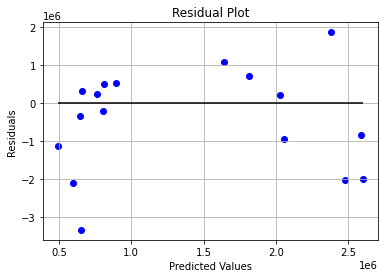

In [ ]:
y_pred = model.predict(X_test) # 検証データを用いて目的変数を予測
# y_pred = scaler.inverse_transform(reg.predict(X_sc))
plt.scatter(y_pred, y_pred - y_test, color = 'blue')      # 残差をプロット 
plt.hlines(y = 0, xmin = np.min(y_pred), xmax = np.max(y_pred), color = 'black') # x軸に沿った直線をプロット
plt.title('Residual Plot')                                # 図のタイトル
plt.xlabel('Predicted Values')                            # x軸のラベル
plt.ylabel('Residuals')                                   # y軸のラベル
plt.grid()                                                # グリッド線を表示

plt.show() 

平方根平均二乗誤差

In [ ]:
# 学習データに対する目的変数を予測
y_train_pred = model.predict(X_train)
print('RMSE train data: {:.3g}'.format(np.sqrt(mean_squared_error(y_train, y_train_pred)))) 
print('RMSE test data: {:.3g}'.format(np.sqrt(mean_squared_error(y_test, y_pred))))  

RMSE train data: 7.46e+05
RMSE test data: 1.39e+06


決定係数

In [ ]:
print('R2 train data: {:.4g}'.format(r2_score(y_train, y_train_pred)))
print('R2 test data: {:.4g}'.format(r2_score(y_test, y_pred)))

R2 train data: 0.5994
R2 test data: 0.1355


自由度調整済み決定係数.  
[参考資料](https://qiita.com/bianca26neve/items/4ddcf5ca12652b652f04)

In [ ]:
#自由度調整済み決定係数を計算する関数を定義する
def adj_r2_score(y_true, y_pred, p=X.shape[1]):
    return 1-(1-r2_score(y_true, y_pred)) * ((len(y_true)-1) / (len(y_true) - p - 1))
    

print('adj_R2 train data: {:.4g}'.format(adj_r2_score(y_train, y_train_pred)))
print('adj_R2 test data: {:.4g}'.format(adj_r2_score(y_test, y_pred)))
#---> 0.7337897263724629

adj_R2 train data: 1.335
adj_R2 test data: 1.21


In [ ]:
import statsmodels.api as sm
#定数項の追加
X1 = sm.add_constant(X)
m = sm.OLS(y, X1)
result = m.fit()
#決定係数の表示
print(result.rsquared)
#---> 0.7406426641094095
#自由度調整済み決定係数の表示
print(result.rsquared_adj)
#---> 0.733789726372463

0.8748724198328872
0.6754503389415512


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
X.shape

(84, 67)

In [ ]:
(len(y_train) - 1)

66

交差検証を行う

In [ ]:
from sklearn.model_selection import cross_val_score
import numpy as npr
from sklearn.model_selection import KFold

ridge= Ridge(alpha=10)
# 交差検証
scores_default = cross_val_score(ridge, X_sc, y,cv =10)
# 各分割におけるスコア
print('Cross-Validation scores(default): \n{}'.format(scores_default))
# スコアの平均値
print('Average score(default): {}'.format(np.mean(scores_default)))

# 交差検証
kfold = KFold(n_splits=10,shuffle=True,random_state=1)
scores_kfold = cross_val_score(ridge, X_sc, y, cv=kfold)
# 各分割におけるスコア
print('Cross-validation scores(kfold): \n{}'.format(scores_kfold))
# スコアの平均値
print('Average score(kfold): {}'.format(np.mean(scores_kfold)))

Cross-Validation scores(default): 
[-0.13809562 -0.17211346  0.36392818 -1.88510453 -2.16435328  0.16992609
  0.07533474 -2.62305653  0.3531777  -1.12416672]
Average score(default): -0.7144523419144424
Cross-validation scores(kfold): 
[-0.50772595  0.26333635 -0.07094288  0.50383555  0.44648244 -0.85107983
  0.01017755  0.43195824  0.59700053 -3.28065082]
Average score(kfold): -0.2457608826835179


In [ ]:
y_test

array([[0.71201272],
       [0.06788849],
       [0.19822736],
       [0.35147902],
       [0.83292341],
       [0.076682  ],
       [0.5471345 ],
       [0.02963631],
       [0.96482598],
       [0.18000568],
       [0.61308579],
       [0.02282178],
       [0.06898768],
       [0.31410663],
       [0.17341055],
       [0.94284222],
       [0.03711123]])

In [ ]:
with pd.ExcelWriter('/content/drive/MyDrive/iroribi_dev_local/20orMoreandLessThan500_predict.xlsx', mode='a') as writer:
    data[['合計金額','pred','誤差']].to_excel(writer, sheet_name='ver16')
dfAppend = pd.Series([predict_score[0],predict_score[1],reg.score(X_sc, y_sc), data['誤差'].abs().sum()], index=df.columns, name='ver16')
df = df.append(dfAppend)
df

,train_score,test_score,all_score,abs_error
version,,,,
ver04,0.697263,-0.722209,0.310264,5.373249e+07
ver05,0.705413,-3.030479,0.477416,2.242503e+07
ver06,0.706024,-0.450331,0.392258,5.328221e+07
ver07,0.703590,-0.553614,0.361725,5.275066e+07
ver08,0.703939,-0.483903,0.381442,5.226357e+07
ver09,0.728384,-0.867372,0.291149,5.433036e+07
ver10,0.743133,-3.063889,0.505054,2.181556e+07
ver11,0.738052,-0.668544,0.353359,5.382051e+07
ver12,0.898774,-51.186354,-13.649760,9.629948e+07


In [ ]:
#作成したモデルの重み係数の絶対値を降順に表示
#version1
col_s = []
coef_s = []
#zipで複数のリストの要素を同時に取得
for i, (col, coef) in enumerate(zip(X, reg.coef_[0])):
    col_s.append(col)
    coef_s.append(coef)
coef = pd.DataFrame({'col':col_s, 'coef':coef_s})
coef['coef_abs'] = coef['coef'].abs()
coef.sort_values('coef_abs',ascending=False)

,col,coef,coef_abs
55,機器_ファンコイル,0.124748,0.124748
40,工事計画_改修(新設),0.078151,0.078151
54,機器_パッケージエアコン,0.077641,0.077641
29,用途_オフィス,0.077599,0.077599
51,機器_SP,-0.054341,0.054341
...,...,...,...
35,用途_機械室・屋外,0.002143,0.002143
6,機器能力\n(kw),-0.000188,0.000188
57,機器_冷水コイル,0.000000,0.000000
64,機器_蒸気遮断弁,0.000000,0.000000


##グラフを作成して可視化

In [ ]:
parameters = {  
    'n_estimators': [3,7],     # 用意する決定木モデルの数
    'max_features': ('sqrt', 'log2','auto', None),  # ランダムに指定する特徴量の数
    'max_depth':    (10, None),     # 決定木のノード深さの制限値
}

# モデルインスタンス
model = RFR(n_jobs=-1, random_state=2525)

# ハイパーパラメータチューニング(グリッドサーチのコンストラクタにモデルと辞書パラメータを指定)
gridsearch = GridSearchCV(estimator = model,        # モデル
                          param_grid = parameters,  # チューニングするハイパーパラメータ
                          verbose=0
                         )


# 演算実行
gridsearch.fit(X_train, y_train)

# グリッドサーチの結果から得られた最適なパラメータ候補を確認
print('Best params: {}'.format(gridsearch.best_params_)) 
print('Best Score: {}'.format(gridsearch.best_score_))

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

Best params: {'max_depth': None, 'max_features': 'log2', 'n_estimators': 7}
Best Score: 0.25415995038327877


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


In [ ]:
# 最適なハイパーパラメータの組み合わせを用いたモデルで予測
predicted_amount = gridsearch.best_estimator_.predict(X)
gridsearch.best_estimator_.score(X,y)

0.6960929836924485

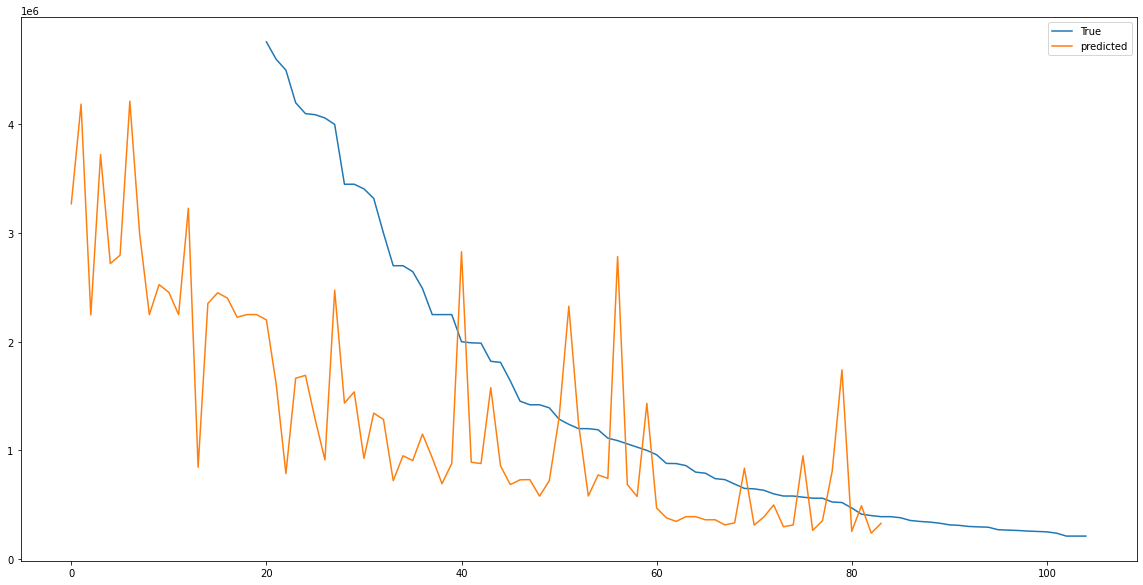

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.plot(y,label="True")
plt.plot(predicted_amount, label="predicted")
plt.legend()

## 室内負荷を線形補完してみる,必要エネルギー量は0埋めしておく

In [ ]:
all_data = pd.read_excel('/content/drive/MyDrive/iroribi_dev_local/20220713_予算化用データ.xlsx')
data = all_data[all_data["工事金額"] == "20万以上500万未満"] #shape(84,55)
data[['合計金額']] = data[['合計金額']].fillna(method='ffill')

X = data.iloc[:, 2:14] #X:説明変数
y = data[['合計金額']] #y:目的変数
#カラムのデータ型変更
X = X.drop('工事金額', axis=1)
X['入居人数（人）']=pd.to_numeric(X['入居人数（人）'],errors="coerce")
X['室内負荷（kw）']=pd.to_numeric(X['室内負荷（kw）'],errors="coerce")
X['必要エネルギー量（外気量）（㎥/h）']=pd.to_numeric(X['必要エネルギー量（外気量）（㎥/h）'],errors="coerce")
X['必要エネルギー量（排気量）（㎥/h）']=pd.to_numeric(X['必要エネルギー量（排気量）（㎥/h）'],errors="coerce")
X['室内負荷（kw）'] = X['室内負荷（kw）'].interpolate()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [ ]:
X['室内負荷（kw）']

20       8.8
21       4.4
22      38.0
23       4.4
24       3.7
       ...  
99     180.0
100    180.0
101    180.0
102    180.0
104    180.0
Name: 室内負荷（kw）, Length: 84, dtype: float64

In [ ]:
all_data = pd.read_excel('/content/drive/MyDrive/iroribi_dev_local/20220713_予算化用データ.xlsx')
data = all_data[all_data["工事金額"] == "20万以上500万未満"] #shape(84,55)
data[['合計金額']] = data[['合計金額']].fillna(method='ffill')

X = data.iloc[:, 2:14] #X:説明変数
y = data[['合計金額']] #y:目的変数
#カラムのデータ型変更
X = X.drop('工事金額', axis=1)
X['入居人数（人）']=pd.to_numeric(X['入居人数（人）'],errors="coerce")
X['室内負荷（kw）']=pd.to_numeric(X['室内負荷（kw）'],errors="coerce")
X['必要エネルギー量（外気量）（㎥/h）']=pd.to_numeric(X['必要エネルギー量（外気量）（㎥/h）'],errors="coerce")
X['必要エネルギー量（排気量）（㎥/h）']=pd.to_numeric(X['必要エネルギー量（排気量）（㎥/h）'],errors="coerce")
X['室内負荷（kw）'] = X['室内負荷（kw）'].interpolate()
X = X.fillna(0)
X[['入居人数（人）', '必要エネルギー量（外気量）（㎥/h）','必要エネルギー量（排気量）（㎥/h）']] = X[['入居人数（人）', '必要エネルギー量（外気量）（㎥/h）','必要エネルギー量（排気量）（㎥/h）']].astype('int')

X = pd.get_dummies(X)
#正規化部分____________
scaler = MinMaxScaler()
X_sc = scaler.fit_transform(X)
y_sc = scaler.fit_transform(y)
#__________________________
reg,predict_score = create_RegressionModel(X_sc,y_sc)
data = predict_model(data,reg,X_sc)
data[['合計金額','pred','誤差']]

train_intercept [0.5287881]
train_score 0.6827469710202185
test_score -3.0432193399727563
誤差: 62073113.466278516


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyd

,合計金額,pred,誤差
20,4760000.0,2.895158e+06,1.864842e+06
21,4600000.0,2.408140e+06,2.191860e+06
22,4500000.0,5.726215e+06,-1.226215e+06
23,4200000.0,2.916918e+06,1.283082e+06
24,4100000.0,3.704146e+06,3.958542e+05
...,...,...,...
99,254000.0,2.540000e+05,-6.082701e-09
100,250078.0,5.858666e+05,-3.357886e+05
101,238000.0,-1.535894e+05,3.915894e+05
102,211188.0,3.297643e+05,-1.185763e+05


In [ ]:
data[['合計金額','pred','誤差']].to_excel('/content/drive/MyDrive/iroribi_dev_local/20orMoreandLessThan500_predict.xlsx', sheet_name='IndoorLoad_interpolate')
dfAppend = pd.Series([predict_score[0],predict_score[1],reg.score(X_sc, y_sc), data['誤差'].abs().sum()], index=df.columns, name='IndoorLoad_interpolate')
df = df.append(dfAppend)
df

,train_score,test_score,all_score,abs_error
version,,,,
0fill,0.664543,-4.483825,-0.258837,6.725964e+07
DeleteMissing,0.747379,-4.584459,0.295312,2.634851e+07
LinearInterpolation,0.691661,-4.871938,-0.306194,6.838771e+07
IndoorLoad_interpolate,0.682747,-3.043219,0.014483,6.207311e+07


In [ ]:
#作成したモデルの重み係数の絶対値を降順に表示
#version1
col_s = []
coef_s = []
#zipで複数のリストの要素を同時に取得
for i, (col, coef) in enumerate(zip(X, reg.coef_[0])):
    col_s.append(col)
    coef_s.append(coef)
coef = pd.DataFrame({'col':col_s, 'coef':coef_s})
coef['coef_abs'] = coef['coef'].abs()
coef.sort_values('coef_abs',ascending=False)

,col,coef,coef_abs
1,入居人数（人）,1.742495e+00,1.742495e+00
0,工事面積（㎡）,-1.699546e+00,1.699546e+00
13,内装仕上げ（壁）_LGS+石膏ボード,-6.256048e-01,6.256048e-01
38,工事条件_休日,-4.038666e-01,4.038666e-01
11,内装仕上げ（壁）_ALC,3.805398e-01,3.805398e-01
18,内装仕上げ（床）_フリーアクセスフロア,-3.428591e-01,3.428591e-01
40,工事条件_平日/休日,3.202234e-01,3.202234e-01
34,工事計画_整備,-3.118157e-01,3.118157e-01
28,用途_機械室・屋外,-3.118157e-01,3.118157e-01
17,内装仕上げ（床）_OAフロア,3.020511e-01,3.020511e-01


## 

欠損には、空白と「-」の二種類があるので、先にobject型からfloat型に変えて二種類の欠損を同時に削除

In [ ]:
all_data = pd.read_excel('/content/drive/MyDrive/iroribi_dev_local/20220713_予算化用データ.xlsx')
data = all_data[all_data["工事金額"] == "20万以上500万未満"] #shape(84,55)
data[['合計金額']] = data[['合計金額']].fillna(method='ffill')
#必要エネルギー量（外気量）（㎥/h）に欠損がある行を削除
data['必要エネルギー量（外気量）（㎥/h）']=pd.to_numeric(data['必要エネルギー量（外気量）（㎥/h）'],errors="coerce")
print("必要エネルギー量（外気量）（㎥/h）の欠損数")
print("Before:",data['必要エネルギー量（外気量）（㎥/h）'].isnull().sum())
data = data.dropna(subset=['必要エネルギー量（外気量）（㎥/h）'])
print("After:",data['必要エネルギー量（外気量）（㎥/h）'].isnull().sum())

必要エネルギー量（外気量）（㎥/h）の欠損数
Before: 49
After: 0


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [ ]:
X = data.iloc[:, 2:14] #X:説明変数
y = data[['合計金額']] #y:目的変数
#カラムのデータ型変更
X = X.drop('工事金額', axis=1)
X['入居人数（人）']=pd.to_numeric(X['入居人数（人）'],errors="coerce")
X['室内負荷（kw）']=pd.to_numeric(X['室内負荷（kw）'],errors="coerce")
X['必要エネルギー量（排気量）（㎥/h）']=pd.to_numeric(X['必要エネルギー量（排気量）（㎥/h）'],errors="coerce")
X = X.fillna(0)
X[['入居人数（人）', '必要エネルギー量（外気量）（㎥/h）','必要エネルギー量（排気量）（㎥/h）']] = X[['入居人数（人）', '必要エネルギー量（外気量）（㎥/h）','必要エネルギー量（排気量）（㎥/h）']].astype('int')
X = pd.get_dummies(X)
#正規化部分____________
scaler = MinMaxScaler()
X_sc = scaler.fit_transform(X)
y_sc = scaler.fit_transform(y)
#__________________________

reg,predict_score = create_RegressionModel(X_sc,y_sc)
data = predict_model(data,reg,X_sc)
data[['合計金額','pred','誤差']]

train_intercept [-6.48923464]
train_score 0.7473788287122152
test_score -4.5844590766788
誤差: 26348507.57071881


,合計金額,pred,誤差
20,4760000.0,2.799110e+06,1.960890e+06
21,4600000.0,3.155078e+06,1.444922e+06
22,4500000.0,4.311742e+06,1.882579e+05
23,4200000.0,4.200000e+06,-1.210719e-08
24,4100000.0,4.100000e+06,5.122274e-09
25,4090000.0,4.090000e+06,3.725290e-09
26,4060000.0,4.060000e+06,-4.656613e-09
27,4000000.0,4.000000e+06,-8.847564e-09
28,3450000.0,2.523265e+06,9.267346e+05
29,3450000.0,2.762259e+06,6.877411e+05


In [ ]:
with pd.ExcelWriter('/content/drive/MyDrive/iroribi_dev_local/20orMoreandLessThan500_predict.xlsx', mode='a') as writer:
    data[['合計金額','pred','誤差']].to_excel(writer, sheet_name='DeleteMissing')
  
dfAppend = pd.Series([predict_score[0],predict_score[1],reg.score(X_sc, y_sc), data['誤差'].abs().sum()], index=df.columns, name='DeleteMissing')
df = df.append(dfAppend)
df

,train_score,test_score,all_score,abs_error
version,,,,
0fill,0.664543,-4.483825,-0.258837,6.725964e+07
DeleteMissing,0.747379,-4.584459,0.295312,2.634851e+07


In [ ]:
#作成したモデルの重み係数の絶対値を降順に表示
col_s = []
coef_s = []
#zipで複数のリストの要素を同時に取得
for i, (col, coef) in enumerate(zip(X, reg.coef_[0])):
    col_s.append(col)
    coef_s.append(coef)
coef = pd.DataFrame({'col':col_s, 'coef':coef_s})
coef['coef_abs'] = coef['coef'].abs()
coef.sort_values('coef_abs',ascending=False)

,col,coef,coef_abs
0,工事面積（㎡）,1.987438e+01,1.987438e+01
1,入居人数（人）,-9.029146e+00,9.029146e+00
29,工事条件_平日,-7.609058e+00,7.609058e+00
28,工事条件_休日,6.540134e+00,6.540134e+00
2,室内負荷（kw）,-1.726224e+00,1.726224e+00
23,用途_機械室,1.088707e+00,1.088707e+00
30,工事条件_平日/休日,1.068924e+00,1.068924e+00
20,用途_厨房,-1.040783e+00,1.040783e+00
13,内装仕上げ（壁）_LGS＋石膏ボード,-1.040783e+00,1.040783e+00
24,工事計画_修繕,-1.021000e+00,1.021000e+00


## version3:線形補完(LinearInterpolation)

In [ ]:
all_data = pd.read_excel('/content/drive/MyDrive/iroribi_dev_local/20220713_予算化用データ.xlsx')
data = all_data[all_data["工事金額"] == "20万以上500万未満"] #shape(84,55)
data[['合計金額']] = data[['合計金額']].fillna(method='ffill')
X = data.iloc[:, 2:14] #X:説明変数
X = X.drop('工事金額', axis=1)
X['入居人数（人）']=pd.to_numeric(X['入居人数（人）'],errors="coerce")
X['室内負荷（kw）']=pd.to_numeric(X['室内負荷（kw）'],errors="coerce")
X['必要エネルギー量（外気量）（㎥/h）']=pd.to_numeric(X['必要エネルギー量（外気量）（㎥/h）'],errors="coerce")
X['必要エネルギー量（排気量）（㎥/h）']=pd.to_numeric(X['必要エネルギー量（排気量）（㎥/h）'],errors="coerce")
y = data[['合計金額']] #y:目的変数N

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [ ]:
test = pd.DataFrame(X["必要エネルギー量（外気量）（㎥/h）"])
test

,必要エネルギー量（外気量）（㎥/h）
20,1200.0
21,600.0
22,5100.0
23,600.0
24,400.0
...,...
99,2340.0
100,5724.0
101,NaN
102,NaN


In [ ]:
test["必要エネルギー量（外気量）（㎥/h）_線形補完"] = X["必要エネルギー量（外気量）（㎥/h）"].interpolate()
test

,必要エネルギー量（外気量）（㎥/h）,必要エネルギー量（外気量）（㎥/h）_線形補完
20,1200.0,1200.0
21,600.0,600.0
22,5100.0,5100.0
23,600.0,600.0
24,400.0,400.0
...,...,...
99,2340.0,2340.0
100,5724.0,5724.0
101,NaN,5724.0
102,NaN,5724.0


In [ ]:
all_data = pd.read_excel('/content/drive/MyDrive/iroribi_dev_local/20220713_予算化用データ.xlsx')
data = all_data[all_data["工事金額"] == "20万以上500万未満"] #shape(84,55)
data[['合計金額']] = data[['合計金額']].fillna(method='ffill')
X = data.iloc[:, 2:14] #X:説明変数
X = X.drop('工事金額', axis=1)
X['入居人数（人）']=pd.to_numeric(X['入居人数（人）'],errors="coerce")
X['室内負荷（kw）']=pd.to_numeric(X['室内負荷（kw）'],errors="coerce")
X['必要エネルギー量（外気量）（㎥/h）']=pd.to_numeric(X['必要エネルギー量（外気量）（㎥/h）'],errors="coerce")
X['必要エネルギー量（排気量）（㎥/h）']=pd.to_numeric(X['必要エネルギー量（排気量）（㎥/h）'],errors="coerce")
y = data[['合計金額']] #y:目的変数N
X["必要エネルギー量（外気量）（㎥/h）"] = X["必要エネルギー量（外気量）（㎥/h）"].interpolate()
X = X.fillna(0)
X[['入居人数（人）', '必要エネルギー量（外気量）（㎥/h）','必要エネルギー量（排気量）（㎥/h）']] = X[['入居人数（人）', '必要エネルギー量（外気量）（㎥/h）','必要エネルギー量（排気量）（㎥/h）']].astype('int')

X = pd.get_dummies(X)
#正規化部分____________
scaler = MinMaxScaler()
X_sc = scaler.fit_transform(X)
y_sc = scaler.fit_transform(y)
#__________________________

reg,predict_score = create_RegressionModel(X_sc,y_sc)
data = predict_model(data,reg,X_sc)
data[['合計金額','pred','誤差']]

train_intercept [3.10915052]
train_score 0.6916608045249935
test_score -4.8719380036889826
誤差: 68387708.45856623


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyd

,合計金額,pred,誤差
20,4760000.0,2.973959e+06,1.786041e+06
21,4600000.0,2.486300e+06,2.113700e+06
22,4500000.0,5.732005e+06,-1.232005e+06
23,4200000.0,2.934804e+06,1.265196e+06
24,4100000.0,3.725562e+06,3.744383e+05
...,...,...,...
99,254000.0,2.540000e+05,-4.569301e-09
100,250078.0,1.174179e+06,-9.241008e+05
101,238000.0,4.312594e+05,-1.932594e+05
102,211188.0,9.533761e+05,-7.421881e+05


In [ ]:
with pd.ExcelWriter('/content/drive/MyDrive/iroribi_dev_local/20orMoreandLessThan500_predict.xlsx', mode='a') as writer:
    data[['合計金額','pred','誤差']].to_excel(writer, sheet_name='LinearInterpolation')

dfAppend = pd.Series([predict_score[0],predict_score[1],reg.score(X_sc, y_sc), data['誤差'].abs().sum()], index=df.columns, name='LinearInterpolation')
df = df.append(dfAppend)
df

,train_score,test_score,all_score,abs_error
version,,,,
0fill,0.664543,-4.483825,-0.258837,6.725964e+07
DeleteMissing,0.747379,-4.584459,0.295312,2.634851e+07
LinearInterpolation,0.691661,-4.871938,-0.306194,6.838771e+07


In [ ]:
#作成したモデルの重み係数の絶対値を降順に表示
col_s = []
coef_s = []
#zipで複数のリストの要素を同時に取得
for i, (col, coef) in enumerate(zip(X, reg.coef_[0])):
    col_s.append(col)
    coef_s.append(coef)
coef = pd.DataFrame({'col':col_s, 'coef':coef_s})
coef['coef_abs'] = coef['coef'].abs()
coef.sort_values('coef_abs',ascending=False)

,col,coef,coef_abs
2,室内負荷（kw）,-8.189644e+00,8.189644e+00
39,工事条件_平日,4.579951e+00,4.579951e+00
1,入居人数（人）,3.316741e+00,3.316741e+00
38,工事条件_休日,-3.028016e+00,3.028016e+00
40,工事条件_平日/休日,-1.551935e+00,1.551935e+00
0,工事面積（㎡）,-1.474192e+00,1.474192e+00
34,工事計画_整備,-6.247406e-01,6.247406e-01
28,用途_機械室・屋外,-6.247406e-01,6.247406e-01
13,内装仕上げ（壁）_LGS+石膏ボード,-6.196726e-01,6.196726e-01
11,内装仕上げ（壁）_ALC,3.647735e-01,3.647735e-01


## 各モデルによる合計金額と予測金額の絶対値の誤差を一覧で書き出す.  
（sheet:EachModel_score）

In [ ]:
with pd.ExcelWriter('/content/drive/MyDrive/iroribi_dev_local/20orMoreandLessThan500_predict.xlsx', mode='a') as writer:
    df.to_excel(writer, sheet_name='EachModel_score')

## version18:ランダムフォレスト(説明変数ver2)

In [ ]:
version = 18
data = pd.read_excel('/content/drive/MyDrive/iroribi_dev_local/20220830_予算化用データ.xlsx'\
                     ,sheet_name='マスターデータ')
data = data[data["工事金額"] == "20万以上500万未満"]
data[['合計金額']] = data[['合計金額']].fillna(method='ffill')


#X:説明変数
X = data.loc[:,'内装仕上げ（天井）':'台数\n（新設）']
drop_colmuns = ['用途（整理用）\n※追加','工事金額',\
                '工事金額（整理用）','工事面積（整理用）','機器（整理用）\n※追加']
X = X.drop(drop_colmuns, axis=1)
#y:目的変数
y = data[['合計金額']]

#工事面積以外の列はobject型なのでカラムのデータ型変更(じゃないと欠損値操作できない)
#説明変数のカラムを取得し、データ変換したいカラム(入居人数以降)をdum_listに格納
col_list = X.columns.tolist()
dum_list = col_list[col_list.index('入居人数（人）'):]
dum_list.remove('機器')

#dum_list内にある要素名のカラムをfloatに変換
for i in dum_list:
  X[i]=pd.to_numeric(X[i],errors="coerce")

#欠損値操作
X["必要エネルギー量（外気量）（㎥/h）"] = X["必要エネルギー量（外気量）（㎥/h）"].interpolate()
X = X.fillna(0)
X = pd.get_dummies(X)

model,score,pred,imp = create_RFR(X,y,data,version)

#各Dataframeへ追記
Predict,EachModel_Score,Importance =to_df(Predict,EachModel_Score,Importance,\
                                          pred,score,imp)

Fitting 10 folds for each of 32 candidates, totalling 320 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

cv_restults
{'mean_fit_time': array([0.59231722, 1.04497814, 0.48743119, 1.02043936, 0.57260978,
       1.23934219, 0.58039989, 1.29772975, 0.49164987, 1.03950722,
       0.49335303, 1.0385308 , 0.59828532, 1.28414166, 0.60159159,
       1.28611367, 0.53413675, 1.0508621 , 0.50329549, 1.04928389,
       0.60593503, 1.31264641, 0.61803586, 1.30527613, 0.50841658,
       1.07683082, 0.5115844 , 1.06319904, 0.61076143, 1.30464196,
       0.60286872, 1.29648135]),
 'mean_score_time': array([0.105583  , 0.18555439, 0.10550737, 0.13523753, 0.10553024,
       0.17570968, 0.10548909, 0.16569412, 0.10537081, 0.14546597,
       0.10540779, 0.17542055, 0.1054714 , 0.16552169, 0.10570693,
       0.195807  , 0.11748242, 0.14546404, 0.10531929, 0.17581351,
       0.10556777, 0.18593647, 0.10591035, 0.19597161, 0.10538223,
       0.19583163, 0.10543187, 0.16555555, 0.10577891, 0.16566243,
       0.10547605, 0.17580445]),
 'mean_test_score': array([0.4094853 , 0.41342715, 0.37255558, 0.38857396, 0.390

#### versionごとの出力確認セル 

In [ ]:
EachModel_Score[EachModel_Score['version'] == version]

,version,モデル,データ区分,サンプルサイズ,R2,adj_R2,RMSE
32,17,"RandomForestRegressor(max_depth=20, max_featur...",train,123,0.928160,0.775269,1.166586e+11
33,17,"RandomForestRegressor(max_depth=20, max_featur...",test,14,0.389129,0.000000,5.755934e+11


In [ ]:
Predict[Predict['version'] == version]

,version,データ区分,No,見積もりID,合計金額,pred,誤差
1853,17,train,1,20,4.980000e+06,3.910504e+06,1.069496e+06
1854,17,train,2,21,4.918819e+06,4.195505e+06,7.233139e+05
1855,17,train,3,22,4.873499e+06,4.372592e+06,5.009063e+05
1856,17,train,4,23,4.760000e+06,3.996895e+06,7.631052e+05
1857,17,train,5,24,4.680000e+06,3.567655e+06,1.112345e+06
...,...,...,...,...,...,...,...
1985,17,test,10,79,8.788130e+05,1.089437e+06,-2.106239e+05
1986,17,test,11,98,6.000000e+05,1.730308e+06,-1.130308e+06
1987,17,test,12,105,5.700000e+05,9.101077e+05,-3.401077e+05
1988,17,test,13,106,5.695790e+05,7.734497e+05,-2.038707e+05


In [ ]:
Importance[Importance['version'] == version]

,version,col,importance,imp
837,17,工事面積（㎡）,NaN,0.139668
838,17,機器能力\n(kw),NaN,0.095992
839,17,入居人数（人）,NaN,0.092868
840,17,必要エネルギー量（外気量）（㎥/h）,NaN,0.088135
841,17,室内負荷（kw）,NaN,0.084429
...,...,...,...,...
915,17,機器_電磁弁,NaN,0.000055
916,17,内装仕上げ（天井）_在来天井＋クリーンクロス,NaN,0.000052
917,17,機器_蒸気遮断弁,NaN,0.000045
918,17,機器_ベアリング,NaN,0.000035


## version19:XGboost(説明変数ver1)

In [ ]:
version = 19
data = pd.read_excel('/content/drive/MyDrive/iroribi_dev_local/20220830_予算化用データ.xlsx'\
                     ,sheet_name='マスターデータ')
data = data[data["工事金額"] == "20万以上500万未満"]
data[['合計金額']] = data[['合計金額']].fillna(method='ffill')


#X:説明変数
X = data.loc[:,'内装仕上げ（天井）':'台数\n（新設）']
drop_colmuns = ['用途（整理用）\n※追加','工事金額',\
                '工事金額（整理用）','工事面積（整理用）','機器（整理用）\n※追加']
X = X.drop(drop_colmuns, axis=1)
#y:目的変数
y = data[['合計金額']]

#工事面積以外の列はobject型なのでカラムのデータ型変更(じゃないと欠損値操作できない)
#説明変数のカラムを取得し、データ変換したいカラム(入居人数以降)をdum_listに格納
col_list = X.columns.tolist()
dum_list = col_list[col_list.index('入居人数（人）'):]
dum_list.remove('機器')

#dum_list内にある要素名のカラムをfloatに変換
for i in dum_list:
  X[i]=pd.to_numeric(X[i],errors="coerce")

#欠損値操作
X["必要エネルギー量（外気量）（㎥/h）"] = X["必要エネルギー量（外気量）（㎥/h）"].interpolate()
X = X.fillna(0)
X = pd.get_dummies(X)

model,score,pred,imp = create_RFR(X,y,data,version)

#各Dataframeへ追記
Predict,EachModel_Score,Importance =to_df(Predict,EachModel_Score,Importance,\
                                          pred,score,imp)

Fitting 10 folds for each of 32 candidates, totalling 320 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

cv_restults
{'mean_fit_time': array([0.59231722, 1.04497814, 0.48743119, 1.02043936, 0.57260978,
       1.23934219, 0.58039989, 1.29772975, 0.49164987, 1.03950722,
       0.49335303, 1.0385308 , 0.59828532, 1.28414166, 0.60159159,
       1.28611367, 0.53413675, 1.0508621 , 0.50329549, 1.04928389,
       0.60593503, 1.31264641, 0.61803586, 1.30527613, 0.50841658,
       1.07683082, 0.5115844 , 1.06319904, 0.61076143, 1.30464196,
       0.60286872, 1.29648135]),
 'mean_score_time': array([0.105583  , 0.18555439, 0.10550737, 0.13523753, 0.10553024,
       0.17570968, 0.10548909, 0.16569412, 0.10537081, 0.14546597,
       0.10540779, 0.17542055, 0.1054714 , 0.16552169, 0.10570693,
       0.195807  , 0.11748242, 0.14546404, 0.10531929, 0.17581351,
       0.10556777, 0.18593647, 0.10591035, 0.19597161, 0.10538223,
       0.19583163, 0.10543187, 0.16555555, 0.10577891, 0.16566243,
       0.10547605, 0.17580445]),
 'mean_test_score': array([0.4094853 , 0.41342715, 0.37255558, 0.38857396, 0.390

#### versionごとの出力確認セル 

In [ ]:
EachModel_Score[EachModel_Score['version'] == version]

,version,モデル,データ区分,サンプルサイズ,R2,adj_R2,RMSE
32,17,"RandomForestRegressor(max_depth=20, max_featur...",train,123,0.928160,0.775269,1.166586e+11
33,17,"RandomForestRegressor(max_depth=20, max_featur...",test,14,0.389129,0.000000,5.755934e+11


In [ ]:
Predict[Predict['version'] == version]

,version,データ区分,No,見積もりID,合計金額,pred,誤差
1853,17,train,1,20,4.980000e+06,3.910504e+06,1.069496e+06
1854,17,train,2,21,4.918819e+06,4.195505e+06,7.233139e+05
1855,17,train,3,22,4.873499e+06,4.372592e+06,5.009063e+05
1856,17,train,4,23,4.760000e+06,3.996895e+06,7.631052e+05
1857,17,train,5,24,4.680000e+06,3.567655e+06,1.112345e+06
...,...,...,...,...,...,...,...
1985,17,test,10,79,8.788130e+05,1.089437e+06,-2.106239e+05
1986,17,test,11,98,6.000000e+05,1.730308e+06,-1.130308e+06
1987,17,test,12,105,5.700000e+05,9.101077e+05,-3.401077e+05
1988,17,test,13,106,5.695790e+05,7.734497e+05,-2.038707e+05


In [ ]:
Importance[Importance['version'] == version]

,version,col,importance,imp
837,17,工事面積（㎡）,NaN,0.139668
838,17,機器能力\n(kw),NaN,0.095992
839,17,入居人数（人）,NaN,0.092868
840,17,必要エネルギー量（外気量）（㎥/h）,NaN,0.088135
841,17,室内負荷（kw）,NaN,0.084429
...,...,...,...,...
915,17,機器_電磁弁,NaN,0.000055
916,17,内装仕上げ（天井）_在来天井＋クリーンクロス,NaN,0.000052
917,17,機器_蒸気遮断弁,NaN,0.000045
918,17,機器_ベアリング,NaN,0.000035


## version20:XGboost(説明変数ver2)

In [ ]:
version = 20
data = pd.read_excel('/content/drive/MyDrive/iroribi_dev_local/20220830_予算化用データ.xlsx'\
                     ,sheet_name='マスターデータ')
data = data[data["工事金額"] == "20万以上500万未満"]
data[['合計金額']] = data[['合計金額']].fillna(method='ffill')


#X:説明変数
X = data.loc[:,'内装仕上げ（天井）':'台数\n（新設）']
drop_colmuns = ['用途（整理用）\n※追加','工事金額',\
                '工事金額（整理用）','工事面積（整理用）','機器（整理用）\n※追加']
X = X.drop(drop_colmuns, axis=1)
#y:目的変数
y = data[['合計金額']]

#工事面積以外の列はobject型なのでカラムのデータ型変更(じゃないと欠損値操作できない)
#説明変数のカラムを取得し、データ変換したいカラム(入居人数以降)をdum_listに格納
col_list = X.columns.tolist()
dum_list = col_list[col_list.index('入居人数（人）'):]
dum_list.remove('機器')

#dum_list内にある要素名のカラムをfloatに変換
for i in dum_list:
  X[i]=pd.to_numeric(X[i],errors="coerce")

#欠損値操作
X["必要エネルギー量（外気量）（㎥/h）"] = X["必要エネルギー量（外気量）（㎥/h）"].interpolate()
X = X.fillna(0)
X = pd.get_dummies(X)

model,score,pred,imp = create_RFR(X,y,data,version)

#各Dataframeへ追記
Predict,EachModel_Score,Importance =to_df(Predict,EachModel_Score,Importance,\
                                          pred,score,imp)

Fitting 10 folds for each of 32 candidates, totalling 320 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

cv_restults
{'mean_fit_time': array([0.59231722, 1.04497814, 0.48743119, 1.02043936, 0.57260978,
       1.23934219, 0.58039989, 1.29772975, 0.49164987, 1.03950722,
       0.49335303, 1.0385308 , 0.59828532, 1.28414166, 0.60159159,
       1.28611367, 0.53413675, 1.0508621 , 0.50329549, 1.04928389,
       0.60593503, 1.31264641, 0.61803586, 1.30527613, 0.50841658,
       1.07683082, 0.5115844 , 1.06319904, 0.61076143, 1.30464196,
       0.60286872, 1.29648135]),
 'mean_score_time': array([0.105583  , 0.18555439, 0.10550737, 0.13523753, 0.10553024,
       0.17570968, 0.10548909, 0.16569412, 0.10537081, 0.14546597,
       0.10540779, 0.17542055, 0.1054714 , 0.16552169, 0.10570693,
       0.195807  , 0.11748242, 0.14546404, 0.10531929, 0.17581351,
       0.10556777, 0.18593647, 0.10591035, 0.19597161, 0.10538223,
       0.19583163, 0.10543187, 0.16555555, 0.10577891, 0.16566243,
       0.10547605, 0.17580445]),
 'mean_test_score': array([0.4094853 , 0.41342715, 0.37255558, 0.38857396, 0.390

#### versionごとの出力確認セル 

In [ ]:
EachModel_Score[EachModel_Score['version'] == version]

,version,モデル,データ区分,サンプルサイズ,R2,adj_R2,RMSE
32,17,"RandomForestRegressor(max_depth=20, max_featur...",train,123,0.928160,0.775269,1.166586e+11
33,17,"RandomForestRegressor(max_depth=20, max_featur...",test,14,0.389129,0.000000,5.755934e+11


In [ ]:
Predict[Predict['version'] == version]

,version,データ区分,No,見積もりID,合計金額,pred,誤差
1853,17,train,1,20,4.980000e+06,3.910504e+06,1.069496e+06
1854,17,train,2,21,4.918819e+06,4.195505e+06,7.233139e+05
1855,17,train,3,22,4.873499e+06,4.372592e+06,5.009063e+05
1856,17,train,4,23,4.760000e+06,3.996895e+06,7.631052e+05
1857,17,train,5,24,4.680000e+06,3.567655e+06,1.112345e+06
...,...,...,...,...,...,...,...
1985,17,test,10,79,8.788130e+05,1.089437e+06,-2.106239e+05
1986,17,test,11,98,6.000000e+05,1.730308e+06,-1.130308e+06
1987,17,test,12,105,5.700000e+05,9.101077e+05,-3.401077e+05
1988,17,test,13,106,5.695790e+05,7.734497e+05,-2.038707e+05


In [ ]:
Importance[Importance['version'] == version]

,version,col,importance,imp
837,17,工事面積（㎡）,NaN,0.139668
838,17,機器能力\n(kw),NaN,0.095992
839,17,入居人数（人）,NaN,0.092868
840,17,必要エネルギー量（外気量）（㎥/h）,NaN,0.088135
841,17,室内負荷（kw）,NaN,0.084429
...,...,...,...,...
915,17,機器_電磁弁,NaN,0.000055
916,17,内装仕上げ（天井）_在来天井＋クリーンクロス,NaN,0.000052
917,17,機器_蒸気遮断弁,NaN,0.000045
918,17,機器_ベアリング,NaN,0.000035
